<a href="https://colab.research.google.com/github/matbar97/Software-to-support-analysis-and-classification-of-lesions-on-X-ray-lung-images/blob/main/224_MobileNetV2_X_ray_dataset_250_per_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up the workspace

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!nvidia-smi

Mon Aug 30 15:32:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    53W / 149W |    121MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle/"

In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


# Lib loading

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization,\
GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc, hinge_loss
from sklearn.neural_network import MLPClassifier

# Set-up for X-ray data I (to get labels for SVM training)

In [ ]:
categories = ['bacterial_pneumonia', 'covid-19','normal','tuberculosis', 'viral_pneumonia']
data_dir = 'X-ray dataset 250 per class/train'
train_dir = 'X-ray dataset 250 per class/train'
train_dir = os.path.join(train_dir)
val_dir ='X-ray dataset 250 per class/val'
val_dir = os.path.join(val_dir)
test_dir ='X-ray dataset 250 per class/test'
test_dir =os.path.join(test_dir)

print(categories)

['bacterial_pneumonia', 'covid-19', 'normal', 'tuberculosis', 'viral_pneumonia']


In [ ]:
train_data = []
val_data = []
test_data=[]
for defects_id, sp in enumerate(categories):
    i = 0
    for file in os.listdir(os.path.join(train_dir, sp)):
            train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
            i += 1

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID', 'Disease Type'])
print(train.head())

for defects_id, sp in enumerate(categories):
    i = 0
    for file in os.listdir(os.path.join(val_dir, sp)):
            val_data.append(['{}/{}'.format(sp, file), defects_id, sp])
            i += 1

val = pd.DataFrame(val_data, columns=['File', 'DiseaseID', 'Disease Type'])
print(val.head())


for defects_id, sp in enumerate(categories):
    i = 0
    for file in os.listdir(os.path.join(test_dir, sp)):
            test_data.append(['{}/{}'.format(sp, file), defects_id, sp])
            i += 1

test = pd.DataFrame(test_data, columns=['File', 'DiseaseID', 'Disease Type'])
print(test.head())

                               File  DiseaseID         Disease Type
0    bacterial_pneumonia/0 (2).jpeg          0  bacterial_pneumonia
1  bacterial_pneumonia/125 (2).jpeg          0  bacterial_pneumonia
2  bacterial_pneumonia/126 (2).jpeg          0  bacterial_pneumonia
3  bacterial_pneumonia/116 (2).jpeg          0  bacterial_pneumonia
4  bacterial_pneumonia/121 (2).jpeg          0  bacterial_pneumonia
                                              File  ...         Disease Type
0  bacterial_pneumonia/person139_bacteria_663.jpeg  ...  bacterial_pneumonia
1  bacterial_pneumonia/person140_bacteria_668.jpeg  ...  bacterial_pneumonia
2  bacterial_pneumonia/person130_bacteria_625.jpeg  ...  bacterial_pneumonia
3  bacterial_pneumonia/person137_bacteria_655.jpeg  ...  bacterial_pneumonia
4  bacterial_pneumonia/person130_bacteria_626.jpeg  ...  bacterial_pneumonia

[5 rows x 3 columns]
                                               File  ...         Disease Type
0  bacterial_pneumonia/person2

In [ ]:
SEED = 42

train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train))  # Reset indices
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID', 'Disease Type'])
print(train.head())

test = test.sample(frac=1, random_state=SEED)
test.index = np.arange(len(test))  # Reset indices
test = pd.DataFrame(test_data, columns=['File', 'DiseaseID', 'Disease Type'])
print(test.head())

val = val.sample(frac=1, random_state=SEED)
val.index = np.arange(len(val))  # Reset indices
val = pd.DataFrame(val_data, columns=['File', 'DiseaseID', 'Disease Type'])
print(val.head())


                               File  DiseaseID         Disease Type
0    bacterial_pneumonia/0 (2).jpeg          0  bacterial_pneumonia
1  bacterial_pneumonia/125 (2).jpeg          0  bacterial_pneumonia
2  bacterial_pneumonia/126 (2).jpeg          0  bacterial_pneumonia
3  bacterial_pneumonia/116 (2).jpeg          0  bacterial_pneumonia
4  bacterial_pneumonia/121 (2).jpeg          0  bacterial_pneumonia
                                               File  ...         Disease Type
0  bacterial_pneumonia/person275_bacteria_1294.jpeg  ...  bacterial_pneumonia
1  bacterial_pneumonia/person264_bacteria_1231.jpeg  ...  bacterial_pneumonia
2  bacterial_pneumonia/person281_bacteria_1326.jpeg  ...  bacterial_pneumonia
3  bacterial_pneumonia/person281_bacteria_1328.jpeg  ...  bacterial_pneumonia
4  bacterial_pneumonia/person293_bacteria_1379.jpeg  ...  bacterial_pneumonia

[5 rows x 3 columns]
                                              File  ...         Disease Type
0  bacterial_pneumonia/pe

# Initialize img size, epochs, lr, batch size

In [ ]:
IMAGE_SIZE = 224
EPOCHS = 100
lr = 5e-5
new_lr = 1e-5
BATCH_SIZE = 64

# Defining and loading Functions

In [ ]:
from keras import backend as K

def build_ImageNetModel(base_model):
  K.clear_session()

  NUM_CLASSES = len(categories)

  baseModel = base_model.output
  headModel = Flatten(name="flatten")(baseModel)
  headModel = BatchNormalization() (headModel)
  headModel = Dense(256, activation="relu")(headModel)
  headModel = Dropout(0.5, seed=42)(headModel)
  headModel = BatchNormalization() (headModel)
  headModel = Dense(128, activation="relu")(headModel)
  headModel = Dropout(0.5, seed=42)(headModel)
  headModel = BatchNormalization() (headModel)
  headModel = Dense(64, activation="relu")(headModel)
  headModel = Dropout(0.5, seed=42)(headModel)
  headModel = BatchNormalization() (headModel)
  headModel = Dense(NUM_CLASSES, activation="softmax")(headModel)

  model = Model(inputs=base_model.input, outputs=headModel)
  model.summary()
  return model

In [ ]:
def plot_acc(H, N, title):
	plt.style.use("ggplot")
	plt.figure(figsize=(10,10))
	plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
	plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
	plt.title(title)
	plt.xlabel("Epoch #")
	plt.ylabel("Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(title)

In [ ]:
def plot_loss(H, N, title):
	plt.style.use("ggplot")
	plt.figure(figsize=(10,10))
	plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
	plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
	plt.title(title)
	plt.xlabel("Epoch #")
	plt.ylabel("Loss")
	plt.legend(loc="lower left")
	plt.savefig(title)

In [ ]:
def plot_confusion_matrix(model_name, y_test, y_pred, classes, normalize= False):

  cm = confusion_matrix(y_test, y_pred)
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  plt.figure(figsize=(5.5, 5.5))
  plt.title((model_name), fontsize=9)
  ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=classes, yticklabels=classes)
  ax.set_ylabel('Actual', fontsize=13)
  ax.set_xlabel('Predicted', fontsize=13)
  tick_marks = np.arange(len(classes))
  ax.set_xticks(tick_marks, classes)
  ax.set_yticks(tick_marks, classes)
  plt.tight_layout()

  plt.show()

In [ ]:
def plot_ROC(y_test,y_score, n_classes, title):
  lw = 2

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:,i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Compute macro-average ROC curve and ROC area

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure(1, figsize=(9, 9))
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(categories[i], roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([-0.005, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(title)
  plt.legend(loc="lower right")
  plt.show()


  # Zoom in view of the upper left corner.
  plt.figure(2, figsize=(9, 9))
  plt.xlim(-0.02, 0.4)
  plt.ylim(0.8, 1.01)
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(categories[i], roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(title)
  plt.legend(loc="lower right")
  plt.show()

  return None

In [ ]:
def plot_ROC_SVM(X_train,y_train,X_test,y_test, y_score,
                            n_classes, class_labels, title, cv):

    lw = 2
    # Binarize (oneVSall) the multiclass predictions, for ROC curve plotting purposes
    y_train_binarized = label_binarize(y_train, classes=class_labels)
    y_test = label_binarize(y_test, classes=class_labels)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for cl in range(n_classes):
        fpr[cl], tpr[cl], _ = roc_curve(y_test[:, cl], y_score[:, cl])        
        roc_auc[cl] = auc(fpr[cl], tpr[cl])
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(1, figsize=(9, 9))
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(categories[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


    # Zoom in view of the upper left corner.
    plt.figure(2, figsize=(9, 9))
    plt.xlim(-0.02, 0.4)
    plt.ylim(0.8, 1.01)
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(categories[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('Representative Image')
    b = cv2.resize(a, (512,512))
    plt.imshow(b)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);


In [ ]:
def print_layers(model):
    for idx, layer in enumerate(model.layers):
        print("layer {}: {}, trainable: {}".format(idx, layer.name, layer.trainable))

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols)
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(train_dir, defect_files[n])
            image = cv2.imread(image_path)
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].set_title(defect_files[n], fontsize = 10)
            ax[i, j].imshow(image)
            n += 1

In [ ]:
def plot_defects_1(defect_types, rows, cols):
    fig = plt.figure() 
    ax = plt.subplot()
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0

    image_path = os.path.join(train_dir, defect_files[n])
    image = cv2.imread(image_path)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(defect_files[n], fontsize = 10)
    ax.imshow(image)
    n += 1

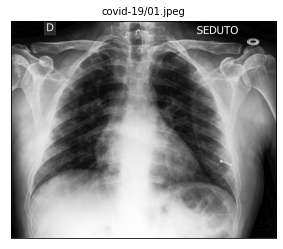

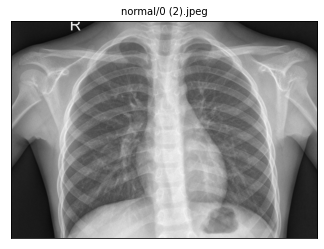

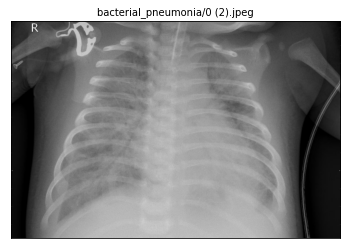

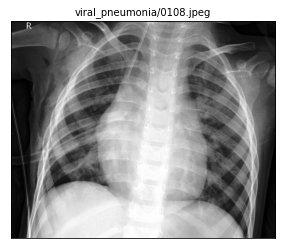

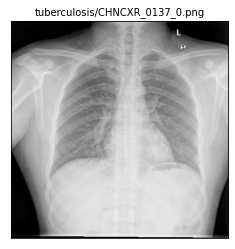

In [ ]:
# Displays first 1 images of class from training set
plot_defects_1("covid-19", 1, 1)
plot_defects_1("normal", 1, 1)
plot_defects_1("bacterial_pneumonia", 1, 1)
plot_defects_1("viral_pneumonia", 1, 1)
plot_defects_1("tuberculosis", 1, 1)

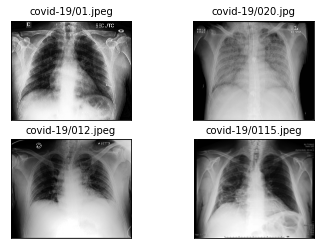

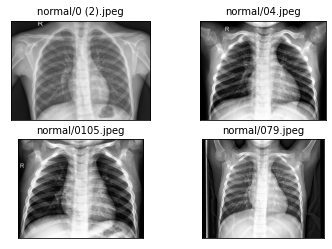

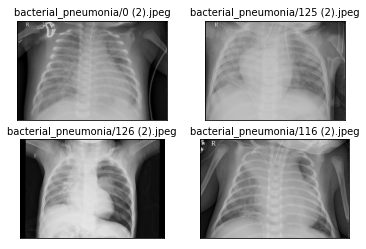

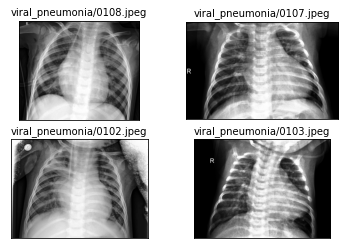

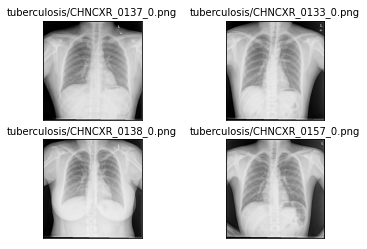

In [ ]:
# Displays first n images of class from training set
plot_defects("covid-19", 2, 2)
plot_defects("normal", 2, 2)
plot_defects("bacterial_pneumonia",2, 2)
plot_defects("viral_pneumonia", 2, 2)
plot_defects("tuberculosis", 2, 2)

#Data from the pickle files

In [ ]:
# rgb values / 255
import pickle as pkl

#to load it
with open("train_255_224.pkl", "rb") as f:
    X_train_255, Y_train = pkl.load(f)

with open("val_255_224.pkl", "rb") as f:
    X_val_255, Y_val = pkl.load(f)    
    
with open("test_255_224.pkl", "rb") as f:
    X_test_255, Y_test = pkl.load(f)

In [ ]:
## normalized data (0-1)

import pickle as pkl

#to load it
with open("train_224.pkl", "rb") as f:
    X_train, Y_train = pkl.load(f)

with open("val_224.pkl", "rb") as f:
    X_val, Y_val = pkl.load(f)
        
with open("test_224.pkl", "rb") as f:
    X_test, Y_test = pkl.load(f)

In [ ]:
# /255 divided + clahe

import pickle as pkl

#to load it
with open("train_CLAHE_255_224.pkl", "rb") as f:
    X_train_255_CLAHE, Y_train = pkl.load(f)

with open("val_CLAHE_255_224.pkl", "rb") as f:
    X_val_255_CLAHE, Y_val = pkl.load(f)    
    
with open("test_CLAHE_255_224.pkl", "rb") as f:
    X_test_255_CLAHE, Y_test = pkl.load(f)

In [ ]:
## normalized data (0-1 vals) + CLAHE preprocessing

import pickle as pkl

#to load it
with open("train_CLAHE_NORMALIZED_224.pkl", "rb") as f:
    X_train_CLAHE, Y_train = pkl.load(f)

with open("val_CLAHE_NORMALIZED_224.pkl", "rb") as f:
    X_val_CLAHE, Y_val = pkl.load(f)    
    
with open("test_CLAHE_NORMALIZED_224.pkl", "rb") as f:
    X_test_CLAHE, Y_test = pkl.load(f)

#Data for tuning from pickle files

In [ ]:
# rgb values / 255
import pickle as pkl

#to load it
with open("train_255_bigger.pkl", "rb") as f:
    X_train_255_ft, Y_train_ft = pkl.load(f)

with open("val_255_bigger.pkl", "rb") as f:
    X_val_255_ft, Y_val_ft = pkl.load(f)    
    
with open("test_255_224.pkl", "rb") as f:
    X_test_255, Y_test = pkl.load(f)

In [ ]:
## normalized data (0-1)

import pickle as pkl

#to load it
with open("train_bigger.pkl", "rb") as f:
    X_train_ft, Y_train_ft = pkl.load(f)

with open("val_bigger.pkl", "rb") as f:
    X_val_ft, Y_val_ft = pkl.load(f)
        
with open("test_224.pkl", "rb") as f:
    X_test, Y_test = pkl.load(f)

In [ ]:
# /255 divided + clahe

import pickle as pkl

#to load it
with open("train_CLAHE_255_bigger.pkl", "rb") as f:
    X_train_255_CLAHE_ft, Y_train_ft = pkl.load(f)

with open("val_CLAHE_255_bigger.pkl", "rb") as f:
    X_val_255_CLAHE_ft, Y_val_ft = pkl.load(f)    
    
with open("test_CLAHE_255_224.pkl", "rb") as f:
    X_test_255_CLAHE, Y_test = pkl.load(f)

In [ ]:
## normalized data (0-1 vals) + CLAHE preprocessing

import pickle as pkl

#to load it
with open("train_CLAHE_NORMALIZED_bigger.pkl", "rb") as f:
    X_train_CLAHE_ft, Y_train_ft = pkl.load(f)

with open("val_CLAHE_NORMALIZED_bigger.pkl", "rb") as f:
    X_val_CLAHE_ft, Y_val_ft = pkl.load(f)    
    
with open("test_CLAHE_NORMALIZED_224.pkl", "rb") as f:
    X_test_CLAHE, Y_test = pkl.load(f)

# NO AUGMENATION on data divided by 255

In [ ]:
model = build_ImageNetModel(MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-12:]:
    layer.trainable = True

optimizer = Adam(lr= lr, beta_1=0.9, beta_2=0.999, decay=lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)
print(lr)

layer 0: input_1, trainable: False
layer 1: Conv1, trainable: False
layer 2: bn_Conv1, trainable: False
layer 3: Conv1_relu, trainable: False
layer 4: expanded_conv_depthwise, trainable: False
layer 5: expanded_conv_depthwise_BN, trainable: False
layer 6: expanded_conv_depthwise_relu, trainable: False
layer 7: expanded_conv_project, trainable: False
layer 8: expanded_conv_project_BN, trainable: False
layer 9: block_1_expand, trainable: False
layer 10: block_1_expand_BN, trainable: False
layer 11: block_1_expand_relu, trainable: False
layer 12: block_1_pad, trainable: False
layer 13: block_1_depthwise, trainable: False
layer 14: block_1_depthwise_BN, trainable: False
layer 15: block_1_depthwise_relu, trainable: False
layer 16: block_1_project, trainable: False
layer 17: block_1_project_BN, trainable: False
layer 18: block_2_expand, trainable: False
layer 19: block_2_expand_BN, trainable: False
layer 20: block_2_expand_relu, trainable: False
layer 21: block_2_depthwise, trainable: False


In [ ]:
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('MobileNetV2 data scaled by 255.h5', verbose=2
                             ,save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
# Fits the model on batches
hist = model.fit(X_train_255, Y_train, batch_size=BATCH_SIZE, shuffle=True,
                 steps_per_epoch=X_train_255.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_255, Y_val)
                 )

Epoch 1/100
15/15 [==============================] - 6s 167ms/step - loss: 2.0444 - accuracy: 0.2440 - val_loss: 1.5523 - val_accuracy: 0.4720

Epoch 00001: val_loss improved from inf to 1.55231, saving model to MobileNetV2 data scaled by 255.h5
Epoch 2/100
15/15 [==============================] - 2s 105ms/step - loss: 1.5845 - accuracy: 0.3642 - val_loss: 1.0941 - val_accuracy: 0.5280

Epoch 00002: val_loss improved from 1.55231 to 1.09410, saving model to MobileNetV2 data scaled by 255.h5
Epoch 3/100
15/15 [==============================] - 1s 99ms/step - loss: 1.3235 - accuracy: 0.4495 - val_loss: 0.7985 - val_accuracy: 0.6880

Epoch 00003: val_loss improved from 1.09410 to 0.79847, saving model to MobileNetV2 data scaled by 255.h5
Epoch 4/100
15/15 [==============================] - 1s 100ms/step - loss: 1.2583 - accuracy: 0.5213 - val_loss: 0.6588 - val_accuracy: 0.7760

Epoch 00004: val_loss improved from 0.79847 to 0.65875, saving model to MobileNetV2 data scaled by 255.h5
Epoch

In [ ]:
# del model
model = load_model('MobileNetV2 data scaled by 255.h5')

final_loss, final_accuracy = model.evaluate(X_test_255, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after first training network head...")

predIdxs = model.predict(x=X_test_255,
	steps=(X_test_255.shape[0] // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(Y_true, predIdxs,target_names=categories))

4/4 [==============================] - 3s 492ms/step - loss: 0.3712 - accuracy: 0.8640
Final Loss: 0.37115079164505005, Final Accuracy: 0.8640000224113464
[INFO] evaluating after first training network head...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.82      0.72      0.77        25
           covid-19       1.00      0.96      0.98        25
             normal       0.77      0.96      0.86        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       0.77      0.68      0.72        25

           accuracy                           0.86       125
          macro avg       0.87      0.86      0.86       125
       weighted avg       0.87      0.86      0.86       125



Normalized confusion matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


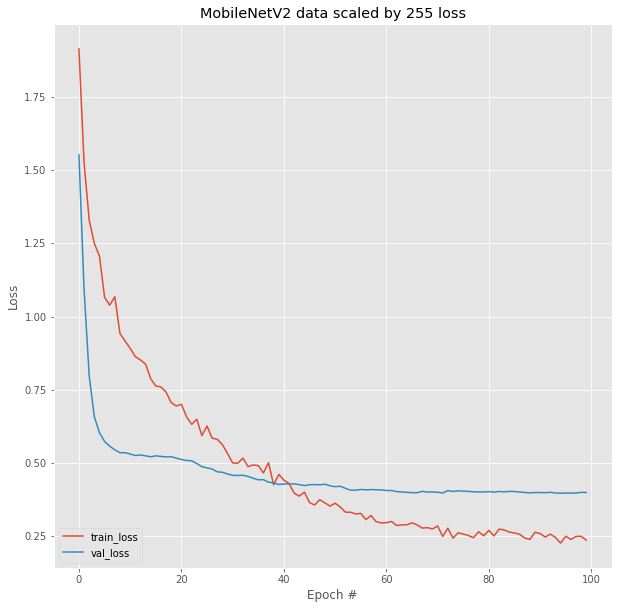

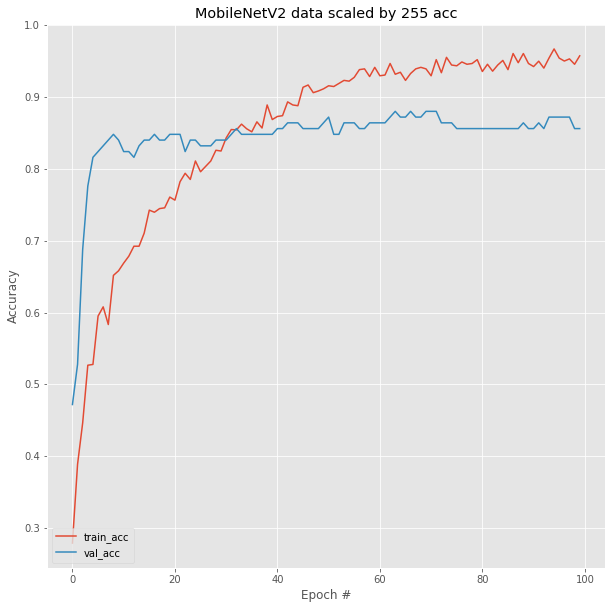

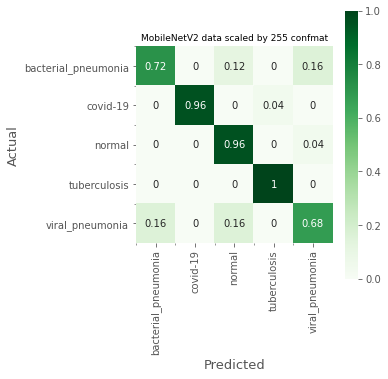

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'MobileNetV2 data scaled by 255 loss')
plot_acc(hist, hist.epoch[-1]+1, 'MobileNetV2 data scaled by 255 acc')
plot_confusion_matrix('MobileNetV2 data scaled by 255 confmat',Y_true, predIdxs, categories)

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


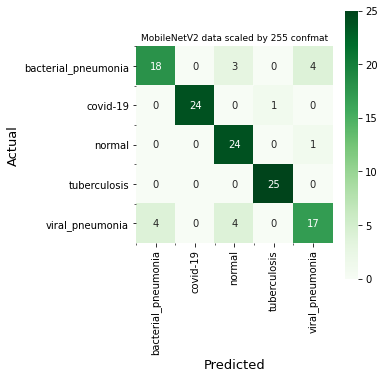

(125, 5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


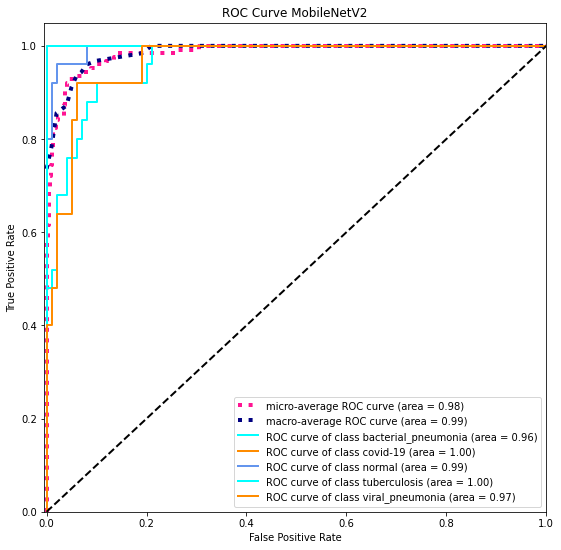

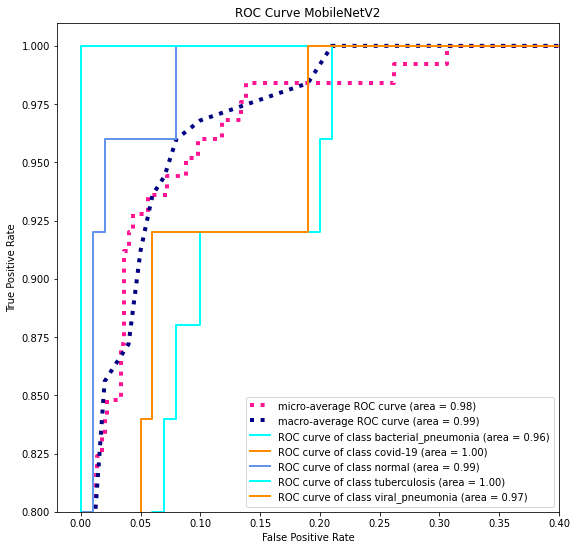

In [ ]:
plot_confusion_matrix('MobileNetV2 data scaled by 255 confmat',Y_true, predIdxs, categories)
predIdxs = model.predict(x=X_test_255,
	steps=(X_test_255.shape[0] // BATCH_SIZE) + 1)
print(predIdxs.shape)

plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve MobileNetV2')

#FineTuning

**FineTuning on data divided by 255**

In [ ]:
del model
model = load_model('MobileNetV2 data scaled by 255.h5')

In [ ]:
for layer in model.layers:
    layer.trainable = True

for layer in model.layers[:151]:
    layer.trainable = False

optimizer = Adam(lr= new_lr, beta_1=0.9, beta_2=0.999, decay=new_lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)
print(new_lr)

layer 0: input_1, trainable: False
layer 1: Conv1, trainable: False
layer 2: bn_Conv1, trainable: False
layer 3: Conv1_relu, trainable: False
layer 4: expanded_conv_depthwise, trainable: False
layer 5: expanded_conv_depthwise_BN, trainable: False
layer 6: expanded_conv_depthwise_relu, trainable: False
layer 7: expanded_conv_project, trainable: False
layer 8: expanded_conv_project_BN, trainable: False
layer 9: block_1_expand, trainable: False
layer 10: block_1_expand_BN, trainable: False
layer 11: block_1_expand_relu, trainable: False
layer 12: block_1_pad, trainable: False
layer 13: block_1_depthwise, trainable: False
layer 14: block_1_depthwise_BN, trainable: False
layer 15: block_1_depthwise_relu, trainable: False
layer 16: block_1_project, trainable: False
layer 17: block_1_project_BN, trainable: False
layer 18: block_2_expand, trainable: False
layer 19: block_2_expand_BN, trainable: False
layer 20: block_2_expand_relu, trainable: False
layer 21: block_2_depthwise, trainable: False


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
print(model.name)

annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('FineTuned MobileNetV2 data scaled by 255.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# Fits the model on batches
hist = model.fit(X_train_255_ft, Y_train_ft, batch_size=BATCH_SIZE, shuffle=True,
                 steps_per_epoch=X_train_255_ft.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint,es],
                 validation_data=(X_val_255_ft, Y_val_ft))

model
Epoch 1/100
37/37 [==============================] - 39s 145ms/step - loss: 0.5107 - accuracy: 0.8446 - val_loss: 0.2879 - val_accuracy: 0.9000

Epoch 00001: val_loss improved from inf to 0.28793, saving model to FineTuned MobileNetV2 data scaled by 255.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
37/37 [==============================] - 4s 103ms/step - loss: 0.4954 - accuracy: 0.8523 - val_loss: 0.2821 - val_accuracy: 0.9033

Epoch 00002: val_loss improved from 0.28793 to 0.28205, saving model to FineTuned MobileNetV2 data scaled by 255.h5
Epoch 3/100
37/37 [==============================] - 4s 102ms/step - loss: 0.4741 - accuracy: 0.8506 - val_loss: 0.2830 - val_accuracy: 0.9067

Epoch 00003: val_loss did not improve from 0.28205
Epoch 4/100
37/37 [==============================] - 4s 102ms/step - loss: 0.4364 - accuracy: 0.8720 - val_loss: 0.2852 - val_accuracy: 0.9133

Epoch 00004: val_loss did not improve from 0.28205
Epoch 5/100
37/37 [==============================] - 4s 105ms/step - loss: 0.4493 - accuracy: 0.8703 - val_loss: 0.2879 - val_accuracy: 0.9200

Epoch 00005: val_loss did not improve from 0.28205
Epoch 6/100
37/37 [==============================] - 4s 102ms/step - loss: 0.4406 - accuracy: 0.8711 - val_loss: 0.2882 - val_accuracy: 0.9200

Epoch 00006

In [ ]:
del model
model = load_model('FineTuned MobileNetV2 data scaled by 255.h5')
final_loss, final_accuracy = model.evaluate(X_test_255, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after fine tuning")
Y_pred = model.predict(x=X_test_255,
	steps=(X_test_255.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred,target_names=categories))

4/4 [==============================] - 1s 183ms/step - loss: 0.2652 - accuracy: 0.9120
Final Loss: 0.2652151584625244, Final Accuracy: 0.9120000004768372
[INFO] evaluating after fine tuning
                     precision    recall  f1-score   support

bacterial_pneumonia       0.90      0.76      0.83        25
           covid-19       1.00      0.96      0.98        25
             normal       0.89      0.96      0.92        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       0.81      0.88      0.85        25

           accuracy                           0.91       125
          macro avg       0.91      0.91      0.91       125
       weighted avg       0.91      0.91      0.91       125



Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


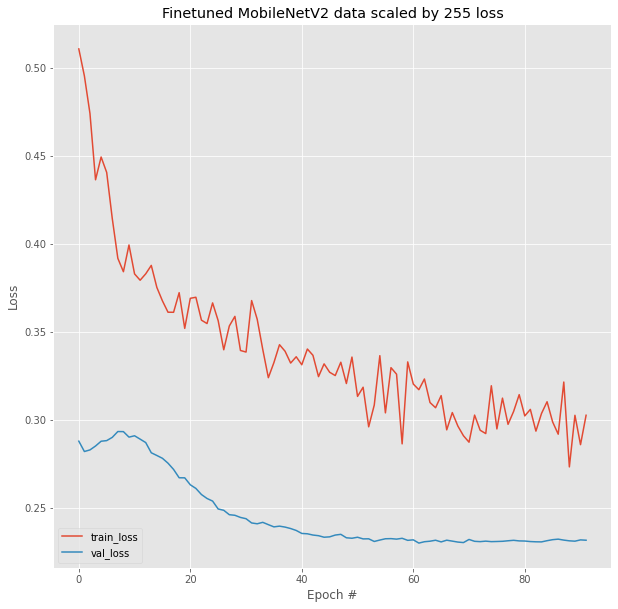

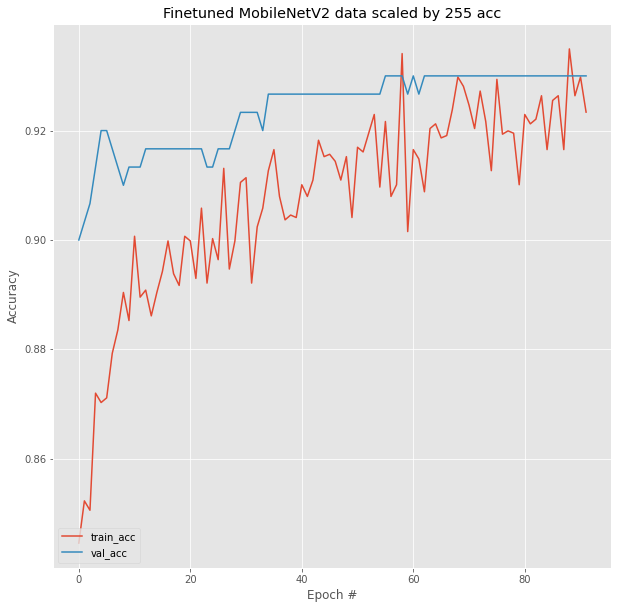

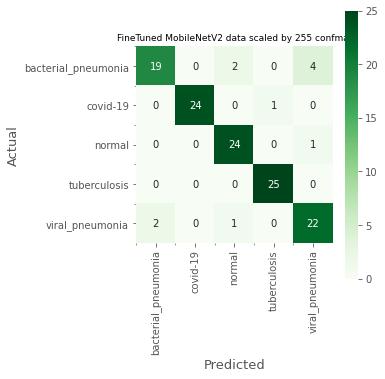

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'Finetuned MobileNetV2 data scaled by 255 loss')
plot_acc(hist, hist.epoch[-1]+1, 'Finetuned MobileNetV2 data scaled by 255 acc')
plot_confusion_matrix('FineTuned MobileNetV2 data scaled by 255 confmat',Y_true, Y_pred, categories)

(125, 5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


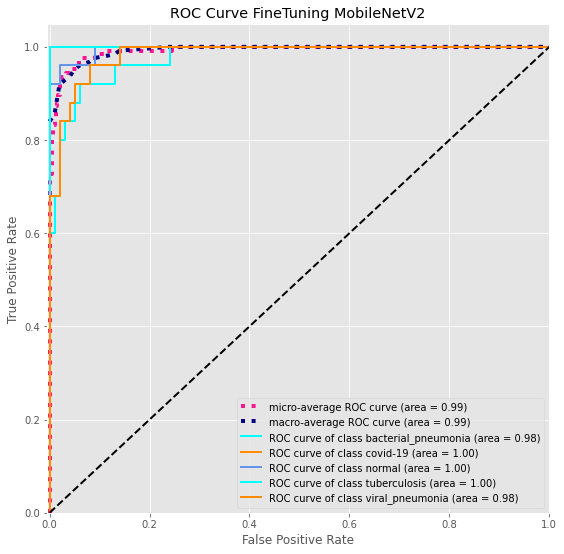

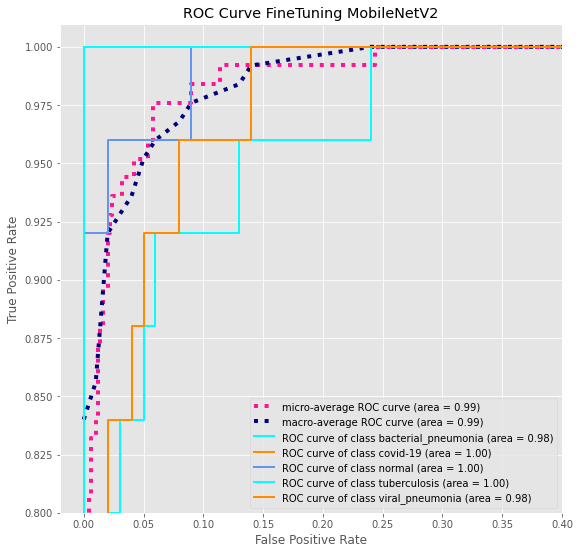

In [ ]:
predIdxs = model.predict(x=X_test_255,
	steps=(X_test_255.shape[0] // BATCH_SIZE) + 1)
print(predIdxs.shape)

plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve FineTuning MobileNetV2')

# NO AUGMENTATION on data normalized to (0-1)

**WITHOUT DATA AUGMENTATION TRAINING**

In [ ]:
del model
model = build_ImageNetModel(MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-12:]:
    layer.trainable = True

optimizer = Adam(lr= lr, beta_1=0.9, beta_2=0.999, decay=lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)
print(lr)

layer 0: input_1, trainable: False
layer 1: Conv1, trainable: False
layer 2: bn_Conv1, trainable: False
layer 3: Conv1_relu, trainable: False
layer 4: expanded_conv_depthwise, trainable: False
layer 5: expanded_conv_depthwise_BN, trainable: False
layer 6: expanded_conv_depthwise_relu, trainable: False
layer 7: expanded_conv_project, trainable: False
layer 8: expanded_conv_project_BN, trainable: False
layer 9: block_1_expand, trainable: False
layer 10: block_1_expand_BN, trainable: False
layer 11: block_1_expand_relu, trainable: False
layer 12: block_1_pad, trainable: False
layer 13: block_1_depthwise, trainable: False
layer 14: block_1_depthwise_BN, trainable: False
layer 15: block_1_depthwise_relu, trainable: False
layer 16: block_1_project, trainable: False
layer 17: block_1_project_BN, trainable: False
layer 18: block_2_expand, trainable: False
layer 19: block_2_expand_BN, trainable: False
layer 20: block_2_expand_relu, trainable: False
layer 21: block_2_depthwise, trainable: False


In [ ]:
annealer = ReduceLROnPlateau(monitor='val_loss',factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('MobileNetV2 normalized set.h5', verbose=1,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

# Fits the model on batches
hist = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, shuffle=True,
                 steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val, Y_val))


Epoch 1/100
15/15 [==============================] - 5s 165ms/step - loss: 1.9717 - accuracy: 0.2482 - val_loss: 1.0321 - val_accuracy: 0.6160

Epoch 00001: val_loss improved from inf to 1.03213, saving model to MobileNetV2 normalized set.h5
Epoch 2/100
15/15 [==============================] - 2s 107ms/step - loss: 1.3681 - accuracy: 0.4610 - val_loss: 0.7089 - val_accuracy: 0.7200

Epoch 00002: val_loss improved from 1.03213 to 0.70889, saving model to MobileNetV2 normalized set.h5
Epoch 3/100
15/15 [==============================] - 2s 101ms/step - loss: 1.3063 - accuracy: 0.4835 - val_loss: 0.5992 - val_accuracy: 0.7840

Epoch 00003: val_loss improved from 0.70889 to 0.59918, saving model to MobileNetV2 normalized set.h5
Epoch 4/100
15/15 [==============================] - 1s 101ms/step - loss: 1.0717 - accuracy: 0.5736 - val_loss: 0.5608 - val_accuracy: 0.8400

Epoch 00004: val_loss improved from 0.59918 to 0.56077, saving model to MobileNetV2 normalized set.h5
Epoch 5/100
15/15 [=

In [ ]:
del model
model = load_model('MobileNetV2 normalized set.h5')

final_loss, final_accuracy = model.evaluate(X_test, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after first training network head...")

predIdxs = model.predict(x=X_test,
	steps=(X_test.shape[0] // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(Y_true, predIdxs,target_names=categories))

4/4 [==============================] - 1s 100ms/step - loss: 0.3044 - accuracy: 0.9120
Final Loss: 0.3043653666973114, Final Accuracy: 0.9120000004768372
[INFO] evaluating after first training network head...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.83      0.80      0.82        25
           covid-19       1.00      0.96      0.98        25
             normal       0.92      0.96      0.94        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       0.84      0.84      0.84        25

           accuracy                           0.91       125
          macro avg       0.91      0.91      0.91       125
       weighted avg       0.91      0.91      0.91       125



Normalized confusion matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


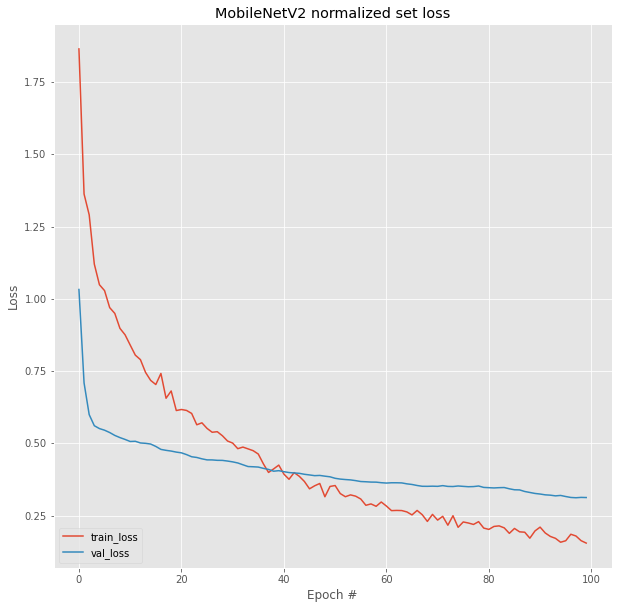

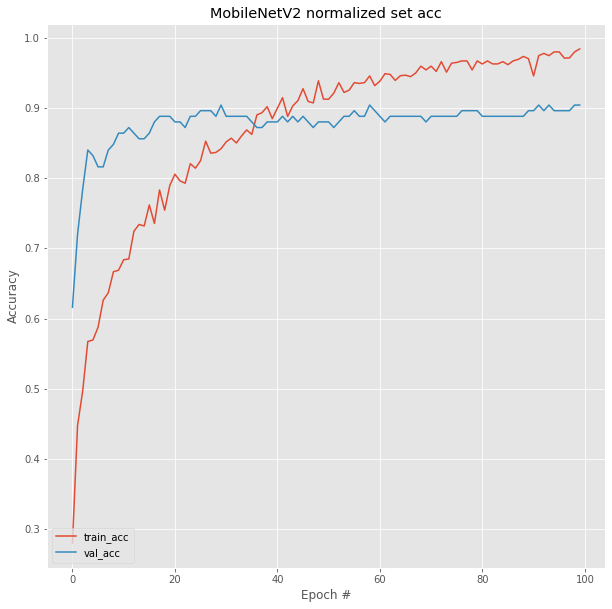

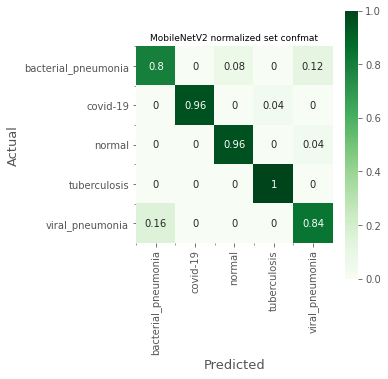

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'MobileNetV2 normalized set loss')
plot_acc(hist, hist.epoch[-1]+1, 'MobileNetV2 normalized set acc')
plot_confusion_matrix('MobileNetV2 normalized set confmat',Y_true, predIdxs, categories)

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


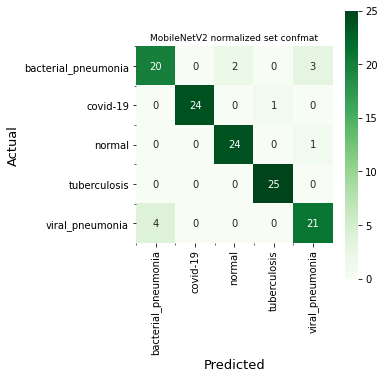

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


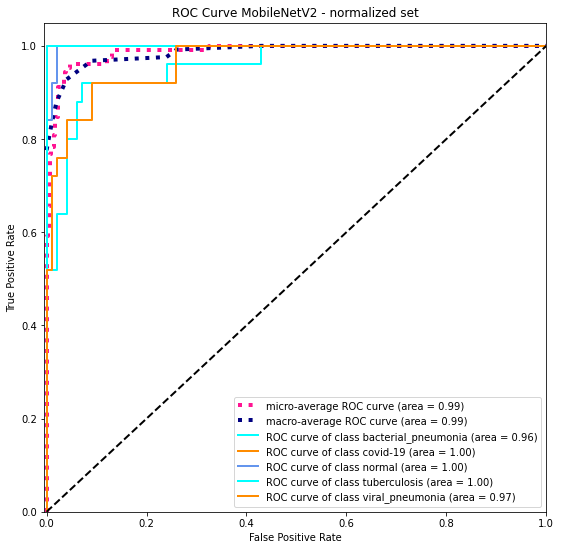

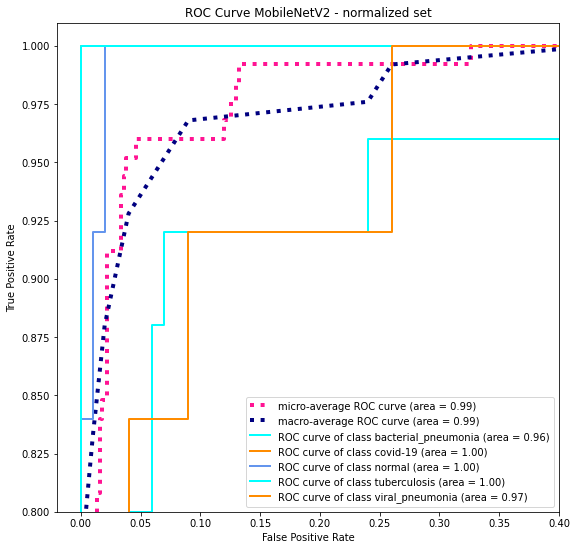

In [ ]:
plot_confusion_matrix('MobileNetV2 normalized set confmat',Y_true, predIdxs, categories)
predIdxs = model.predict(x=X_test,
	steps=(X_test.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve MobileNetV2 - normalized set')

#FineTuning

**FineTuning on normal data without hist equalization and without augmentation**

In [ ]:
# del model
model = load_model('MobileNetV2 normalized set.h5')

In [ ]:
for layer in model.layers:
    layer.trainable = True

for layer in model.layers[:151]:
    layer.trainable = False

optimizer = Adam(lr= lr, beta_1=0.9, beta_2=0.999, decay=lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)
print(lr)

layer 0: input_1, trainable: False
layer 1: Conv1, trainable: False
layer 2: bn_Conv1, trainable: False
layer 3: Conv1_relu, trainable: False
layer 4: expanded_conv_depthwise, trainable: False
layer 5: expanded_conv_depthwise_BN, trainable: False
layer 6: expanded_conv_depthwise_relu, trainable: False
layer 7: expanded_conv_project, trainable: False
layer 8: expanded_conv_project_BN, trainable: False
layer 9: block_1_expand, trainable: False
layer 10: block_1_expand_BN, trainable: False
layer 11: block_1_expand_relu, trainable: False
layer 12: block_1_pad, trainable: False
layer 13: block_1_depthwise, trainable: False
layer 14: block_1_depthwise_BN, trainable: False
layer 15: block_1_depthwise_relu, trainable: False
layer 16: block_1_project, trainable: False
layer 17: block_1_project_BN, trainable: False
layer 18: block_2_expand, trainable: False
layer 19: block_2_expand_BN, trainable: False
layer 20: block_2_expand_relu, trainable: False
layer 21: block_2_depthwise, trainable: False


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
print(model.name)

annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('FineTuned MobileNetV2 normalized set.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# Fits the model on batches
hist = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, shuffle=True,
                 steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint,es],
                 validation_data=(X_val, Y_val))

model
Epoch 1/100
37/37 [==============================] - 42s 254ms/step - loss: 0.4354 - accuracy: 0.8725 - val_loss: 0.2429 - val_accuracy: 0.9267

Epoch 00001: val_loss improved from inf to 0.24288, saving model to FineTuned MobileNetV2 normalized set.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
37/37 [==============================] - 8s 201ms/step - loss: 0.4230 - accuracy: 0.8801 - val_loss: 0.2471 - val_accuracy: 0.9100

Epoch 00002: val_loss did not improve from 0.24288
Epoch 3/100
37/37 [==============================] - 7s 201ms/step - loss: 0.3795 - accuracy: 0.8891 - val_loss: 0.2580 - val_accuracy: 0.9000

Epoch 00003: val_loss did not improve from 0.24288
Epoch 4/100
37/37 [==============================] - 7s 198ms/step - loss: 0.3498 - accuracy: 0.8887 - val_loss: 0.2602 - val_accuracy: 0.9000

Epoch 00004: val_loss did not improve from 0.24288
Epoch 5/100
37/37 [==============================] - 7s 197ms/step - loss: 0.3541 - accuracy: 0.8908 - val_loss: 0.2781 - val_accuracy: 0.8967

Epoch 00005: val_loss did not improve from 0.24288
Epoch 6/100
37/37 [==============================] - 7s 198ms/step - loss: 0.3261 - accuracy: 0.9041 - val_loss: 0.2816 - val_accuracy: 0.9000

Epoch 00006: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-

In [ ]:
del model
model = load_model('FineTuned MobileNetV2 normalized set.h5')
final_loss, final_accuracy = model.evaluate(X_test, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

# predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after fine tuning...")

Y_pred = model.predict(x=X_test,
	steps=(X_test.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred, target_names=categories))

4/4 [==============================] - 29s 268ms/step - loss: 0.2581 - accuracy: 0.9200
Final Loss: 0.2580869197845459, Final Accuracy: 0.9200000166893005
[INFO] evaluating after fine tuning...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.87      0.80      0.83        25
           covid-19       1.00      0.92      0.96        25
             normal       0.92      0.96      0.94        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       0.85      0.92      0.88        25

           accuracy                           0.92       125
          macro avg       0.92      0.92      0.92       125
       weighted avg       0.92      0.92      0.92       125



Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


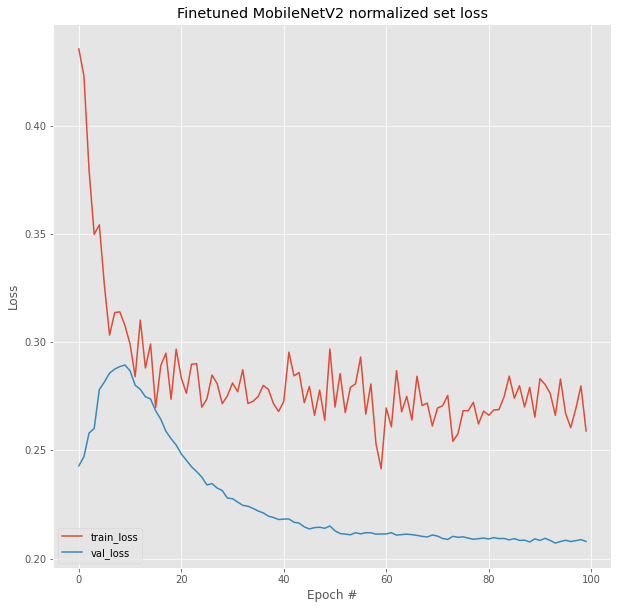

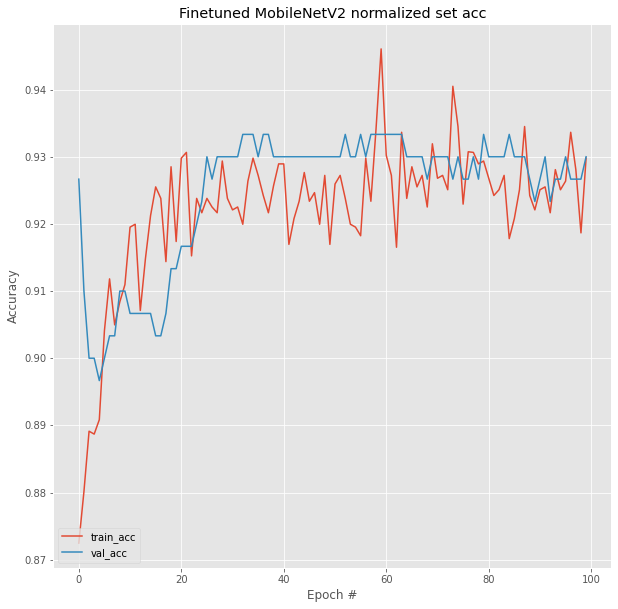

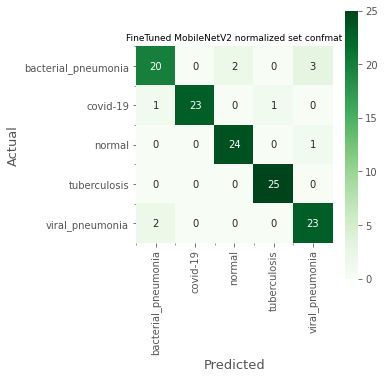

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'Finetuned MobileNetV2 normalized set loss')
plot_acc(hist, hist.epoch[-1]+1, 'Finetuned MobileNetV2 normalized set acc')
plot_confusion_matrix('FineTuned MobileNetV2 normalized set confmat',Y_true, Y_pred, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


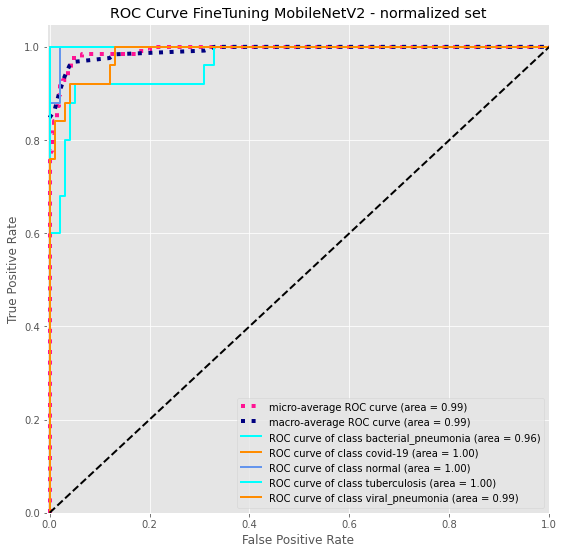

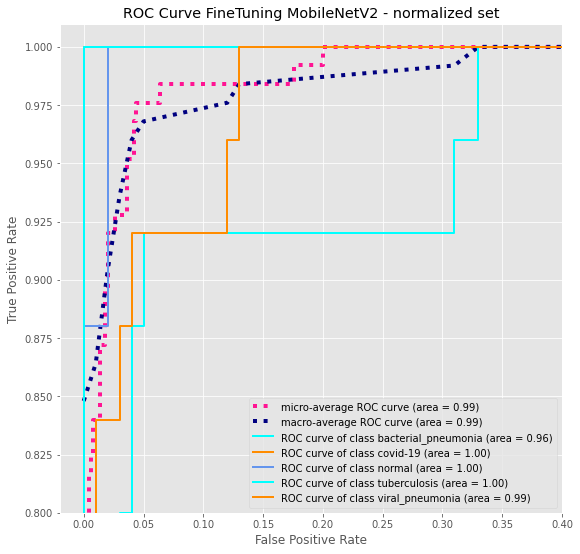

In [ ]:
predIdxs = model.predict(x=X_test,
	steps=(X_test.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve FineTuning MobileNetV2 - normalized set')

# NO AUGMENTATION on data divided by 255 + CLAHE processed

**After CLAHE processing without data augmentation**

In [ ]:
del model
model = build_ImageNetModel(MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-12:]:
    layer.trainable = True

optimizer = Adam(lr= lr, beta_1=0.9, beta_2=0.999, decay=lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)

layer 0: input_1, trainable: False
layer 1: Conv1, trainable: False
layer 2: bn_Conv1, trainable: False
layer 3: Conv1_relu, trainable: False
layer 4: expanded_conv_depthwise, trainable: False
layer 5: expanded_conv_depthwise_BN, trainable: False
layer 6: expanded_conv_depthwise_relu, trainable: False
layer 7: expanded_conv_project, trainable: False
layer 8: expanded_conv_project_BN, trainable: False
layer 9: block_1_expand, trainable: False
layer 10: block_1_expand_BN, trainable: False
layer 11: block_1_expand_relu, trainable: False
layer 12: block_1_pad, trainable: False
layer 13: block_1_depthwise, trainable: False
layer 14: block_1_depthwise_BN, trainable: False
layer 15: block_1_depthwise_relu, trainable: False
layer 16: block_1_project, trainable: False
layer 17: block_1_project_BN, trainable: False
layer 18: block_2_expand, trainable: False
layer 19: block_2_expand_BN, trainable: False
layer 20: block_2_expand_relu, trainable: False
layer 21: block_2_depthwise, trainable: False


In [ ]:
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('MobileNetV2 CLAHE set.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

# Fits the model on batches
hist = model.fit(X_train_255_CLAHE, Y_train, batch_size=BATCH_SIZE, shuffle=True,
                 steps_per_epoch=X_train_255_CLAHE.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_255_CLAHE, Y_val))


Epoch 1/100
15/15 [==============================] - 5s 135ms/step - loss: 2.1444 - accuracy: 0.2148 - val_loss: 1.2168 - val_accuracy: 0.3680

Epoch 00001: val_loss improved from inf to 1.21681, saving model to MobileNetV2 CLAHE set.h5
Epoch 2/100
15/15 [==============================] - 1s 75ms/step - loss: 1.5303 - accuracy: 0.3949 - val_loss: 0.8758 - val_accuracy: 0.6560

Epoch 00002: val_loss improved from 1.21681 to 0.87582, saving model to MobileNetV2 CLAHE set.h5
Epoch 3/100
15/15 [==============================] - 1s 74ms/step - loss: 1.4064 - accuracy: 0.4289 - val_loss: 0.7374 - val_accuracy: 0.7600

Epoch 00003: val_loss improved from 0.87582 to 0.73735, saving model to MobileNetV2 CLAHE set.h5
Epoch 4/100
15/15 [==============================] - 1s 72ms/step - loss: 1.2829 - accuracy: 0.4872 - val_loss: 0.6825 - val_accuracy: 0.7680

Epoch 00004: val_loss improved from 0.73735 to 0.68252, saving model to MobileNetV2 CLAHE set.h5
Epoch 5/100
15/15 [========================

4/4 [==============================] - 3s 478ms/step - loss: 0.3888 - accuracy: 0.8800
Final Loss: 0.38882043957710266, Final Accuracy: 0.8799999952316284
[INFO] evaluating after first training network head...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.84      0.64      0.73        25
           covid-19       1.00      0.96      0.98        25
             normal       0.78      1.00      0.88        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       0.83      0.80      0.82        25

           accuracy                           0.88       125
          macro avg       0.88      0.88      0.88       125
       weighted avg       0.88      0.88      0.88       125

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


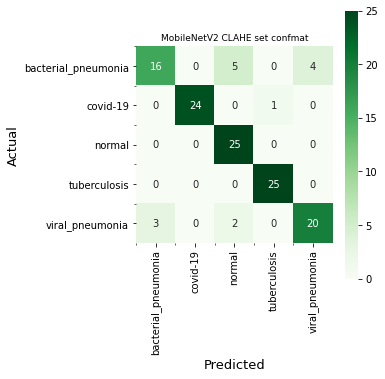

In [ ]:
del model
model = load_model('MobileNetV2 CLAHE set.h5')

final_loss, final_accuracy = model.evaluate(X_test_255_CLAHE, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after first training network head...")

predIdxs = model.predict(x=X_test_255_CLAHE,
	steps=(X_test_255_CLAHE.shape[0] // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(Y_true, predIdxs,target_names=categories))
plot_confusion_matrix('MobileNetV2 CLAHE set confmat',Y_true, predIdxs, categories)

Normalized confusion matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


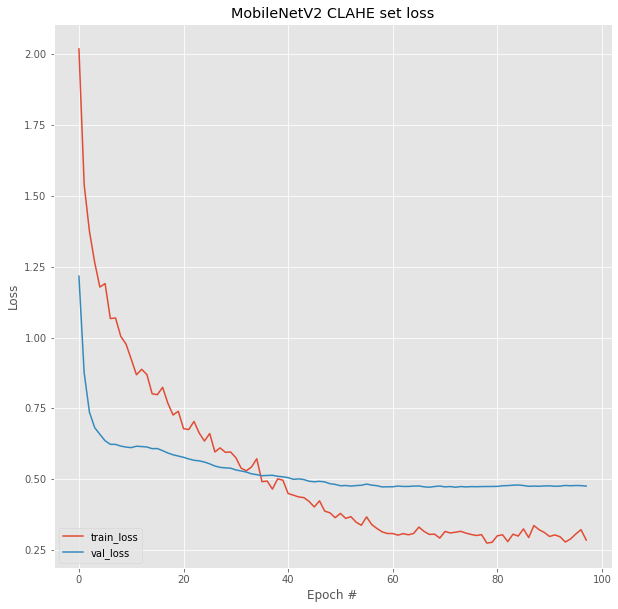

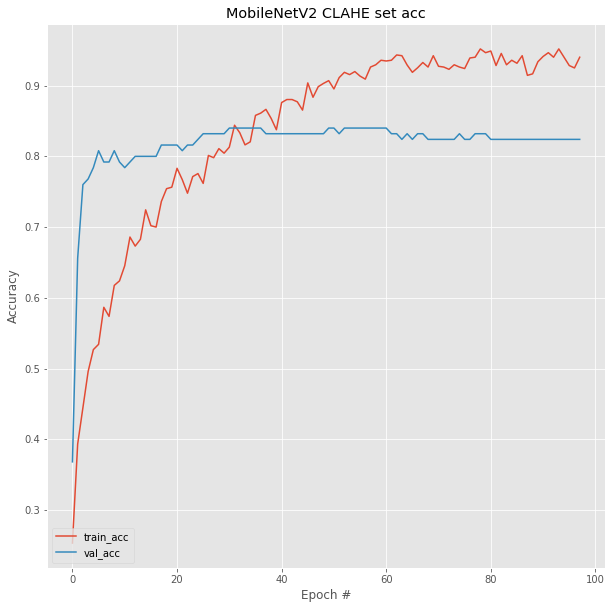

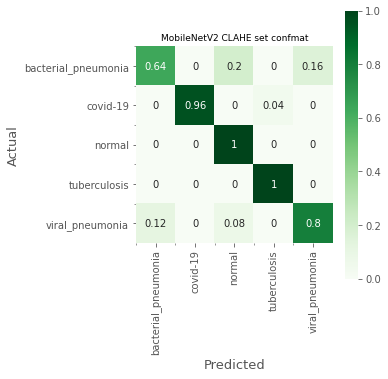

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'MobileNetV2 CLAHE set loss')
plot_acc(hist, hist.epoch[-1]+1, 'MobileNetV2 CLAHE set acc')
plot_confusion_matrix('MobileNetV2 CLAHE set confmat',Y_true, predIdxs, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


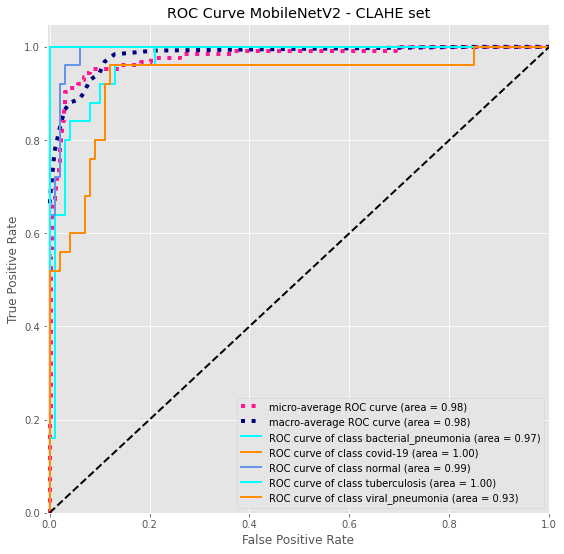

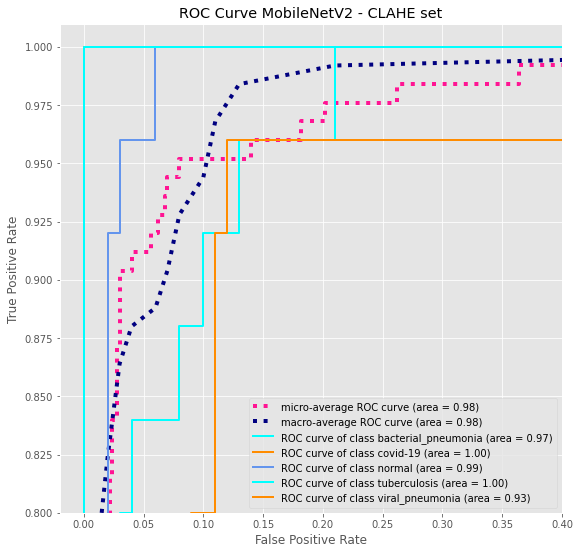

In [ ]:
predIdxs = model.predict(x=X_test_255,
	steps=(X_test_255.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve MobileNetV2 - CLAHE set')

#FineTuning

**FineTuning on CLAHE and /255**

In [ ]:
del model
model = load_model('MobileNetV2 CLAHE set.h5')

In [ ]:
for layer in model.layers:
    layer.trainable = True

for layer in model.layers[:151]:
    layer.trainable = False

optimizer = Adam(lr= new_lr, beta_1=0.9, beta_2=0.999, decay=new_lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)

print(optimizer.learning_rate)

layer 0: input_1, trainable: False
layer 1: Conv1, trainable: False
layer 2: bn_Conv1, trainable: False
layer 3: Conv1_relu, trainable: False
layer 4: expanded_conv_depthwise, trainable: False
layer 5: expanded_conv_depthwise_BN, trainable: False
layer 6: expanded_conv_depthwise_relu, trainable: False
layer 7: expanded_conv_project, trainable: False
layer 8: expanded_conv_project_BN, trainable: False
layer 9: block_1_expand, trainable: False
layer 10: block_1_expand_BN, trainable: False
layer 11: block_1_expand_relu, trainable: False
layer 12: block_1_pad, trainable: False
layer 13: block_1_depthwise, trainable: False
layer 14: block_1_depthwise_BN, trainable: False
layer 15: block_1_depthwise_relu, trainable: False
layer 16: block_1_project, trainable: False
layer 17: block_1_project_BN, trainable: False
layer 18: block_2_expand, trainable: False
layer 19: block_2_expand_BN, trainable: False
layer 20: block_2_expand_relu, trainable: False
layer 21: block_2_depthwise, trainable: False


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
print(model.name)

annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('FineTuned MobileNetV2 CLAHE set.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# Fits the model on batches
hist = model.fit(X_train_255_CLAHE_ft, Y_train_ft, batch_size=BATCH_SIZE, shuffle=True,
                 steps_per_epoch=X_train_255_CLAHE_ft.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_255_CLAHE_ft, Y_val_ft))



model
Epoch 1/100
37/37 [==============================] - 43s 249ms/step - loss: 0.5936 - accuracy: 0.8205 - val_loss: 0.2905 - val_accuracy: 0.9267

Epoch 00001: val_loss improved from inf to 0.29053, saving model to FineTuned MobileNetV2 CLAHE set.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
37/37 [==============================] - 8s 200ms/step - loss: 0.5208 - accuracy: 0.8425 - val_loss: 0.2897 - val_accuracy: 0.9167

Epoch 00002: val_loss improved from 0.29053 to 0.28973, saving model to FineTuned MobileNetV2 CLAHE set.h5
Epoch 3/100
37/37 [==============================] - 7s 199ms/step - loss: 0.5074 - accuracy: 0.8480 - val_loss: 0.2907 - val_accuracy: 0.9233

Epoch 00003: val_loss did not improve from 0.28973
Epoch 4/100
37/37 [==============================] - 7s 198ms/step - loss: 0.4962 - accuracy: 0.8579 - val_loss: 0.2888 - val_accuracy: 0.9167

Epoch 00004: val_loss improved from 0.28973 to 0.28885, saving model to FineTuned MobileNetV2 CLAHE set.h5
Epoch 5/100
37/37 [==============================] - 7s 198ms/step - loss: 0.5018 - accuracy: 0.8399 - val_loss: 0.2948 - val_accuracy: 0.9133

Epoch 00005: val_loss did not improve from 0.28885
Epoch 6/100
37/37 [==============================] - 8s 214ms/step - loss: 0.4817 - accuracy: 0.8545 - val_l

In [ ]:
del model
model = load_model('FineTuned MobileNetV2 CLAHE set.h5')
final_loss, final_accuracy = model.evaluate(X_test_255_CLAHE, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after fine tuning...")

Y_pred = model.predict(x=X_test_255_CLAHE,
	steps=(X_test_255_CLAHE.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred, target_names=categories))

4/4 [==============================] - 1s 98ms/step - loss: 0.2691 - accuracy: 0.8960
Final Loss: 0.2690908908843994, Final Accuracy: 0.8960000276565552
[INFO] evaluating after fine tuning...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.85      0.68      0.76        25
           covid-19       1.00      0.96      0.98        25
             normal       0.86      1.00      0.93        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       0.81      0.84      0.82        25

           accuracy                           0.90       125
          macro avg       0.90      0.90      0.89       125
       weighted avg       0.90      0.90      0.89       125



Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


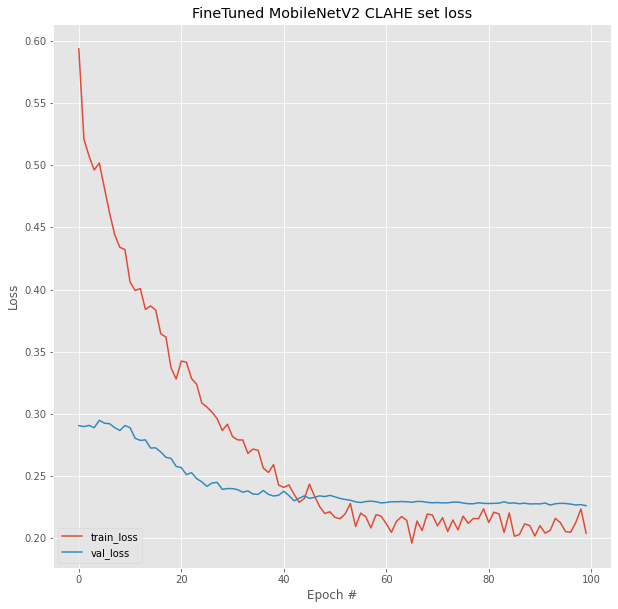

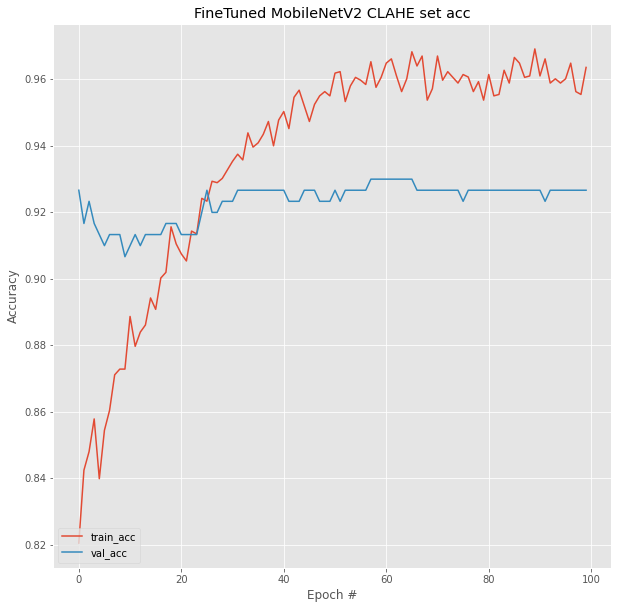

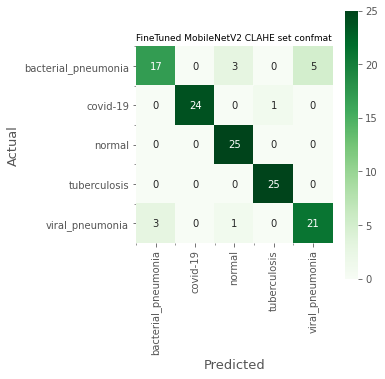

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'FineTuned MobileNetV2 CLAHE set loss')
plot_acc(hist, hist.epoch[-1]+1, 'FineTuned MobileNetV2 CLAHE set acc')
plot_confusion_matrix('FineTuned MobileNetV2 CLAHE set confmat',Y_true, Y_pred, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


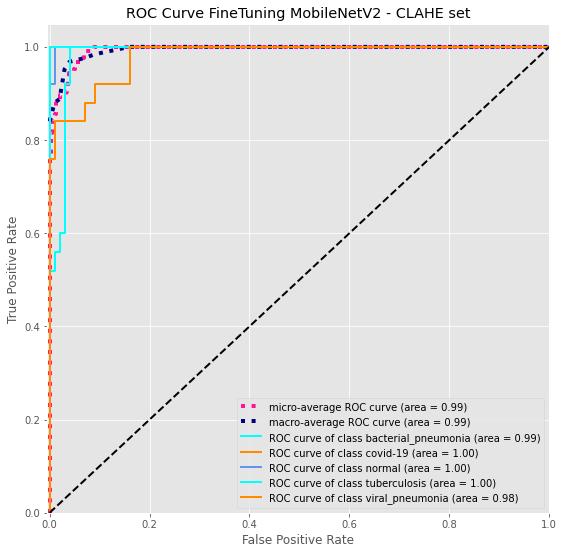

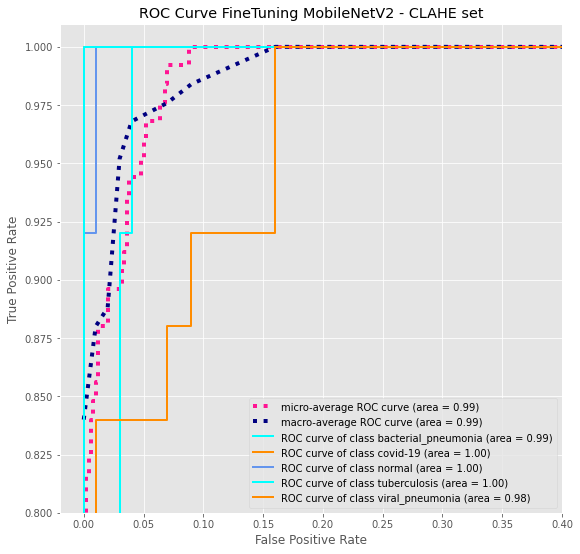

In [ ]:
predIdxs = model.predict(x=X_test_255_CLAHE,
	steps=(X_test_255_CLAHE.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve FineTuning MobileNetV2 - CLAHE set')

# NO AUGMENTATION on data normalized to (0-1) + CLAHE processed

**After CLAHE processing without data augmentation**

In [ ]:
del model
model = build_ImageNetModel(MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-12:]:
    layer.trainable = True

optimizer = Adam(lr= lr, beta_1=0.9, beta_2=0.999, decay=lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)

layer 0: input_1, trainable: False
layer 1: Conv1, trainable: False
layer 2: bn_Conv1, trainable: False
layer 3: Conv1_relu, trainable: False
layer 4: expanded_conv_depthwise, trainable: False
layer 5: expanded_conv_depthwise_BN, trainable: False
layer 6: expanded_conv_depthwise_relu, trainable: False
layer 7: expanded_conv_project, trainable: False
layer 8: expanded_conv_project_BN, trainable: False
layer 9: block_1_expand, trainable: False
layer 10: block_1_expand_BN, trainable: False
layer 11: block_1_expand_relu, trainable: False
layer 12: block_1_pad, trainable: False
layer 13: block_1_depthwise, trainable: False
layer 14: block_1_depthwise_BN, trainable: False
layer 15: block_1_depthwise_relu, trainable: False
layer 16: block_1_project, trainable: False
layer 17: block_1_project_BN, trainable: False
layer 18: block_2_expand, trainable: False
layer 19: block_2_expand_BN, trainable: False
layer 20: block_2_expand_relu, trainable: False
layer 21: block_2_depthwise, trainable: False


In [ ]:
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('MobileNetV2 CLAHE + normalized set.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

# Fits the model on batches
hist = model.fit(X_train_CLAHE, Y_train, batch_size=BATCH_SIZE, shuffle=True,
                 steps_per_epoch=X_train_CLAHE.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_CLAHE, Y_val))

Epoch 1/100
15/15 [==============================] - 5s 141ms/step - loss: 2.0451 - accuracy: 0.2237 - val_loss: 0.9607 - val_accuracy: 0.6320

Epoch 00001: val_loss improved from inf to 0.96072, saving model to MobileNetV2 CLAHE + normalized set.h5
Epoch 2/100
15/15 [==============================] - 1s 76ms/step - loss: 1.5306 - accuracy: 0.4169 - val_loss: 0.7789 - val_accuracy: 0.7280

Epoch 00002: val_loss improved from 0.96072 to 0.77886, saving model to MobileNetV2 CLAHE + normalized set.h5
Epoch 3/100
15/15 [==============================] - 1s 71ms/step - loss: 1.4256 - accuracy: 0.4555 - val_loss: 0.7190 - val_accuracy: 0.7680

Epoch 00003: val_loss improved from 0.77886 to 0.71899, saving model to MobileNetV2 CLAHE + normalized set.h5
Epoch 4/100
15/15 [==============================] - 1s 74ms/step - loss: 1.2118 - accuracy: 0.5251 - val_loss: 0.6821 - val_accuracy: 0.8000

Epoch 00004: val_loss improved from 0.71899 to 0.68210, saving model to MobileNetV2 CLAHE + normalize

4/4 [==============================] - 3s 475ms/step - loss: 0.3483 - accuracy: 0.8800
Final Loss: 0.3483087122440338, Final Accuracy: 0.8799999952316284
[INFO] evaluating after first training network head...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.86      0.76      0.81        25
           covid-19       1.00      0.88      0.94        25
             normal       0.86      0.96      0.91        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       0.74      0.80      0.77        25

           accuracy                           0.88       125
          macro avg       0.88      0.88      0.88       125
       weighted avg       0.88      0.88      0.88       125

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


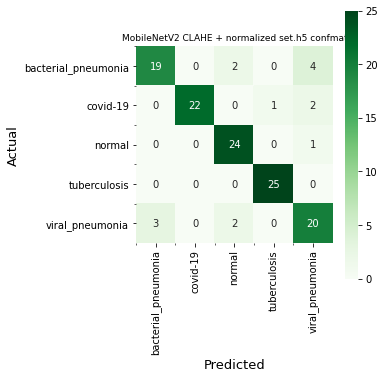

In [ ]:
del model
model = load_model('MobileNetV2 CLAHE + normalized set.h5')

final_loss, final_accuracy = model.evaluate(X_test_CLAHE, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after first training network head...")

predIdxs = model.predict(x=X_test_CLAHE,
	steps=(X_test_CLAHE.shape[0] // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(Y_true, predIdxs,target_names=categories))

plot_confusion_matrix('MobileNetV2 CLAHE + normalized set.h5 confmat',Y_true, predIdxs, categories)

Normalized confusion matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


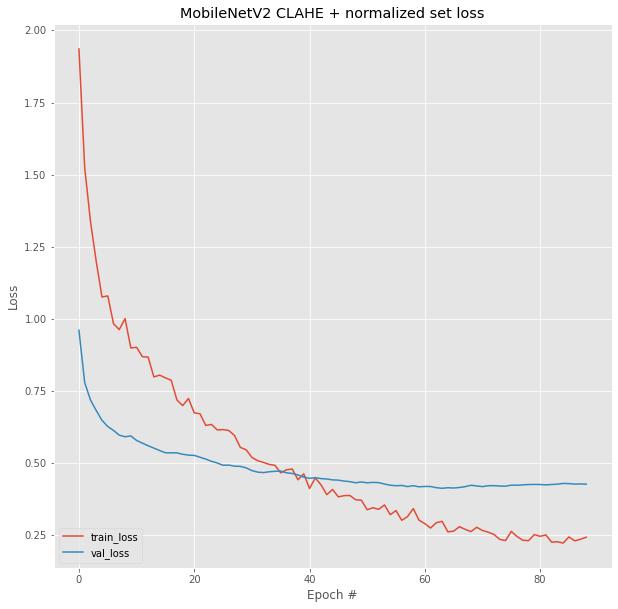

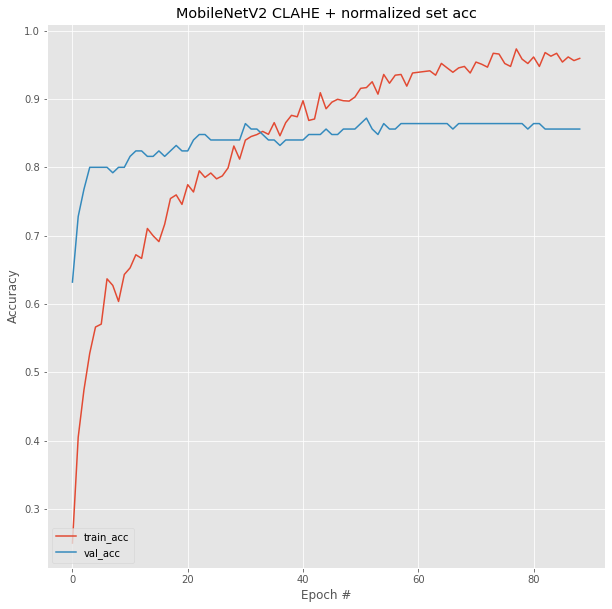

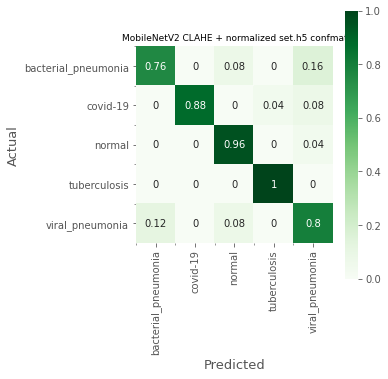

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'MobileNetV2 CLAHE + normalized set loss')
plot_acc(hist, hist.epoch[-1]+1, 'MobileNetV2 CLAHE + normalized set acc')
plot_confusion_matrix('MobileNetV2 CLAHE + normalized set.h5 confmat',Y_true, predIdxs, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


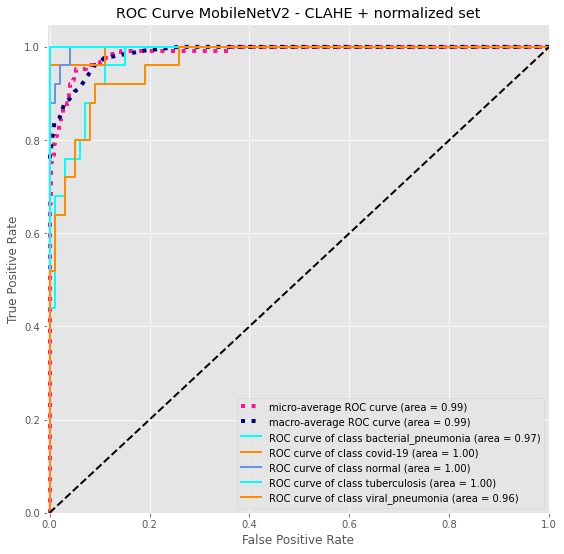

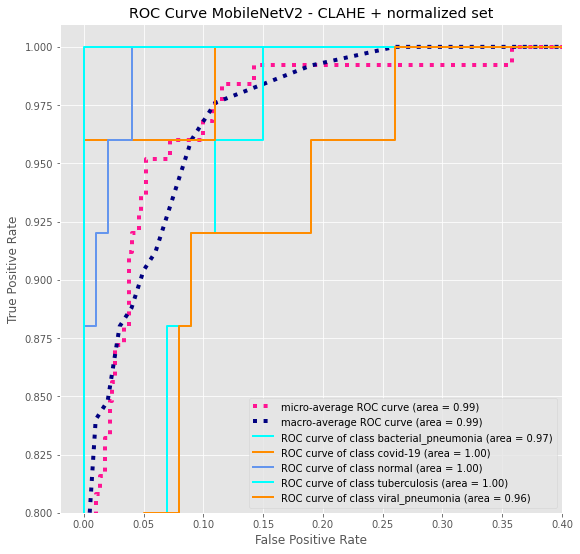

In [ ]:
predIdxs = model.predict(x=X_test_CLAHE,
	steps=(X_test_CLAHE.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve MobileNetV2 - CLAHE + normalized set')

#FineTuning

**FineTuning MobileNetV2 on normal data without hist equalization and without augmentation**

In [ ]:
# del model
model = load_model('MobileNetV2 CLAHE + normalized set.h5')

In [ ]:
for layer in model.layers:
    layer.trainable = True
for layer in model.layers[:151]:
    layer.trainable = False


optimizer = Adam(lr= new_lr, beta_1=0.9, beta_2=0.999, decay=new_lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)

print(optimizer.learning_rate)

layer 0: input_1, trainable: False
layer 1: Conv1, trainable: False
layer 2: bn_Conv1, trainable: False
layer 3: Conv1_relu, trainable: False
layer 4: expanded_conv_depthwise, trainable: False
layer 5: expanded_conv_depthwise_BN, trainable: False
layer 6: expanded_conv_depthwise_relu, trainable: False
layer 7: expanded_conv_project, trainable: False
layer 8: expanded_conv_project_BN, trainable: False
layer 9: block_1_expand, trainable: False
layer 10: block_1_expand_BN, trainable: False
layer 11: block_1_expand_relu, trainable: False
layer 12: block_1_pad, trainable: False
layer 13: block_1_depthwise, trainable: False
layer 14: block_1_depthwise_BN, trainable: False
layer 15: block_1_depthwise_relu, trainable: False
layer 16: block_1_project, trainable: False
layer 17: block_1_project_BN, trainable: False
layer 18: block_2_expand, trainable: False
layer 19: block_2_expand_BN, trainable: False
layer 20: block_2_expand_relu, trainable: False
layer 21: block_2_depthwise, trainable: False


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
print(model.name)

annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('FineTuned MobileNetV2 CLAHE + normalized set.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# Fits the model on batches
hist = model.fit(X_train_CLAHE_ft, Y_train_ft, batch_size=BATCH_SIZE, shuffle=True,
                 steps_per_epoch=X_train_CLAHE_ft.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_CLAHE_ft, Y_val_ft))

model
Epoch 1/100
37/37 [==============================] - 43s 259ms/step - loss: 0.5050 - accuracy: 0.8480 - val_loss: 0.2533 - val_accuracy: 0.9200

Epoch 00001: val_loss improved from inf to 0.25335, saving model to FineTuned MobileNetV2 CLAHE + normalized set.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
37/37 [==============================] - 8s 200ms/step - loss: 0.4889 - accuracy: 0.8527 - val_loss: 0.2536 - val_accuracy: 0.9167

Epoch 00002: val_loss did not improve from 0.25335
Epoch 3/100
37/37 [==============================] - 7s 202ms/step - loss: 0.4862 - accuracy: 0.8485 - val_loss: 0.2556 - val_accuracy: 0.9167

Epoch 00003: val_loss did not improve from 0.25335
Epoch 4/100
37/37 [==============================] - 7s 198ms/step - loss: 0.4732 - accuracy: 0.8574 - val_loss: 0.2587 - val_accuracy: 0.9167

Epoch 00004: val_loss did not improve from 0.25335
Epoch 5/100
37/37 [==============================] - 7s 198ms/step - loss: 0.4384 - accuracy: 0.8669 - val_loss: 0.2603 - val_accuracy: 0.9167

Epoch 00005: val_loss did not improve from 0.25335
Epoch 6/100
37/37 [==============================] - 7s 198ms/step - loss: 0.4560 - accuracy: 0.8647 - val_loss: 0.2622 - val_accuracy: 0.9133

Epoch 00006: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-

In [ ]:
del model
model = load_model('FineTuned MobileNetV2 CLAHE + normalized set.h5')
final_loss, final_accuracy = model.evaluate(X_test_CLAHE, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after fine tuning...")
Y_pred = model.predict(x=X_test_CLAHE,
	steps=(X_test_CLAHE.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred, target_names=categories))

4/4 [==============================] - 1s 100ms/step - loss: 0.2849 - accuracy: 0.8880
Final Loss: 0.28491929173469543, Final Accuracy: 0.8880000114440918
[INFO] evaluating after fine tuning...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.82      0.72      0.77        25
           covid-19       1.00      0.92      0.96        25
             normal       0.96      0.96      0.96        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       0.72      0.84      0.78        25

           accuracy                           0.89       125
          macro avg       0.89      0.89      0.89       125
       weighted avg       0.89      0.89      0.89       125



Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


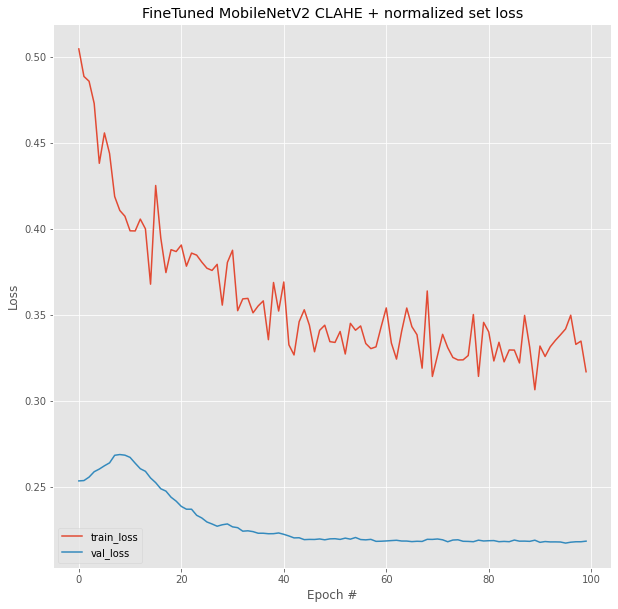

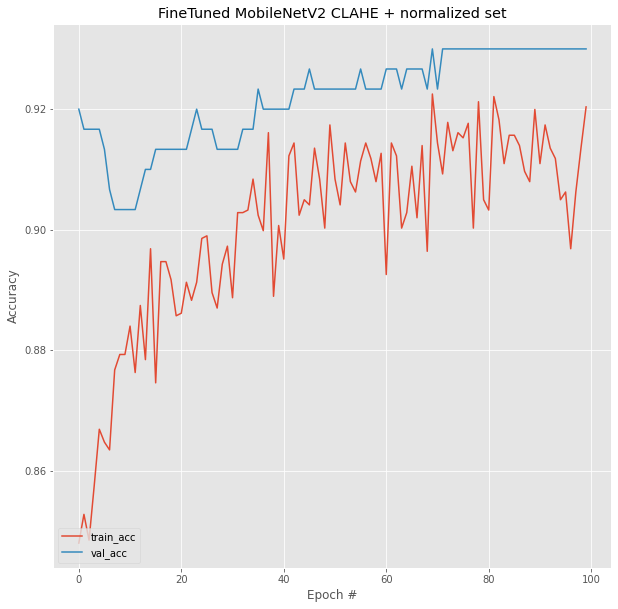

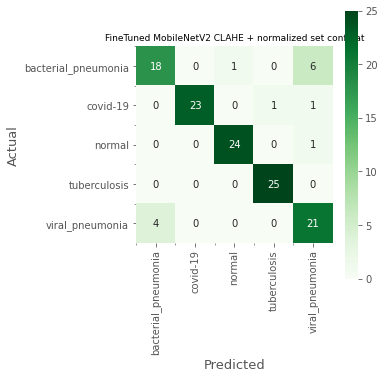

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'FineTuned MobileNetV2 CLAHE + normalized set loss')
plot_acc(hist, hist.epoch[-1]+1, 'FineTuned MobileNetV2 CLAHE + normalized set')
plot_confusion_matrix('FineTuned MobileNetV2 CLAHE + normalized set confmat',Y_true, Y_pred, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


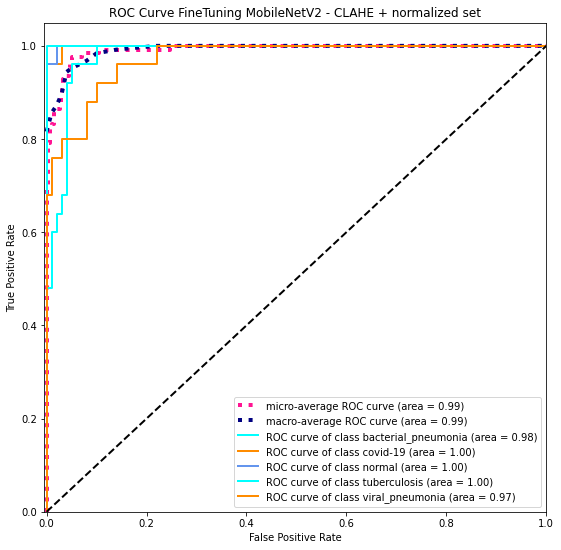

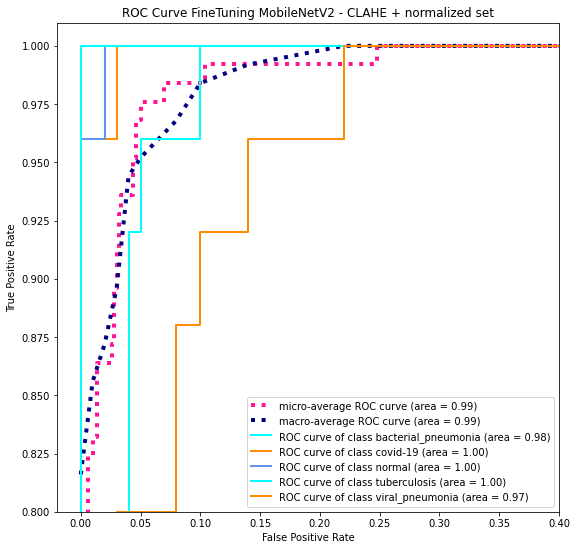

In [ ]:
predIdxs = model.predict(x=X_test_CLAHE,
	steps=(X_test_CLAHE.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve FineTuning MobileNetV2 - CLAHE + normalized set')

# AUGMENTATION on data divided by 255

In [ ]:
del model
model = build_ImageNetModel(MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-12:]:
    layer.trainable = True

optimizer = Adam(lr= lr, beta_1=0.9, beta_2=0.999, decay=lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)
print(lr)

layer 0: input_1, trainable: False
layer 1: Conv1, trainable: False
layer 2: bn_Conv1, trainable: False
layer 3: Conv1_relu, trainable: False
layer 4: expanded_conv_depthwise, trainable: False
layer 5: expanded_conv_depthwise_BN, trainable: False
layer 6: expanded_conv_depthwise_relu, trainable: False
layer 7: expanded_conv_project, trainable: False
layer 8: expanded_conv_project_BN, trainable: False
layer 9: block_1_expand, trainable: False
layer 10: block_1_expand_BN, trainable: False
layer 11: block_1_expand_relu, trainable: False
layer 12: block_1_pad, trainable: False
layer 13: block_1_depthwise, trainable: False
layer 14: block_1_depthwise_BN, trainable: False
layer 15: block_1_depthwise_relu, trainable: False
layer 16: block_1_project, trainable: False
layer 17: block_1_project_BN, trainable: False
layer 18: block_2_expand, trainable: False
layer 19: block_2_expand_BN, trainable: False
layer 20: block_2_expand_relu, trainable: False
layer 21: block_2_depthwise, trainable: False


In [ ]:
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('MobileNetV2 Augmentation on data divided by 255.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=5,  # Degree range for random rotations
                             horizontal_flip=True,  # Randomly flip inputs horizontally
                             fill_mode = "nearest")

# Fits the model on batches
hist = model.fit(datagen.flow(X_train_255, Y_train, batch_size=BATCH_SIZE, shuffle=True),
                 steps_per_epoch=X_train_255.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_255, Y_val))


Epoch 1/100
15/15 [==============================] - 12s 610ms/step - loss: 2.0473 - accuracy: 0.2664 - val_loss: 1.0507 - val_accuracy: 0.6160

Epoch 00001: val_loss improved from inf to 1.05065, saving model to MobileNetV2 Augmentation on data divided by 255.h5
Epoch 2/100
15/15 [==============================] - 8s 530ms/step - loss: 1.5114 - accuracy: 0.4029 - val_loss: 0.7579 - val_accuracy: 0.7360

Epoch 00002: val_loss improved from 1.05065 to 0.75793, saving model to MobileNetV2 Augmentation on data divided by 255.h5
Epoch 3/100
15/15 [==============================] - 8s 564ms/step - loss: 1.2866 - accuracy: 0.4768 - val_loss: 0.6645 - val_accuracy: 0.7520

Epoch 00003: val_loss improved from 0.75793 to 0.66446, saving model to MobileNetV2 Augmentation on data divided by 255.h5
Epoch 4/100
15/15 [==============================] - 8s 535ms/step - loss: 1.1802 - accuracy: 0.5666 - val_loss: 0.6248 - val_accuracy: 0.7680

Epoch 00004: val_loss improved from 0.66446 to 0.62485, sa

4/4 [==============================] - 3s 464ms/step - loss: 0.3571 - accuracy: 0.9040
Final Loss: 0.3571145236492157, Final Accuracy: 0.9039999842643738
[INFO] evaluating after first training network head...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.75      0.84      0.79        25
           covid-19       1.00      0.96      0.98        25
             normal       0.89      1.00      0.94        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       0.95      0.72      0.82        25

           accuracy                           0.90       125
          macro avg       0.91      0.90      0.90       125
       weighted avg       0.91      0.90      0.90       125

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


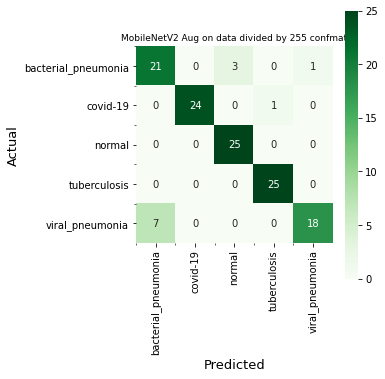

In [ ]:
del model
model = load_model('MobileNetV2 Augmentation on data divided by 255.h5')

final_loss, final_accuracy = model.evaluate(X_test_255, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after first training network head...")

predIdxs = model.predict(x=X_test_255,
	steps=(X_test_255.shape[0] // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(Y_true, predIdxs,target_names=categories))

plot_confusion_matrix('MobileNetV2 Aug on data divided by 255 confmat',Y_true, predIdxs, categories)

Normalized confusion matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


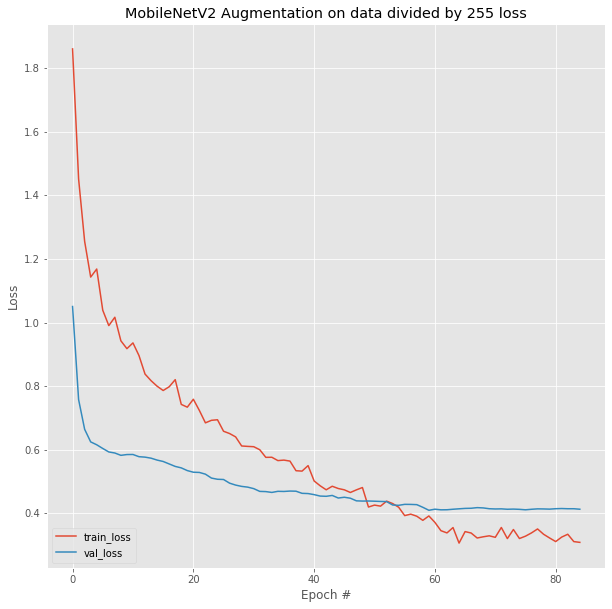

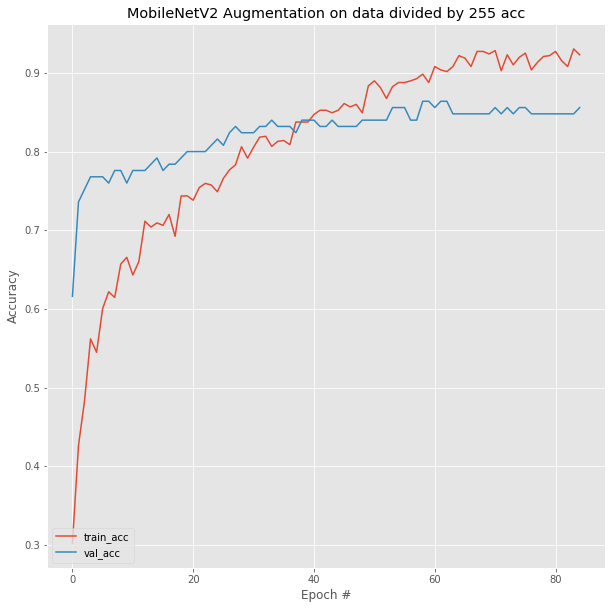

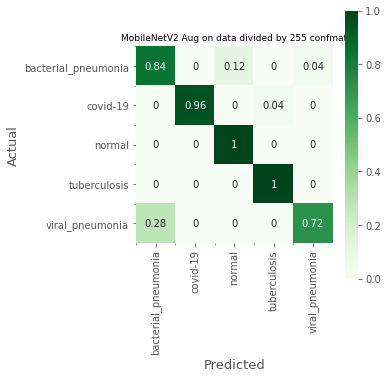

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'MobileNetV2 Augmentation on data divided by 255 loss')
plot_acc(hist, hist.epoch[-1]+1, 'MobileNetV2 Augmentation on data divided by 255 acc')
plot_confusion_matrix('MobileNetV2 Aug on data divided by 255 confmat',Y_true, predIdxs, categories)

(125, 5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


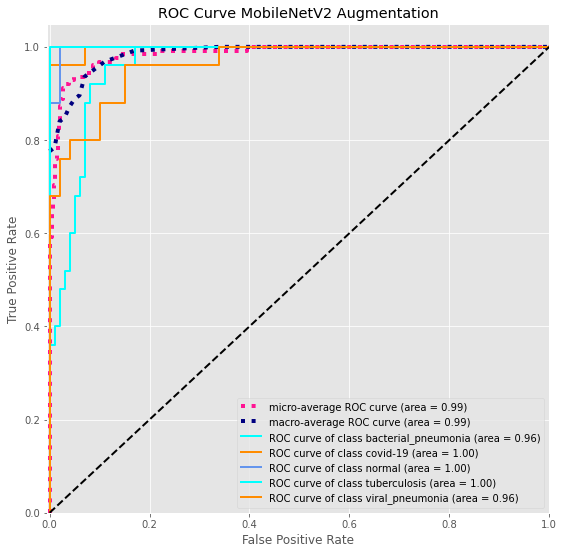

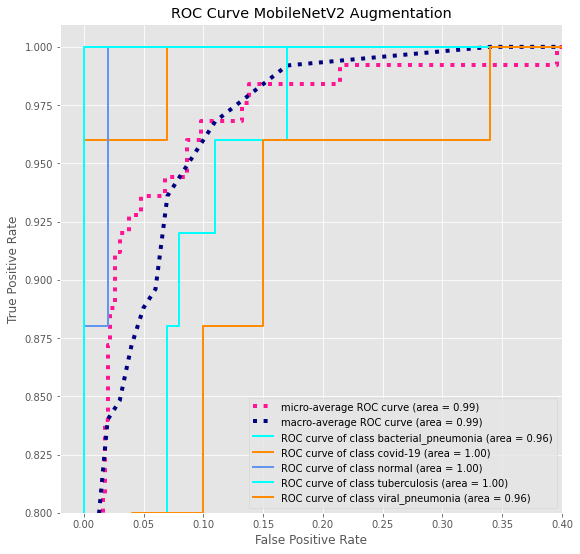

In [ ]:
predIdxs = model.predict(x=X_test_255,
	steps=(X_test_255.shape[0] // BATCH_SIZE) + 1)
print(predIdxs.shape)

plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve MobileNetV2 Augmentation')

#FineTuning

In [ ]:
del model
model = load_model('MobileNetV2 Augmentation on data divided by 255.h5')

In [ ]:
for layer in model.layers:
    layer.trainable = True

for layer in model.layers[:151]:
    layer.trainable = False

optimizer = Adam(lr= new_lr, beta_1=0.9, beta_2=0.999, decay=new_lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)
print(new_lr)

layer 0: input_1, trainable: False
layer 1: Conv1, trainable: False
layer 2: bn_Conv1, trainable: False
layer 3: Conv1_relu, trainable: False
layer 4: expanded_conv_depthwise, trainable: False
layer 5: expanded_conv_depthwise_BN, trainable: False
layer 6: expanded_conv_depthwise_relu, trainable: False
layer 7: expanded_conv_project, trainable: False
layer 8: expanded_conv_project_BN, trainable: False
layer 9: block_1_expand, trainable: False
layer 10: block_1_expand_BN, trainable: False
layer 11: block_1_expand_relu, trainable: False
layer 12: block_1_pad, trainable: False
layer 13: block_1_depthwise, trainable: False
layer 14: block_1_depthwise_BN, trainable: False
layer 15: block_1_depthwise_relu, trainable: False
layer 16: block_1_project, trainable: False
layer 17: block_1_project_BN, trainable: False
layer 18: block_2_expand, trainable: False
layer 19: block_2_expand_BN, trainable: False
layer 20: block_2_expand_relu, trainable: False
layer 21: block_2_depthwise, trainable: False


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
print(model.name)

annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('FineTuned MobileNetV2 Augmentation on data divided by 255.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=5,  # Degree range for random rotations
                             horizontal_flip=True,  # Randomly flip inputs horizontally
                             fill_mode = "nearest"
)

# Fits the model on batches
hist = model.fit(datagen.flow(X_train_255_ft, Y_train_ft, batch_size=BATCH_SIZE, shuffle=True),
                 steps_per_epoch=X_train_255_ft.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint,es],
                 validation_data=(X_val_255_ft, Y_val_ft))

model
Epoch 1/100
37/37 [==============================] - 24s 588ms/step - loss: 0.5688 - accuracy: 0.8296 - val_loss: 0.3201 - val_accuracy: 0.8933

Epoch 00001: val_loss improved from inf to 0.32013, saving model to FineTuned MobileNetV2 Augmentation on data divided by 255.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
37/37 [==============================] - 21s 552ms/step - loss: 0.5438 - accuracy: 0.8283 - val_loss: 0.3404 - val_accuracy: 0.8833

Epoch 00002: val_loss did not improve from 0.32013
Epoch 3/100
37/37 [==============================] - 20s 540ms/step - loss: 0.5464 - accuracy: 0.8356 - val_loss: 0.3553 - val_accuracy: 0.8700

Epoch 00003: val_loss did not improve from 0.32013
Epoch 4/100
37/37 [==============================] - 20s 539ms/step - loss: 0.5325 - accuracy: 0.8339 - val_loss: 0.3667 - val_accuracy: 0.8767

Epoch 00004: val_loss did not improve from 0.32013
Epoch 5/100
37/37 [==============================] - 20s 538ms/step - loss: 0.5278 - accuracy: 0.8425 - val_loss: 0.3824 - val_accuracy: 0.8700

Epoch 00005: val_loss did not improve from 0.32013
Epoch 6/100
37/37 [==============================] - 20s 542ms/step - loss: 0.5123 - accuracy: 0.8403 - val_loss: 0.3857 - val_accuracy: 0.8667

Epoch 00006: ReduceLROnPlateau reducing learning rate to 3.999999898951

In [ ]:
del model
model = load_model('FineTuned MobileNetV2 Augmentation on data divided by 255.h5')

final_loss, final_accuracy = model.evaluate(X_test_255, Y_test)

print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after fine tuning...")

Y_pred = model.predict(x=X_test_255,
	steps=(X_test_255.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred, target_names=categories))

4/4 [==============================] - 1s 101ms/step - loss: 0.3367 - accuracy: 0.9040
Final Loss: 0.3366685211658478, Final Accuracy: 0.9039999842643738
[INFO] evaluating after fine tuning...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.76      0.88      0.81        25
           covid-19       1.00      0.96      0.98        25
             normal       0.86      1.00      0.93        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       1.00      0.68      0.81        25

           accuracy                           0.90       125
          macro avg       0.92      0.90      0.90       125
       weighted avg       0.92      0.90      0.90       125



Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


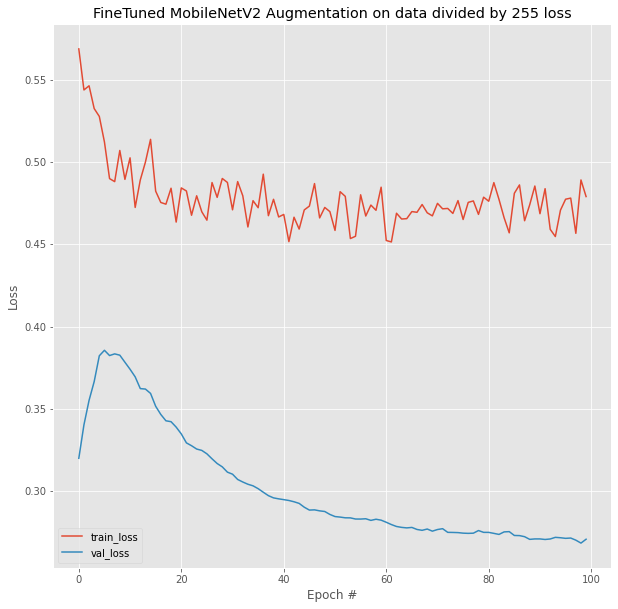

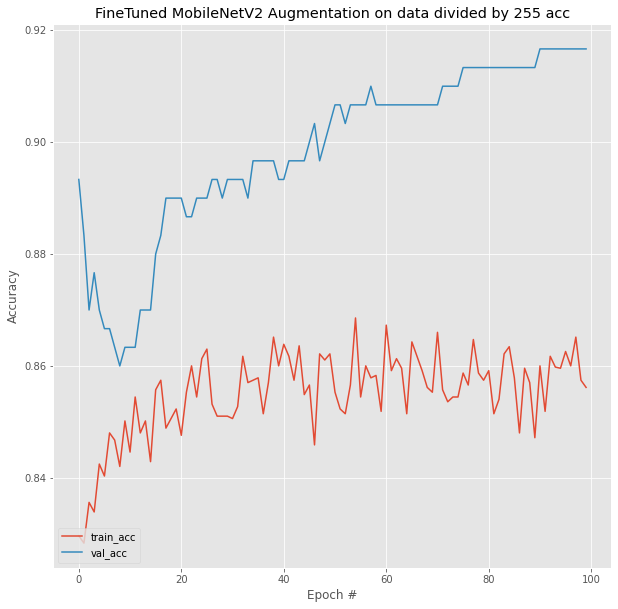

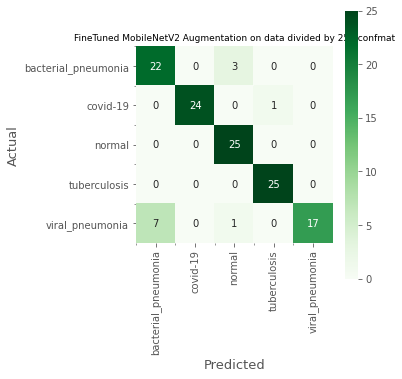

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'FineTuned MobileNetV2 Augmentation on data divided by 255 loss')
plot_acc(hist, hist.epoch[-1]+1, 'FineTuned MobileNetV2 Augmentation on data divided by 255 acc')
plot_confusion_matrix('FineTuned MobileNetV2 Augmentation on data divided by 255 confmat', Y_true, Y_pred, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


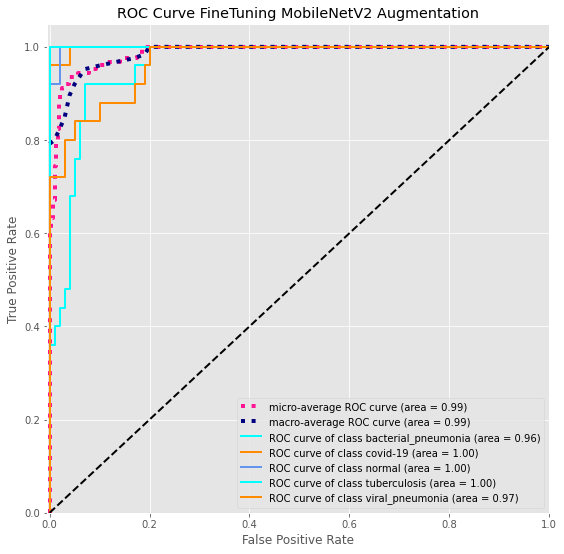

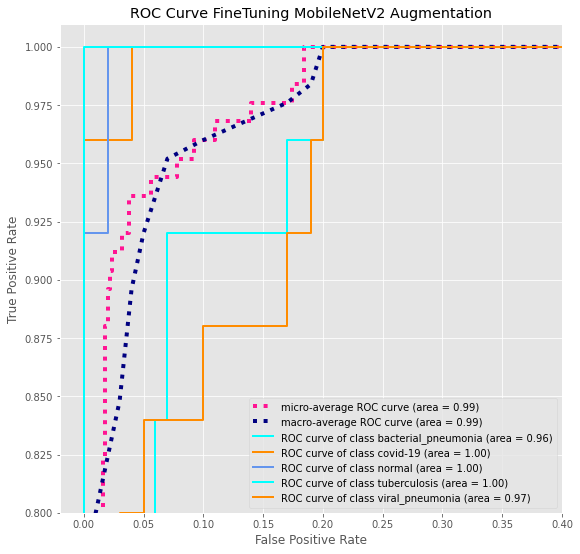

In [ ]:
predIdxs = model.predict(x=X_test_255,
	steps=(X_test_255.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve FineTuning MobileNetV2 Augmentation')

# AUGMENTATION on data normalized to (0-1)

**Transfer learning on MobileNetV2 before hist manipulation**

In [ ]:
del model
model = build_ImageNetModel(MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-12:]:
    layer.trainable = True

optimizer = Adam(lr= lr, beta_1=0.9, beta_2=0.999, decay=lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)
print(lr)

layer 0: input_1, trainable: False
layer 1: Conv1, trainable: False
layer 2: bn_Conv1, trainable: False
layer 3: Conv1_relu, trainable: False
layer 4: expanded_conv_depthwise, trainable: False
layer 5: expanded_conv_depthwise_BN, trainable: False
layer 6: expanded_conv_depthwise_relu, trainable: False
layer 7: expanded_conv_project, trainable: False
layer 8: expanded_conv_project_BN, trainable: False
layer 9: block_1_expand, trainable: False
layer 10: block_1_expand_BN, trainable: False
layer 11: block_1_expand_relu, trainable: False
layer 12: block_1_pad, trainable: False
layer 13: block_1_depthwise, trainable: False
layer 14: block_1_depthwise_BN, trainable: False
layer 15: block_1_depthwise_relu, trainable: False
layer 16: block_1_project, trainable: False
layer 17: block_1_project_BN, trainable: False
layer 18: block_2_expand, trainable: False
layer 19: block_2_expand_BN, trainable: False
layer 20: block_2_expand_relu, trainable: False
layer 21: block_2_depthwise, trainable: False


In [ ]:
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('MobileNetV2 Augmentation normalized.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=5,  # Degree range for random rotations
                             horizontal_flip=True,  # Randomly flip inputs horizontally
                             fill_mode='nearest'
                             )

# Fits the model on batches
hist = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE, shuffle=True),
                 steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val, Y_val))


Epoch 1/100
15/15 [==============================] - 13s 619ms/step - loss: 2.0595 - accuracy: 0.2235 - val_loss: 1.0598 - val_accuracy: 0.6240

Epoch 00001: val_loss improved from inf to 1.05983, saving model to MobileNetV2 Augmentation normalized.h5
Epoch 2/100
15/15 [==============================] - 8s 532ms/step - loss: 1.5448 - accuracy: 0.4025 - val_loss: 0.7927 - val_accuracy: 0.7280

Epoch 00002: val_loss improved from 1.05983 to 0.79274, saving model to MobileNetV2 Augmentation normalized.h5
Epoch 3/100
15/15 [==============================] - 8s 532ms/step - loss: 1.4551 - accuracy: 0.4143 - val_loss: 0.6916 - val_accuracy: 0.7680

Epoch 00003: val_loss improved from 0.79274 to 0.69155, saving model to MobileNetV2 Augmentation normalized.h5
Epoch 4/100
15/15 [==============================] - 8s 559ms/step - loss: 1.3288 - accuracy: 0.4713 - val_loss: 0.6506 - val_accuracy: 0.7840

Epoch 00004: val_loss improved from 0.69155 to 0.65055, saving model to MobileNetV2 Augmentati

4/4 [==============================] - 3s 467ms/step - loss: 0.3362 - accuracy: 0.8800
Final Loss: 0.3362111747264862, Final Accuracy: 0.8799999952316284
[INFO] evaluating after first training network head...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.75      0.84      0.79        25
           covid-19       1.00      0.96      0.98        25
             normal       0.92      0.88      0.90        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       0.78      0.72      0.75        25

           accuracy                           0.88       125
          macro avg       0.88      0.88      0.88       125
       weighted avg       0.88      0.88      0.88       125

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


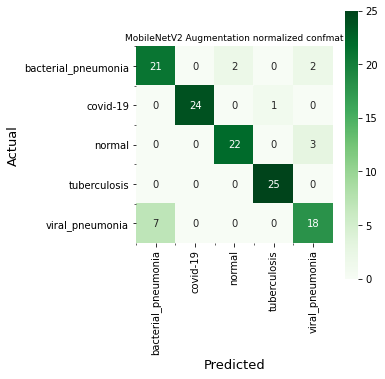

In [ ]:
del model
model = load_model('MobileNetV2 Augmentation normalized.h5')

final_loss, final_accuracy = model.evaluate(X_test, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after first training network head...")

predIdxs = model.predict(x=X_test,
	steps=(X_test.shape[0] // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(Y_true, predIdxs,target_names=categories))
plot_confusion_matrix('MobileNetV2 Augmentation normalized confmat',Y_true, predIdxs, categories)

Normalized confusion matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


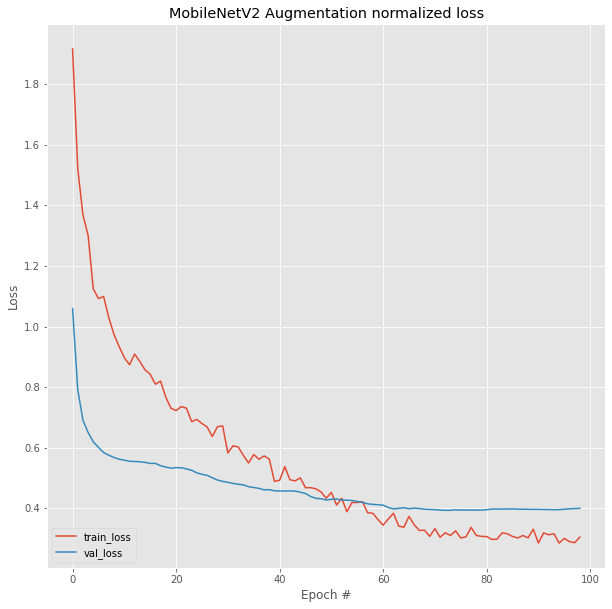

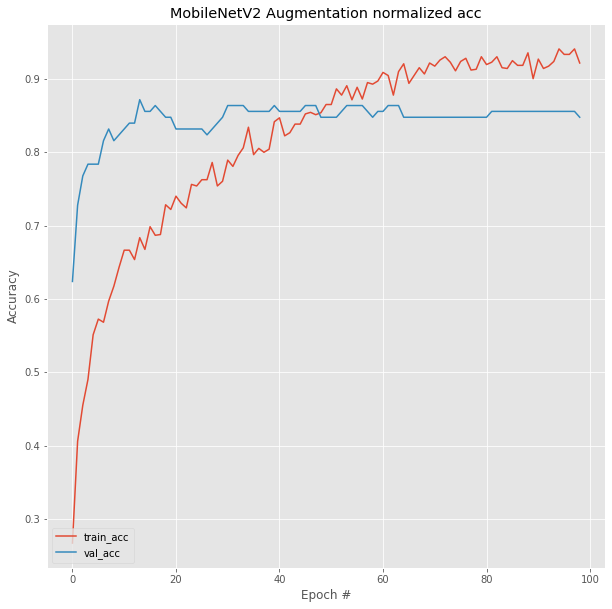

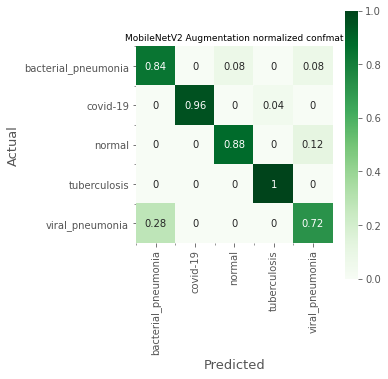

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'MobileNetV2 Augmentation normalized loss')
plot_acc(hist, hist.epoch[-1]+1, 'MobileNetV2 Augmentation normalized acc')
plot_confusion_matrix('MobileNetV2 Augmentation normalized confmat',Y_true, predIdxs, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


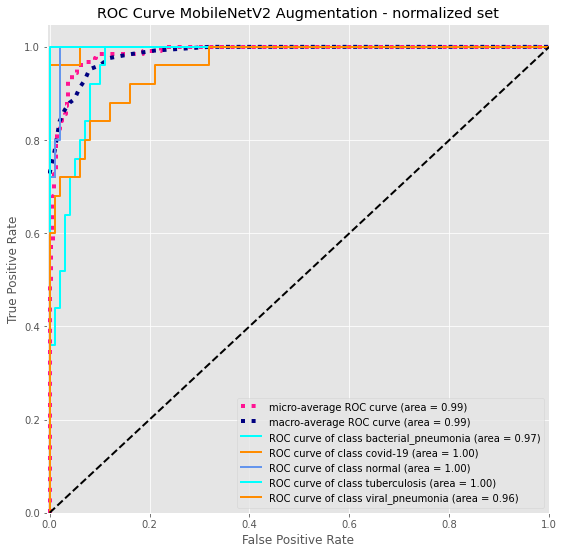

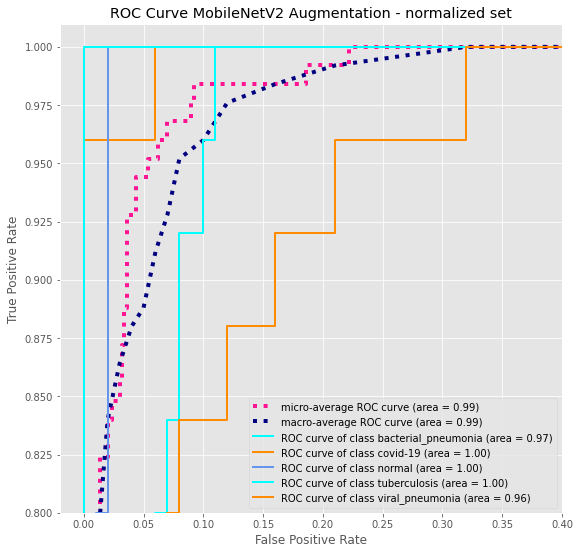

In [ ]:
predIdxs = model.predict(x=X_test,
	steps=(X_test.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve MobileNetV2 Augmentation - normalized set')

#FineTuning

**FineTuning MobileNetV2 after data normalization 0-1**

In [ ]:
del model
model = load_model('MobileNetV2 Augmentation normalized.h5')

In [ ]:
for layer in model.layers:
    layer.trainable = True

for layer in model.layers[:151]:
    layer.trainable = False


optimizer = Adam(lr= new_lr, beta_1=0.9, beta_2=0.999, decay=new_lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)
print(new_lr)

layer 0: input_1, trainable: False
layer 1: Conv1, trainable: False
layer 2: bn_Conv1, trainable: False
layer 3: Conv1_relu, trainable: False
layer 4: expanded_conv_depthwise, trainable: False
layer 5: expanded_conv_depthwise_BN, trainable: False
layer 6: expanded_conv_depthwise_relu, trainable: False
layer 7: expanded_conv_project, trainable: False
layer 8: expanded_conv_project_BN, trainable: False
layer 9: block_1_expand, trainable: False
layer 10: block_1_expand_BN, trainable: False
layer 11: block_1_expand_relu, trainable: False
layer 12: block_1_pad, trainable: False
layer 13: block_1_depthwise, trainable: False
layer 14: block_1_depthwise_BN, trainable: False
layer 15: block_1_depthwise_relu, trainable: False
layer 16: block_1_project, trainable: False
layer 17: block_1_project_BN, trainable: False
layer 18: block_2_expand, trainable: False
layer 19: block_2_expand_BN, trainable: False
layer 20: block_2_expand_relu, trainable: False
layer 21: block_2_depthwise, trainable: False


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
print(model.name)
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('FineTuned MobileNetV2 Augmentation normalized.h5', verbose=1
                             ,save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=5,  # Degree range for random rotations
                             horizontal_flip=True,  # Randomly flip inputs horizontally
                             fill_mode='nearest'
                             )
# Fits the model on batches
hist = model.fit(datagen.flow(X_train_ft, Y_train_ft, batch_size=BATCH_SIZE, shuffle=True),
                 steps_per_epoch=X_train_ft.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_ft, Y_val_ft))

model
Epoch 1/100
37/37 [==============================] - 33s 759ms/step - loss: 0.5107 - accuracy: 0.8292 - val_loss: 0.2803 - val_accuracy: 0.8967

Epoch 00001: val_loss improved from inf to 0.28028, saving model to FineTuned MobileNetV2 Augmentation normalized.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
37/37 [==============================] - 27s 734ms/step - loss: 0.4908 - accuracy: 0.8412 - val_loss: 0.3009 - val_accuracy: 0.8900

Epoch 00002: val_loss did not improve from 0.28028
Epoch 3/100
37/37 [==============================] - 27s 717ms/step - loss: 0.4918 - accuracy: 0.8515 - val_loss: 0.3209 - val_accuracy: 0.8800

Epoch 00003: val_loss did not improve from 0.28028
Epoch 4/100
37/37 [==============================] - 27s 723ms/step - loss: 0.4940 - accuracy: 0.8420 - val_loss: 0.3425 - val_accuracy: 0.8733

Epoch 00004: val_loss did not improve from 0.28028
Epoch 5/100
37/37 [==============================] - 27s 739ms/step - loss: 0.4645 - accuracy: 0.8557 - val_loss: 0.3521 - val_accuracy: 0.8700

Epoch 00005: val_loss did not improve from 0.28028
Epoch 6/100
37/37 [==============================] - 27s 730ms/step - loss: 0.4796 - accuracy: 0.8450 - val_loss: 0.3582 - val_accuracy: 0.8700

Epoch 00006: ReduceLROnPlateau reducing learning rate to 3.999999898951

In [ ]:
del model
model = load_model('FineTuned MobileNetV2 Augmentation normalized.h5')
print(X_test.shape)
final_loss, final_accuracy = model.evaluate(X_test, Y_test)

print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after fine tuning...")

Y_pred = model.predict(x=X_test,
	steps=(X_test.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred, target_names=categories))

(125, 224, 224, 3)
4/4 [==============================] - 1s 97ms/step - loss: 0.3078 - accuracy: 0.9040
Final Loss: 0.3077509105205536, Final Accuracy: 0.9039999842643738
[INFO] evaluating after fine tuning...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.81      0.84      0.82        25
           covid-19       1.00      0.96      0.98        25
             normal       0.92      0.92      0.92        25
       tuberculosis       0.93      1.00      0.96        25
    viral_pneumonia       0.87      0.80      0.83        25

           accuracy                           0.90       125
          macro avg       0.90      0.90      0.90       125
       weighted avg       0.90      0.90      0.90       125



Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


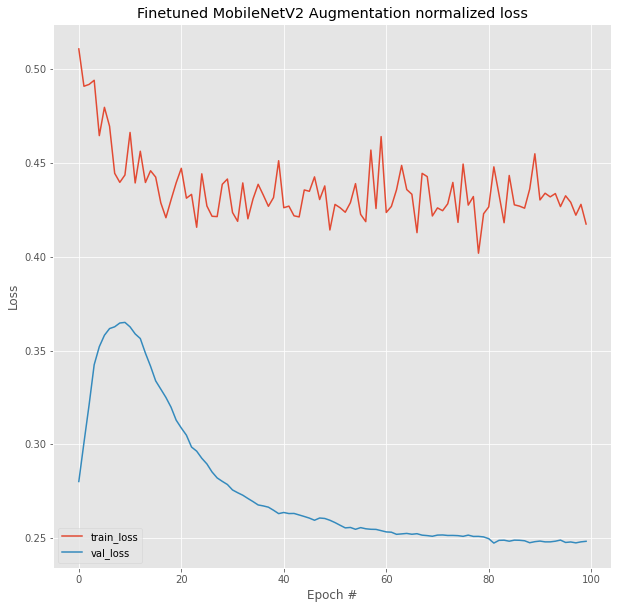

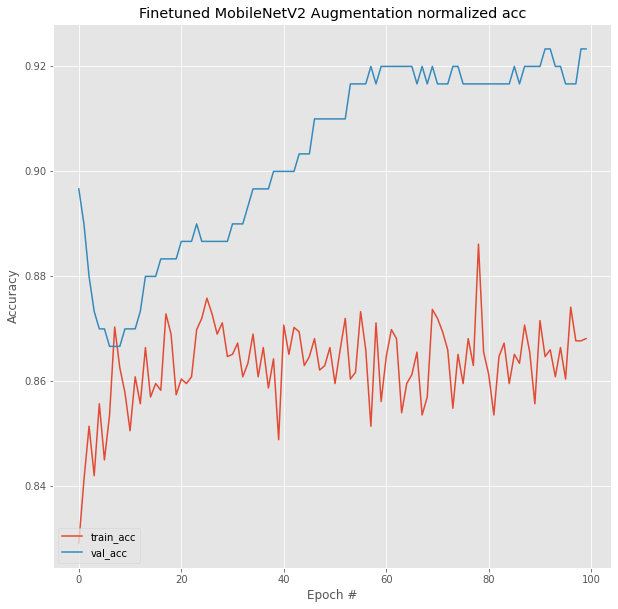

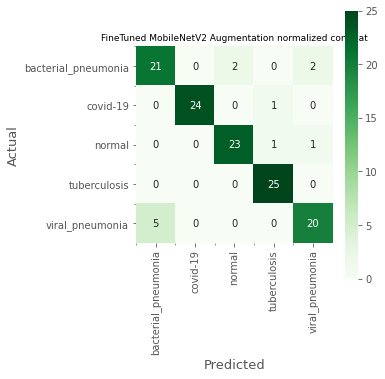

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'Finetuned MobileNetV2 Augmentation normalized loss')
plot_acc(hist, hist.epoch[-1]+1, 'Finetuned MobileNetV2 Augmentation normalized acc')
plot_confusion_matrix('FineTuned MobileNetV2 Augmentation normalized confmat',Y_true, Y_pred, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


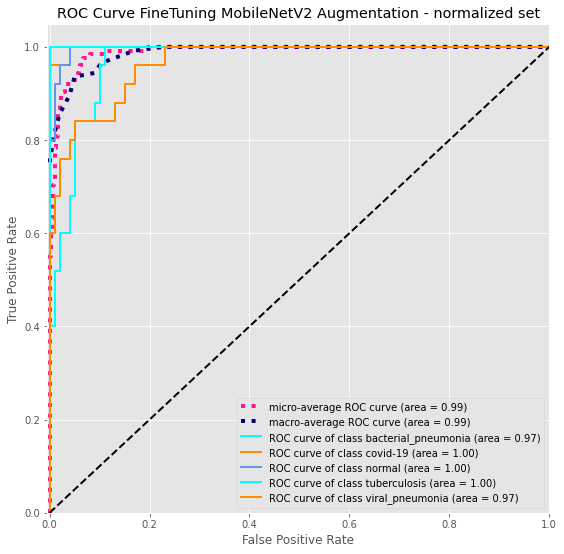

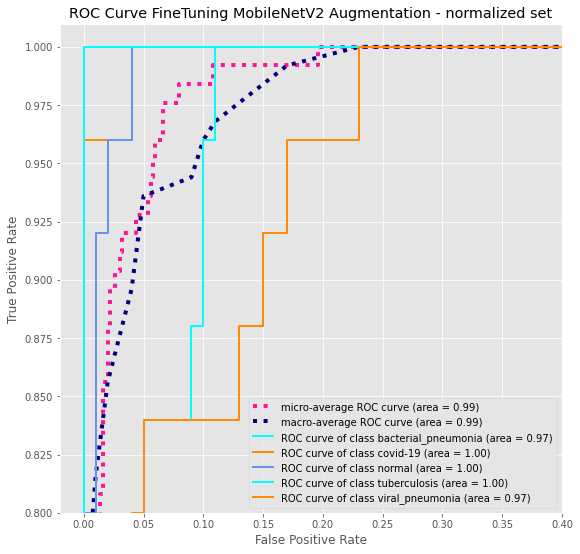

In [ ]:
predIdxs = model.predict(x=X_test,
	steps=(X_test.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve FineTuning MobileNetV2 Augmentation - normalized set')

# AUGMENTATION on data divided by 255 + CLAHE processed

**Transfer learning after CLAHE processing imgs**

In [ ]:
del model
model = build_ImageNetModel(MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-12:]:
    layer.trainable = True

optimizer = Adam(lr= lr, beta_1=0.9, beta_2=0.999, decay=lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)

layer 0: input_1, trainable: False
layer 1: Conv1, trainable: False
layer 2: bn_Conv1, trainable: False
layer 3: Conv1_relu, trainable: False
layer 4: expanded_conv_depthwise, trainable: False
layer 5: expanded_conv_depthwise_BN, trainable: False
layer 6: expanded_conv_depthwise_relu, trainable: False
layer 7: expanded_conv_project, trainable: False
layer 8: expanded_conv_project_BN, trainable: False
layer 9: block_1_expand, trainable: False
layer 10: block_1_expand_BN, trainable: False
layer 11: block_1_expand_relu, trainable: False
layer 12: block_1_pad, trainable: False
layer 13: block_1_depthwise, trainable: False
layer 14: block_1_depthwise_BN, trainable: False
layer 15: block_1_depthwise_relu, trainable: False
layer 16: block_1_project, trainable: False
layer 17: block_1_project_BN, trainable: False
layer 18: block_2_expand, trainable: False
layer 19: block_2_expand_BN, trainable: False
layer 20: block_2_expand_relu, trainable: False
layer 21: block_2_depthwise, trainable: False


In [ ]:
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('MobileNetV2 Augmentation CLAHE.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=5,  # Degree range for random rotations
                             horizontal_flip=True,  # Randomly flip inputs horizontally
                             )

# Fits the model on batches
hist = model.fit(datagen.flow(X_train_255_CLAHE, Y_train, batch_size=BATCH_SIZE, shuffle=True),
                 steps_per_epoch=X_train_255_CLAHE.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_255_CLAHE, Y_val))


Epoch 1/100
15/15 [==============================] - 13s 623ms/step - loss: 2.1778 - accuracy: 0.2202 - val_loss: 1.5450 - val_accuracy: 0.4080

Epoch 00001: val_loss improved from inf to 1.54501, saving model to MobileNetV2 Augmentation CLAHE.h5
Epoch 2/100
15/15 [==============================] - 8s 531ms/step - loss: 1.6362 - accuracy: 0.3646 - val_loss: 1.0743 - val_accuracy: 0.5760

Epoch 00002: val_loss improved from 1.54501 to 1.07434, saving model to MobileNetV2 Augmentation CLAHE.h5
Epoch 3/100
15/15 [==============================] - 8s 532ms/step - loss: 1.4313 - accuracy: 0.4284 - val_loss: 0.8566 - val_accuracy: 0.6080

Epoch 00003: val_loss improved from 1.07434 to 0.85657, saving model to MobileNetV2 Augmentation CLAHE.h5
Epoch 4/100
15/15 [==============================] - 8s 559ms/step - loss: 1.3308 - accuracy: 0.4977 - val_loss: 0.7283 - val_accuracy: 0.7200

Epoch 00004: val_loss improved from 0.85657 to 0.72832, saving model to MobileNetV2 Augmentation CLAHE.h5
Epo

4/4 [==============================] - 3s 449ms/step - loss: 0.3487 - accuracy: 0.8800
Final Loss: 0.34874945878982544, Final Accuracy: 0.8799999952316284
[INFO] evaluating after first training network head...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.77      0.80      0.78        25
           covid-19       1.00      0.92      0.96        25
             normal       0.89      0.96      0.92        25
       tuberculosis       0.93      1.00      0.96        25
    viral_pneumonia       0.82      0.72      0.77        25

           accuracy                           0.88       125
          macro avg       0.88      0.88      0.88       125
       weighted avg       0.88      0.88      0.88       125

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


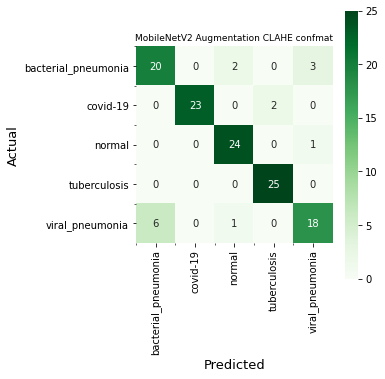

In [ ]:
del model
model = load_model('MobileNetV2 Augmentation CLAHE.h5')
final_loss, final_accuracy = model.evaluate(X_test_255_CLAHE, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after first training network head...")

Y_pred = model.predict(x=X_test_255_CLAHE,
	steps=(X_test_255_CLAHE.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred, target_names=categories))

plot_confusion_matrix('MobileNetV2 Augmentation CLAHE confmat',Y_true, Y_pred, categories)

Normalized confusion matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


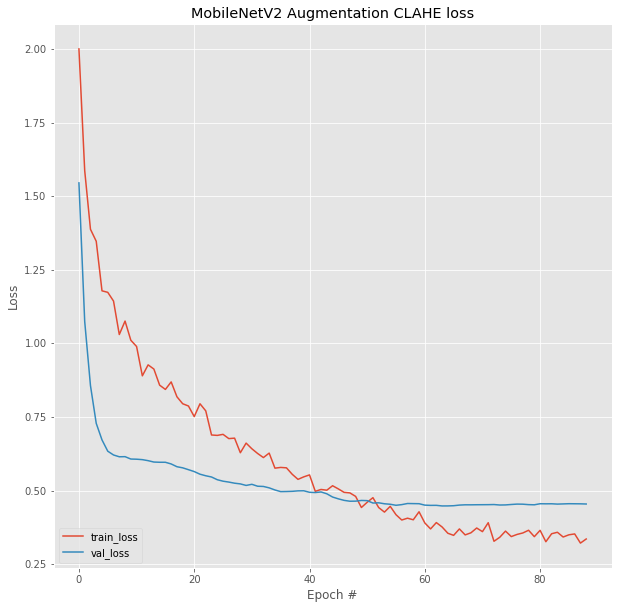

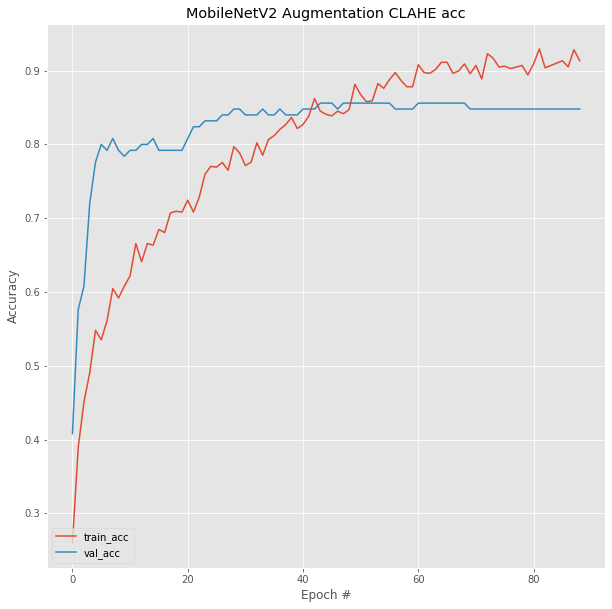

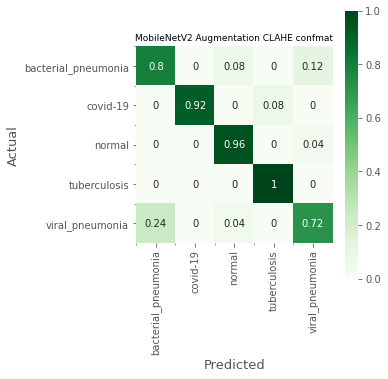

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'MobileNetV2 Augmentation CLAHE loss')
plot_acc(hist, hist.epoch[-1]+1, 'MobileNetV2 Augmentation CLAHE acc')
plot_confusion_matrix('MobileNetV2 Augmentation CLAHE confmat',Y_true, Y_pred, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


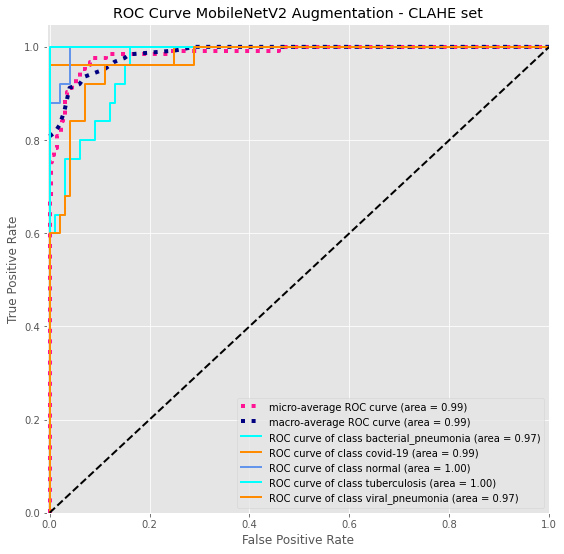

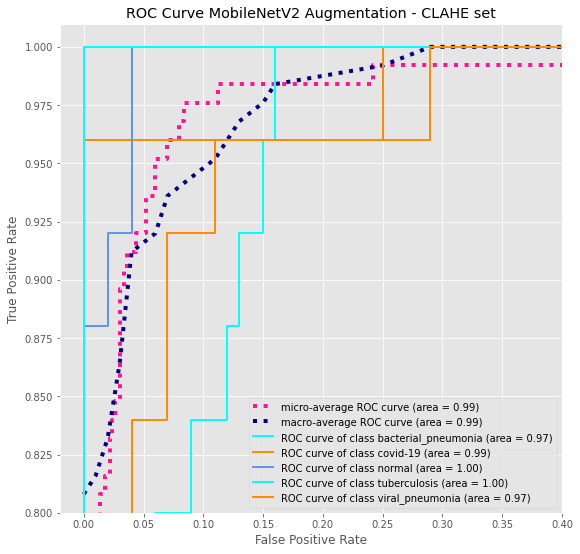

In [ ]:
predIdxs = model.predict(x=X_test_255_CLAHE,
	steps=(X_test_255_CLAHE.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve MobileNetV2 Augmentation - CLAHE set')

#FineTuning

**FineTuning MobileNetV2 on CLAHE processed imgs**

In [ ]:
del model
model = load_model('MobileNetV2 Augmentation CLAHE.h5')

In [ ]:
for layer in model.layers:
    layer.trainable = True

for layer in model.layers[:151]:
    layer.trainable = False

optimizer = Adam(lr= new_lr, beta_1=0.9, beta_2=0.999, decay=new_lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)

layer 0: input_1, trainable: False
layer 1: Conv1, trainable: False
layer 2: bn_Conv1, trainable: False
layer 3: Conv1_relu, trainable: False
layer 4: expanded_conv_depthwise, trainable: False
layer 5: expanded_conv_depthwise_BN, trainable: False
layer 6: expanded_conv_depthwise_relu, trainable: False
layer 7: expanded_conv_project, trainable: False
layer 8: expanded_conv_project_BN, trainable: False
layer 9: block_1_expand, trainable: False
layer 10: block_1_expand_BN, trainable: False
layer 11: block_1_expand_relu, trainable: False
layer 12: block_1_pad, trainable: False
layer 13: block_1_depthwise, trainable: False
layer 14: block_1_depthwise_BN, trainable: False
layer 15: block_1_depthwise_relu, trainable: False
layer 16: block_1_project, trainable: False
layer 17: block_1_project_BN, trainable: False
layer 18: block_2_expand, trainable: False
layer 19: block_2_expand_BN, trainable: False
layer 20: block_2_expand_relu, trainable: False
layer 21: block_2_depthwise, trainable: False


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('FineTuned MobileNetV2 Augmentation CLAHE.h5', verbose=1,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=5,  # Degree range for random rotations
                             horizontal_flip=True,  
                             )

# Fits the model on batches
hist = model.fit(datagen.flow(X_train_255_CLAHE_ft, Y_train_ft, batch_size=BATCH_SIZE, shuffle=True),
                 steps_per_epoch=X_train_255_CLAHE_ft.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_255_CLAHE_ft, Y_val_ft))

Epoch 1/100
37/37 [==============================] - 34s 790ms/step - loss: 0.5717 - accuracy: 0.8201 - val_loss: 0.3227 - val_accuracy: 0.8933

Epoch 00001: val_loss improved from inf to 0.32265, saving model to FineTuned MobileNetV2 Augmentation CLAHE.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
37/37 [==============================] - 28s 761ms/step - loss: 0.5719 - accuracy: 0.8176 - val_loss: 0.3370 - val_accuracy: 0.8867

Epoch 00002: val_loss did not improve from 0.32265
Epoch 3/100
37/37 [==============================] - 28s 751ms/step - loss: 0.5809 - accuracy: 0.8095 - val_loss: 0.3508 - val_accuracy: 0.8800

Epoch 00003: val_loss did not improve from 0.32265
Epoch 4/100
37/37 [==============================] - 28s 747ms/step - loss: 0.5403 - accuracy: 0.8318 - val_loss: 0.3538 - val_accuracy: 0.8800

Epoch 00004: val_loss did not improve from 0.32265
Epoch 5/100
37/37 [==============================] - 27s 737ms/step - loss: 0.5589 - accuracy: 0.8292 - val_loss: 0.3559 - val_accuracy: 0.8800

Epoch 00005: val_loss did not improve from 0.32265
Epoch 6/100
37/37 [==============================] - 28s 742ms/step - loss: 0.5410 - accuracy: 0.8275 - val_loss: 0.3574 - val_accuracy: 0.8767

Epoch 00006: ReduceLROnPlateau reducing learning rate to 3.999999898951

In [ ]:
del model
model = load_model('FineTuned MobileNetV2 Augmentation CLAHE.h5')
final_loss, final_accuracy = model.evaluate(X_test_255_CLAHE, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after fine tuning...")
Y_pred = model.predict(x=X_test_255_CLAHE,
	steps=(X_test_255_CLAHE.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred, target_names=categories))

4/4 [==============================] - 1s 100ms/step - loss: 0.3425 - accuracy: 0.8960
Final Loss: 0.34249842166900635, Final Accuracy: 0.8960000276565552
[INFO] evaluating after fine tuning...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.78      0.84      0.81        25
           covid-19       1.00      0.92      0.96        25
             normal       0.92      0.92      0.92        25
       tuberculosis       0.93      1.00      0.96        25
    viral_pneumonia       0.87      0.80      0.83        25

           accuracy                           0.90       125
          macro avg       0.90      0.90      0.90       125
       weighted avg       0.90      0.90      0.90       125



Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


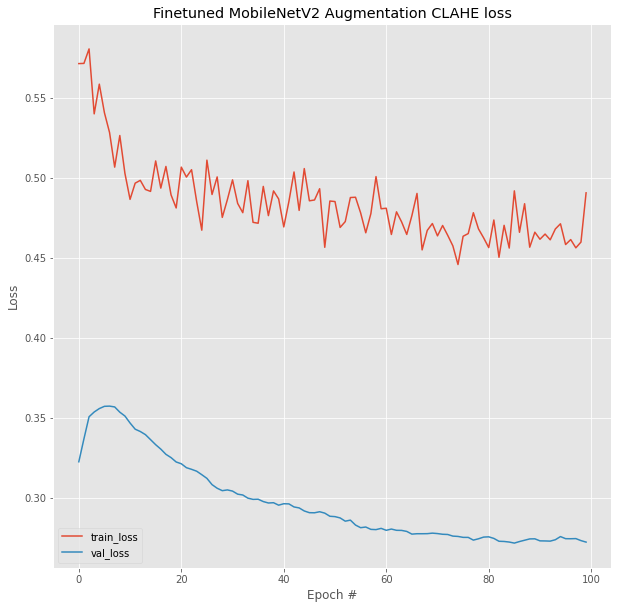

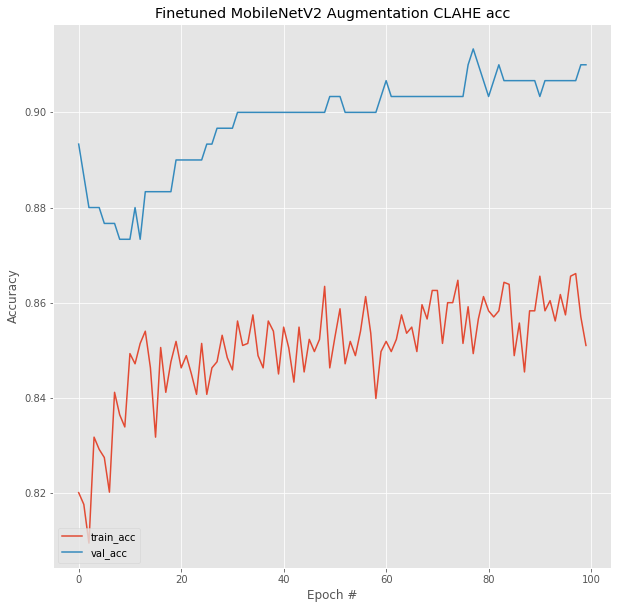

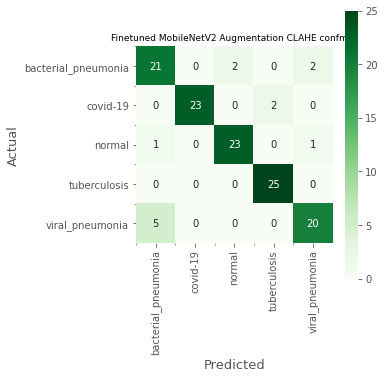

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'Finetuned MobileNetV2 Augmentation CLAHE loss')
plot_acc(hist, hist.epoch[-1]+1, 'Finetuned MobileNetV2 Augmentation CLAHE acc')
plot_confusion_matrix('Finetuned MobileNetV2 Augmentation CLAHE confmat',Y_true, Y_pred, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


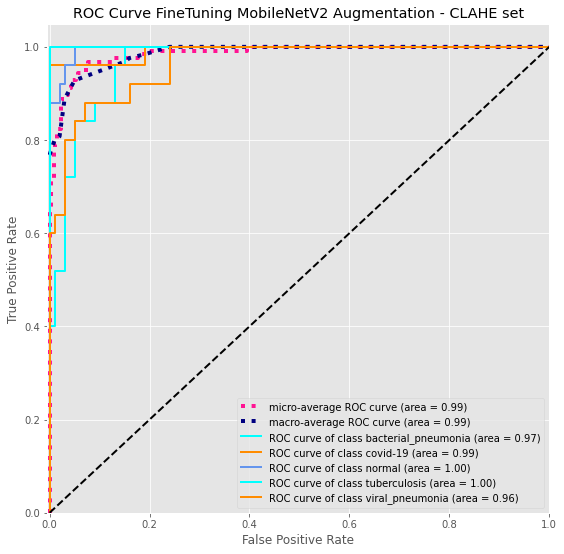

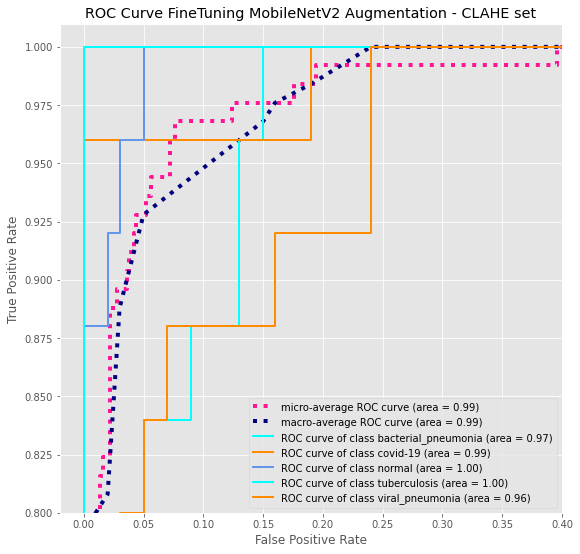

In [ ]:
predIdxs = model.predict(x=X_test_255_CLAHE,
	steps=(X_test_255_CLAHE.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve FineTuning MobileNetV2 Augmentation - CLAHE set')

# AUGMENTATION on data normalized to (0-1) + CLAHE processed

**Transfer learning after CLAHE processing imgs**

In [ ]:
del model
model = build_ImageNetModel(MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-12:]:
    layer.trainable = True

optimizer = Adam(lr= lr, beta_1=0.9, beta_2=0.999, decay=lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)
print(lr)

layer 0: input_1, trainable: False
layer 1: Conv1, trainable: False
layer 2: bn_Conv1, trainable: False
layer 3: Conv1_relu, trainable: False
layer 4: expanded_conv_depthwise, trainable: False
layer 5: expanded_conv_depthwise_BN, trainable: False
layer 6: expanded_conv_depthwise_relu, trainable: False
layer 7: expanded_conv_project, trainable: False
layer 8: expanded_conv_project_BN, trainable: False
layer 9: block_1_expand, trainable: False
layer 10: block_1_expand_BN, trainable: False
layer 11: block_1_expand_relu, trainable: False
layer 12: block_1_pad, trainable: False
layer 13: block_1_depthwise, trainable: False
layer 14: block_1_depthwise_BN, trainable: False
layer 15: block_1_depthwise_relu, trainable: False
layer 16: block_1_project, trainable: False
layer 17: block_1_project_BN, trainable: False
layer 18: block_2_expand, trainable: False
layer 19: block_2_expand_BN, trainable: False
layer 20: block_2_expand_relu, trainable: False
layer 21: block_2_depthwise, trainable: False


In [ ]:
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('MobileNetV2 Augmentation CLAHE + normalized.h5', verbose=1
                             ,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=5,  # Degree range for random rotations
                             horizontal_flip=True,  # Randomly flip inputs horizontally
                             )

# Fits the model on batches
hist = model.fit(datagen.flow(X_train_CLAHE, Y_train, batch_size=BATCH_SIZE, shuffle=True),
                 steps_per_epoch=X_train_CLAHE.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_CLAHE, Y_val))


Epoch 1/100
15/15 [==============================] - 13s 617ms/step - loss: 1.9978 - accuracy: 0.2717 - val_loss: 1.1645 - val_accuracy: 0.4640

Epoch 00001: val_loss improved from inf to 1.16447, saving model to MobileNetV2 Augmentation CLAHE + normalized.h5
Epoch 2/100
15/15 [==============================] - 8s 532ms/step - loss: 1.5734 - accuracy: 0.3800 - val_loss: 0.8534 - val_accuracy: 0.6320

Epoch 00002: val_loss improved from 1.16447 to 0.85339, saving model to MobileNetV2 Augmentation CLAHE + normalized.h5
Epoch 3/100
15/15 [==============================] - 8s 549ms/step - loss: 1.3341 - accuracy: 0.4746 - val_loss: 0.6913 - val_accuracy: 0.7120

Epoch 00003: val_loss improved from 0.85339 to 0.69130, saving model to MobileNetV2 Augmentation CLAHE + normalized.h5
Epoch 4/100
15/15 [==============================] - 8s 535ms/step - loss: 1.2846 - accuracy: 0.5011 - val_loss: 0.6137 - val_accuracy: 0.7840

Epoch 00004: val_loss improved from 0.69130 to 0.61369, saving model t

4/4 [==============================] - 3s 459ms/step - loss: 0.3212 - accuracy: 0.8800
Final Loss: 0.3211822807788849, Final Accuracy: 0.8799999952316284
[INFO] evaluating after first training network head...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.77      0.80      0.78        25
           covid-19       1.00      0.96      0.98        25
             normal       0.88      0.92      0.90        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       0.78      0.72      0.75        25

           accuracy                           0.88       125
          macro avg       0.88      0.88      0.88       125
       weighted avg       0.88      0.88      0.88       125

Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


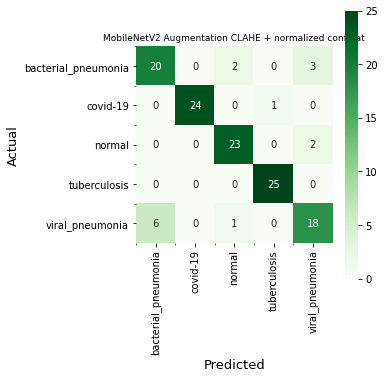

In [ ]:
del model
model = load_model('MobileNetV2 Augmentation CLAHE + normalized.h5')
final_loss, final_accuracy = model.evaluate(X_test_CLAHE, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after first training network head...")

Y_pred = model.predict(x=X_test_CLAHE,
	steps=(X_test_CLAHE.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred, target_names=categories))

plot_confusion_matrix('MobileNetV2 Augmentation CLAHE + normalized confmat',Y_true, Y_pred, categories)

Normalized confusion matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


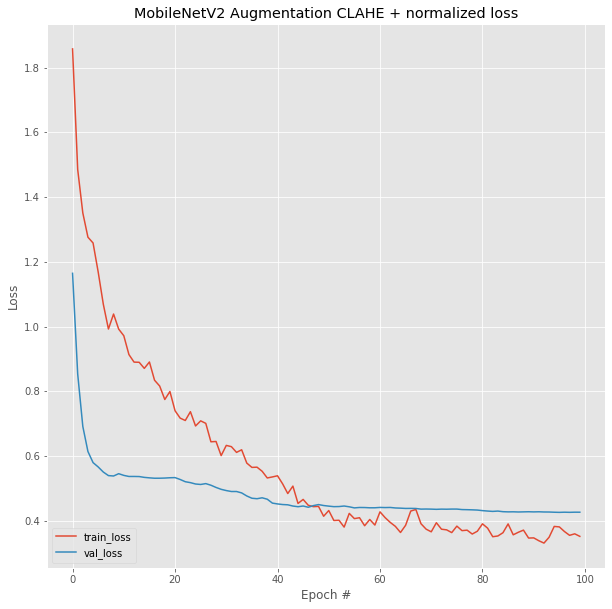

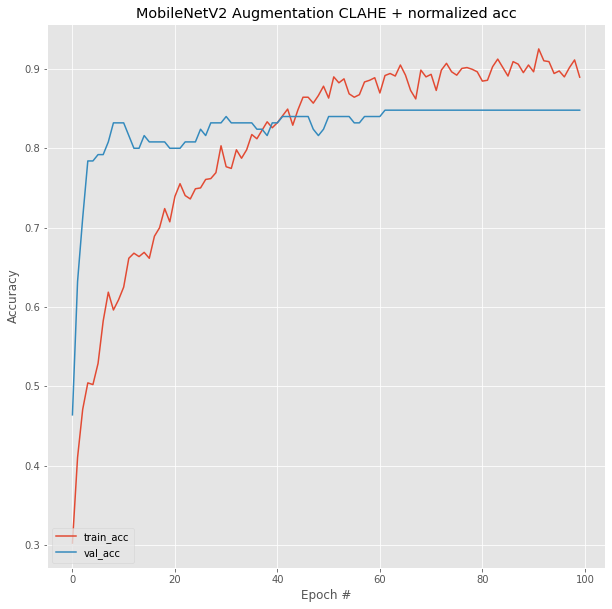

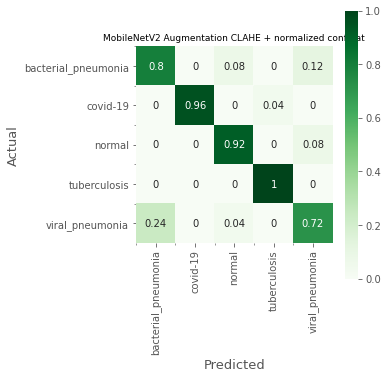

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'MobileNetV2 Augmentation CLAHE + normalized loss')
plot_acc(hist, hist.epoch[-1]+1, 'MobileNetV2 Augmentation CLAHE + normalized acc')
plot_confusion_matrix('MobileNetV2 Augmentation CLAHE + normalized confmat',Y_true, Y_pred, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


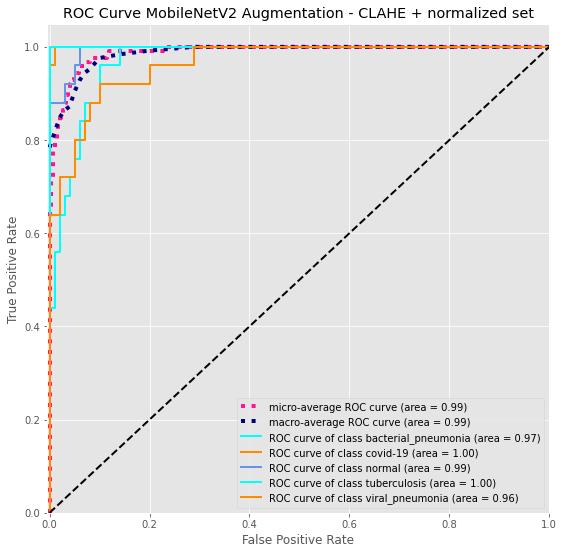

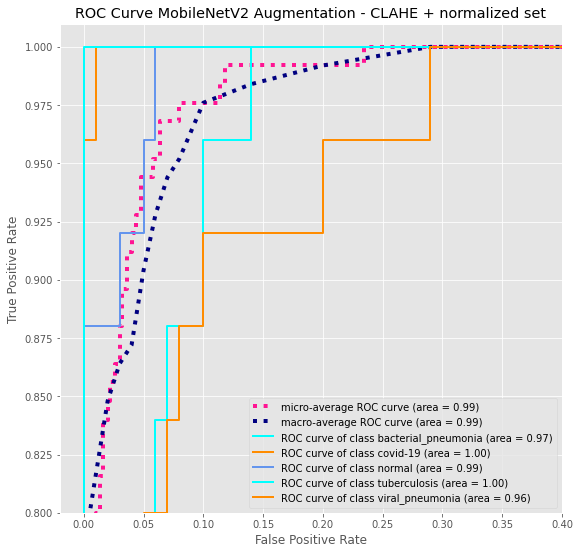

In [ ]:
predIdxs = model.predict(x=X_test_CLAHE,
	steps=(X_test_CLAHE.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve MobileNetV2 Augmentation - CLAHE + normalized set')

**FineTuning MobileNetV2 on CLAHE processed imgs**

# FineTuning

In [ ]:
# del model
model = load_model('MobileNetV2 Augmentation CLAHE + normalized.h5')

In [ ]:
for layer in model.layers:
    layer.trainable = True

for layer in model.layers[:151]:
    layer.trainable = False

optimizer = Adam(lr= new_lr, beta_1=0.9, beta_2=0.999, decay=new_lr/EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print_layers(model)

layer 0: input_1, trainable: False
layer 1: Conv1, trainable: False
layer 2: bn_Conv1, trainable: False
layer 3: Conv1_relu, trainable: False
layer 4: expanded_conv_depthwise, trainable: False
layer 5: expanded_conv_depthwise_BN, trainable: False
layer 6: expanded_conv_depthwise_relu, trainable: False
layer 7: expanded_conv_project, trainable: False
layer 8: expanded_conv_project_BN, trainable: False
layer 9: block_1_expand, trainable: False
layer 10: block_1_expand_BN, trainable: False
layer 11: block_1_expand_relu, trainable: False
layer 12: block_1_pad, trainable: False
layer 13: block_1_depthwise, trainable: False
layer 14: block_1_depthwise_BN, trainable: False
layer 15: block_1_depthwise_relu, trainable: False
layer 16: block_1_project, trainable: False
layer 17: block_1_project_BN, trainable: False
layer 18: block_2_expand, trainable: False
layer 19: block_2_expand_BN, trainable: False
layer 20: block_2_expand_relu, trainable: False
layer 21: block_2_depthwise, trainable: False


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
print(X_train_CLAHE.shape)

annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, min_lr=1e-10)
checkpoint = ModelCheckpoint('FineTuned MobileNetV2 Augmentation CLAHE + normalized.h5', verbose=1,save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=5,  # Degree range for random rotations
                             horizontal_flip=True,
                             )

# Fits the model on batches
hist = model.fit(datagen.flow(X_train_CLAHE_ft, Y_train_ft, batch_size=BATCH_SIZE, shuffle=True),
                 steps_per_epoch=X_train_CLAHE_ft.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS, verbose=1,
                 callbacks=[annealer, checkpoint, es],
                 validation_data=(X_val_CLAHE_ft, Y_val_ft))

(2400, 224, 224, 3)
Epoch 1/100
37/37 [==============================] - 55s 586ms/step - loss: 0.5902 - accuracy: 0.8176 - val_loss: 0.2803 - val_accuracy: 0.9100

Epoch 00001: val_loss improved from inf to 0.28030, saving model to FineTuned MobileNetV2 Augmentation CLAHE + normalized.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
37/37 [==============================] - 21s 558ms/step - loss: 0.5777 - accuracy: 0.8223 - val_loss: 0.2908 - val_accuracy: 0.9067

Epoch 00002: val_loss did not improve from 0.28030
Epoch 3/100
37/37 [==============================] - 20s 550ms/step - loss: 0.5347 - accuracy: 0.8386 - val_loss: 0.3006 - val_accuracy: 0.9000

Epoch 00003: val_loss did not improve from 0.28030
Epoch 4/100
37/37 [==============================] - 20s 546ms/step - loss: 0.5511 - accuracy: 0.8309 - val_loss: 0.3020 - val_accuracy: 0.9000

Epoch 00004: val_loss did not improve from 0.28030
Epoch 5/100
37/37 [==============================] - 20s 552ms/step - loss: 0.5083 - accuracy: 0.8390 - val_loss: 0.3131 - val_accuracy: 0.8867

Epoch 00005: val_loss did not improve from 0.28030
Epoch 6/100
37/37 [==============================] - 20s 552ms/step - loss: 0.5335 - accuracy: 0.8403 - val_loss: 0.3133 - val_accuracy: 0.8900

Epoch 00006: ReduceLROnPlateau reducing learning rate to 3.999999898951

In [ ]:
del model
model = load_model('FineTuned MobileNetV2 Augmentation CLAHE + normalized.h5')
final_loss, final_accuracy = model.evaluate(X_test_CLAHE, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

#predictions
Y_true = np.argmax(Y_test, axis=1)
print("[INFO] evaluating after fine tuning...")
Y_pred = model.predict(x=X_test_CLAHE,
	steps=(X_test_CLAHE.shape[0] // BATCH_SIZE) + 1)
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_true, Y_pred, target_names=categories))

4/4 [==============================] - 1s 103ms/step - loss: 0.2887 - accuracy: 0.9040
Final Loss: 0.2886994481086731, Final Accuracy: 0.9039999842643738
[INFO] evaluating after fine tuning...
                     precision    recall  f1-score   support

bacterial_pneumonia       0.83      0.80      0.82        25
           covid-19       1.00      0.96      0.98        25
             normal       0.96      0.92      0.94        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       0.78      0.84      0.81        25

           accuracy                           0.90       125
          macro avg       0.91      0.90      0.90       125
       weighted avg       0.91      0.90      0.90       125



Confusion matrix, without normalization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


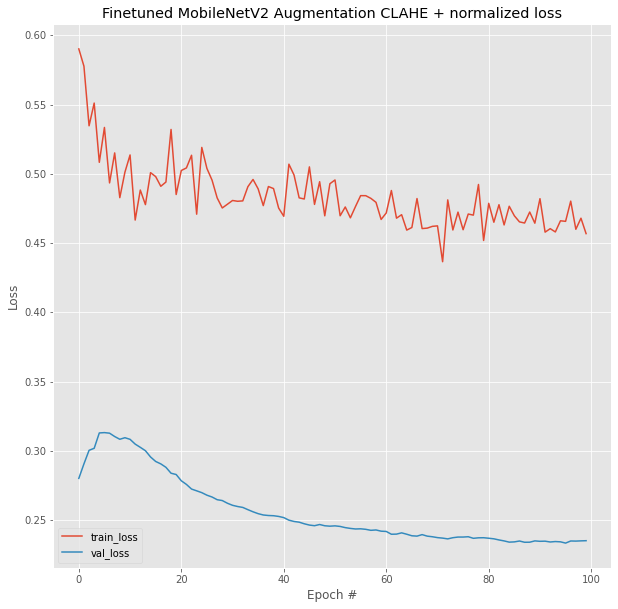

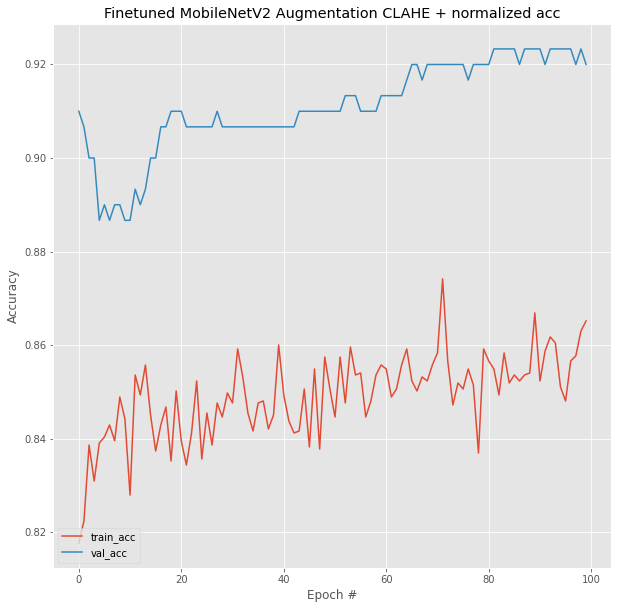

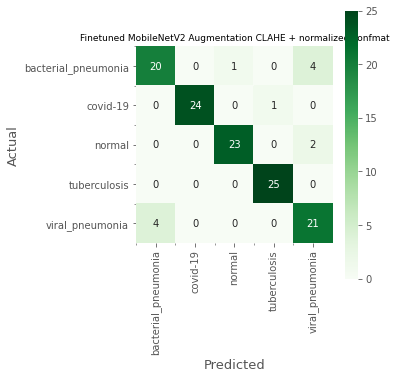

In [ ]:
plot_loss(hist, hist.epoch[-1]+1, 'Finetuned MobileNetV2 Augmentation CLAHE + normalized loss')
plot_acc(hist, hist.epoch[-1]+1, 'Finetuned MobileNetV2 Augmentation CLAHE + normalized acc')
plot_confusion_matrix('Finetuned MobileNetV2 Augmentation CLAHE + normalized confmat',Y_true, Y_pred, categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


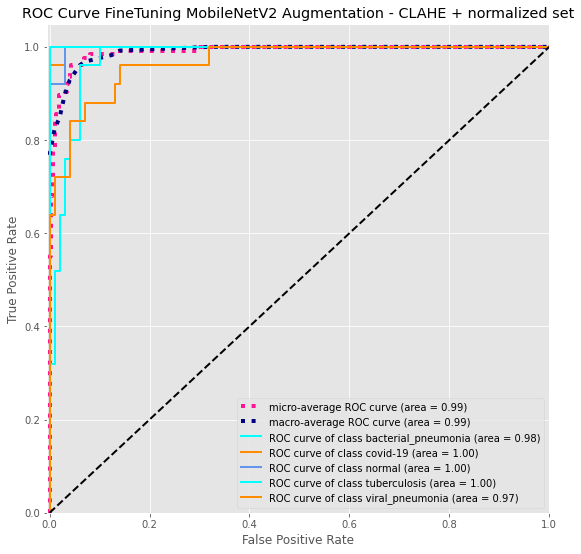

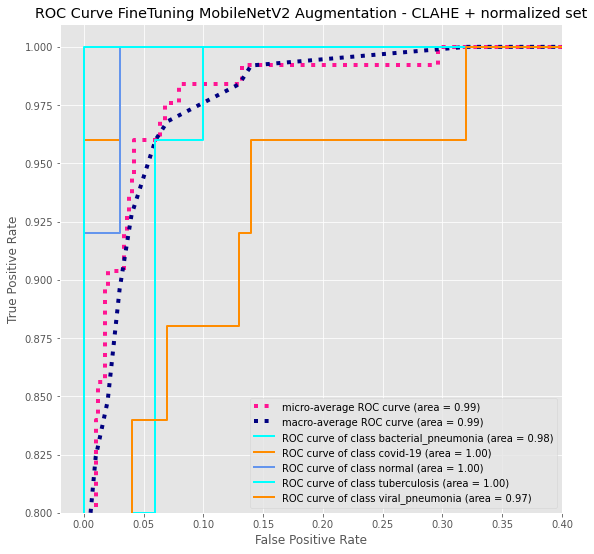

In [ ]:
predIdxs = model.predict(x=X_test_CLAHE,
	steps=(X_test_CLAHE.shape[0] // BATCH_SIZE) + 1)
plot_ROC(Y_test, predIdxs, len(categories), 'ROC Curve FineTuning MobileNetV2 Augmentation - CLAHE + normalized set')

# Defining and loading Functions for SVM

In [ ]:
pip install daal4py

     |████████████████████████████████| 11.8MB 8.9MB/s 
     |████████████████████████████████| 171.6MB 27kB/s 
     |████████████████████████████████| 277.5MB 11kB/s 
     |████████████████████████████████| 31.6MB 42kB/s 
     |████████████████████████████████| 169.0MB 23kB/s 
     |████████████████████████████████| 3.9MB 54.3MB/s 


In [ ]:
import sys
import os
import site
sys.path.append(os.path.join(os.path.dirname(site.getsitepackages()[0]), "site-packages"))

In [ ]:
from daal4py.sklearn import patch_sklearn
patch_sklearn()

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(0.1, 1, 7)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [ ]:
def make_classification(svc, confmat_title, ROC_title, training_title, X_train, y_train, X_test, y_test, cv, kernel, decision_function_shape, verbose, C, with_grid_search, normalize, y_test_ROC):
  from sklearn.metrics import classification_report
  if with_grid_search==True:
    print('Training with parameter GridSearch tuning')
    param = {
      "C": C,
      "kernel": [kernel],
      "decision_function_shape":[decision_function_shape]
    }
    # GridSearchCV for hyperparameters optimization
    clf = GridSearchCV(svc, param, cv=cv, verbose = verbose)
    clf.fit(X_train, y_train) #clf bylo
    print("Best params: ",clf.best_params_)
    print("Best estimator: ", clf.best_estimator_)
    clf = clf.best_estimator_
    y_pred = clf.predict(X_test)
    preds=clf.decision_function(X_test)
    
    print(classification_report(y_test, y_pred, target_names=categories))
    labels = np.unique(y_test)
    print('Loss:', hinge_loss(y_test, preds, labels=labels))
    plot_confusion_matrix(confmat_title, y_test, y_pred, classes = categories, normalize= normalize)
    plt.show()
    plot_ROC_SVM(X_train, y_train, X_test, y_test, preds, len(categories), categories, ROC_title, cv)

    plot_learning_curve(clf, title=training_title, X=X_train, y=y_train, cv=cv)

    return clf
  elif with_grid_search==False:
    print('Training without parameter tuning')
    svc = SVC(verbose = verbose)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    print(y_pred.shape)
    print(classification_report(y_test, y_pred, target_names=categories))
    plot_confusion_matrix(confmat_title, y_test, y_pred, classes = categories, normalize= normalize)
    plt.show()
    plot_ROC_SVM(X_train, y_train, X_test, y_test, svc, len(categories), categories, ROC_title, cv)
    plot_learning_curve(svc, title=training_title, X=X_train, y=y_train, cv=cv)
    return svc

# Feature Extraction and SVM CLASSIFICATION on data divided by 255

**USING SVM CLASSIFIER**

**ImageData / 255**

In [ ]:
base_model = (MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
# Freezing layers in convolutional base
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
________________

In [ ]:
#shape of output layer
output_shape = base_model.layers[-1].output_shape[-1]
output_shape

1280

In [ ]:
train_features = base_model.predict(X_train_255)
val_features = base_model.predict(X_val_255)
test_features = base_model.predict(X_test_255)

In [ ]:
print(train_features.shape)
train_features = train_features.reshape(train_features.shape[0], train_features.shape[1]*train_features.shape[2]*train_features.shape[3])
print(train_features.shape)

(1000, 7, 7, 1280)
(1000, 62720)


In [ ]:
print(val_features.shape)
val_features = val_features.reshape(val_features.shape[0],val_features.shape[1]*val_features.shape[1]*val_features.shape[3])
print(val_features.shape)

(125, 7, 7, 1280)
(125, 62720)


In [ ]:
print(test_features.shape)
test_features = test_features.reshape(test_features.shape[0], test_features.shape[1]*test_features.shape[1]*test_features.shape[3])
print(test_features.shape)

(125, 7, 7, 1280)
(125, 62720)


In [ ]:
print(Y_train.shape)
train_labels = train['Disease Type'].values
test_labels = test['Disease Type'].values
val_labels = val['Disease Type'].values
print(val_labels.shape)

(1000, 5)
(125,)


In [ ]:
train_val_concat_features = np.concatenate((train_features, val_features))
train_val_concat_labels = np.concatenate((train_labels, val_labels))

Training with parameter GridSearch tuning
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.782, total=   5.6s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.907, total=   5.4s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.871, total=   5.3s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.844, total=   5.3s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.907, total=   5.4s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.787, total=   5.3s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.916, total=   5.3s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.862, total=   5.3s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 17.5min finished


Best params:  {'C': 2.8942661247167517e-05, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=2.8942661247167517e-05, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.79      0.88      0.83        25
           covid-19       1.00      1.00      1.00        25
             normal       0.86      1.00      0.93        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.94      0.68      0.79        25

           accuracy                           0.91       125
          macro avg       0.92      0.91      0.91       125
       weighted avg       0.92      0.91      0.91       125

Loss: 0.1945617918115182
Confusion matrix, without nor

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


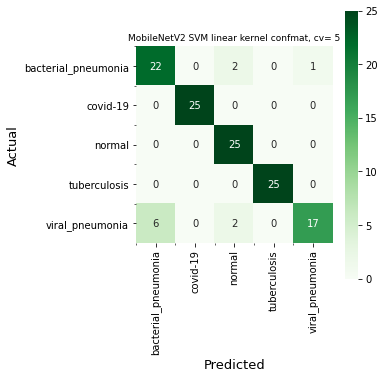

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


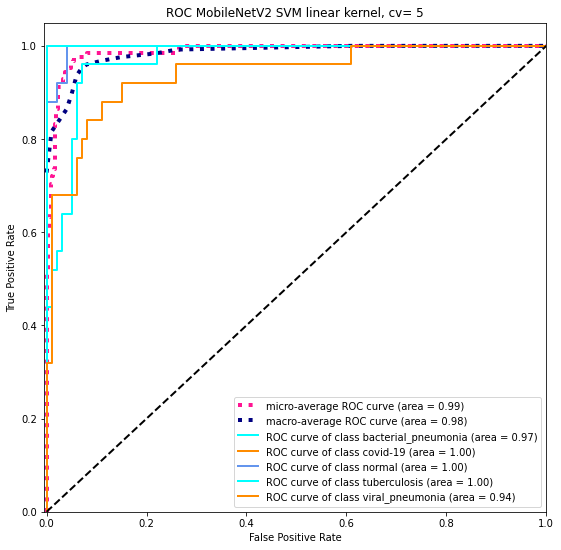

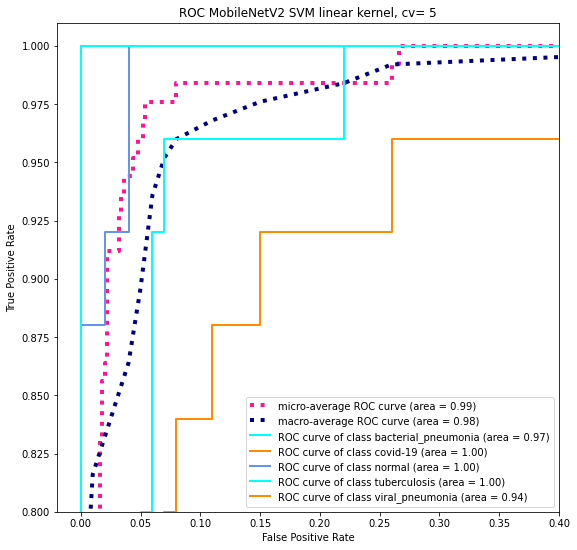

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.p

SVC(C=2.8942661247167517e-05, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

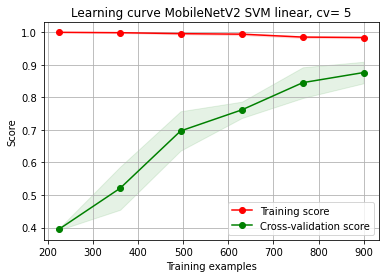

In [ ]:
cv=5
C = np.logspace(-5, 1, 40)

make_classification(SVC(), 'MobileNetV2 SVM linear kernel confmat, cv= '+str(cv), 
                    'ROC MobileNetV2 SVM linear kernel, cv= '+str(cv),
                    'Learning curve MobileNetV2 SVM linear, cv= '+str(cv),
                    train_val_concat_features, train_val_concat_labels,
                    test_features, test_labels, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

[1.00000000e-05 1.42510267e-05 2.03091762e-05 2.89426612e-05
 4.12462638e-05 5.87801607e-05 8.37677640e-05 1.19377664e-04
 1.70125428e-04 2.42446202e-04 3.45510729e-04 4.92388263e-04
 7.01703829e-04 1.00000000e-03 1.42510267e-03 2.03091762e-03
 2.89426612e-03 4.12462638e-03 5.87801607e-03 8.37677640e-03
 1.19377664e-02 1.70125428e-02 2.42446202e-02 3.45510729e-02
 4.92388263e-02 7.01703829e-02 1.00000000e-01 1.42510267e-01
 2.03091762e-01 2.89426612e-01 4.12462638e-01 5.87801607e-01
 8.37677640e-01 1.19377664e+00 1.70125428e+00 2.42446202e+00
 3.45510729e+00 4.92388263e+00 7.01703829e+00 1.00000000e+01]
Training with parameter GridSearch tuning
Fitting 4 folds for each of 40 candidates, totalling 160 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.798, total=   5.0s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.922, total=   4.9s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.0s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.811, total=   5.0s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.900, total=   5.0s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.805, total=   4.9s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.929, total=   5.0s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.822, total=   4.9s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.915, total=   4.9s
[CV] C=2.0309176209047348e-05, decision_funct

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 13.0min finished


Best params:  {'C': 2.0309176209047348e-05, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=2.0309176209047348e-05, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.79      0.88      0.83        25
           covid-19       1.00      1.00      1.00        25
             normal       0.86      1.00      0.93        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.94      0.68      0.79        25

           accuracy                           0.91       125
          macro avg       0.92      0.91      0.91       125
       weighted avg       0.92      0.91      0.91       125

Loss: 0.19452086027078547
Confusion matrix, without no

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


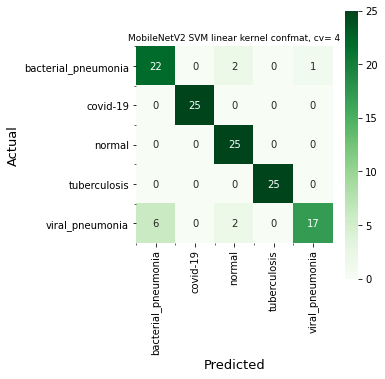

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


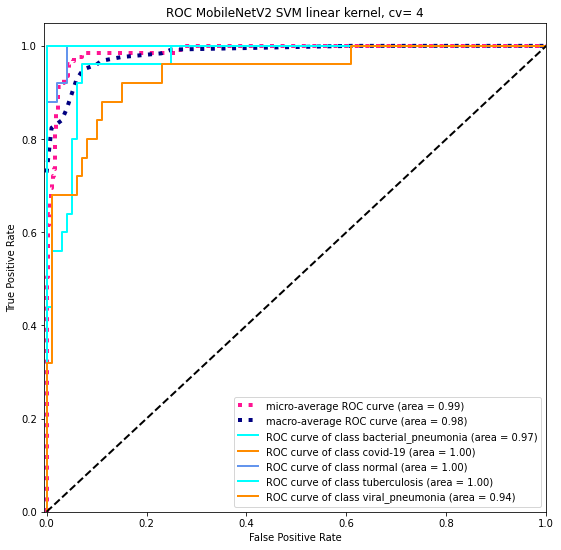

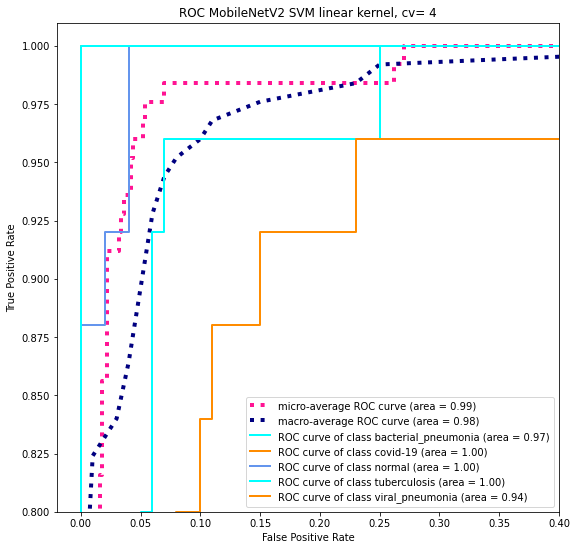

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.p

SVC(C=2.0309176209047348e-05, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

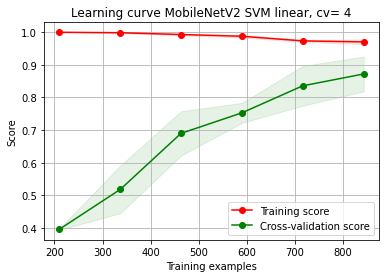

In [ ]:
cv=4
C = np.logspace(-5, 1, 40)
print(C)
make_classification(SVC(), 'MobileNetV2 SVM linear kernel confmat, cv= '+str(cv), 
                    'ROC MobileNetV2 SVM linear kernel, cv= '+str(cv),
                    'Learning curve MobileNetV2 SVM linear, cv= '+str(cv),
                    train_val_concat_features, train_val_concat_labels,
                    test_features, test_labels, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

[1.00000000e-05 1.42510267e-05 2.03091762e-05 2.89426612e-05
 4.12462638e-05 5.87801607e-05 8.37677640e-05 1.19377664e-04
 1.70125428e-04 2.42446202e-04 3.45510729e-04 4.92388263e-04
 7.01703829e-04 1.00000000e-03 1.42510267e-03 2.03091762e-03
 2.89426612e-03 4.12462638e-03 5.87801607e-03 8.37677640e-03
 1.19377664e-02 1.70125428e-02 2.42446202e-02 3.45510729e-02
 4.92388263e-02 7.01703829e-02 1.00000000e-01 1.42510267e-01
 2.03091762e-01 2.89426612e-01 4.12462638e-01 5.87801607e-01
 8.37677640e-01 1.19377664e+00 1.70125428e+00 2.42446202e+00
 3.45510729e+00 4.92388263e+00 7.01703829e+00 1.00000000e+01]
Training with parameter GridSearch tuning
Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.827, total=   4.4s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.845, total=   4.8s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.896, total=   4.9s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.819, total=   4.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.856, total=   4.8s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.893, total=   4.9s
[CV] C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear, score=0.821, total=   4.7s
[CV] C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear, score=0.859, total=   4.7s
[CV] C=2.030917620904734

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  9.3min finished


Best params:  {'C': 4.124626382901348e-05, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=4.124626382901348e-05, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.81      0.88      0.85        25
           covid-19       1.00      1.00      1.00        25
             normal       0.86      1.00      0.93        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.95      0.72      0.82        25

           accuracy                           0.92       125
          macro avg       0.92      0.92      0.92       125
       weighted avg       0.92      0.92      0.92       125

Loss: 0.17852530629167973
Confusion matrix, without norm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


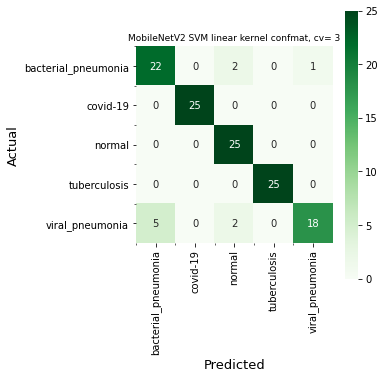

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


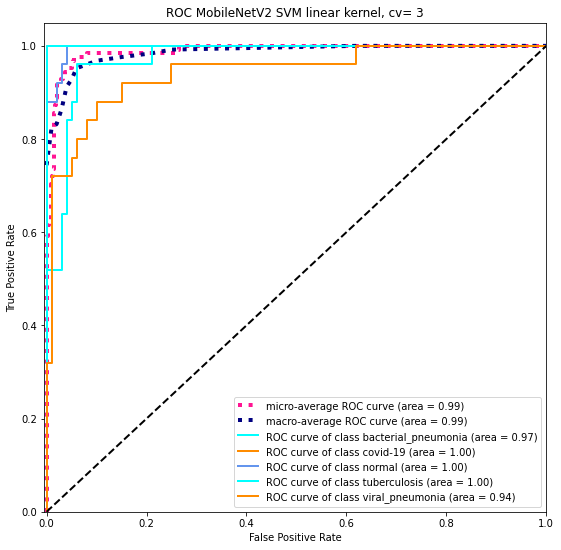

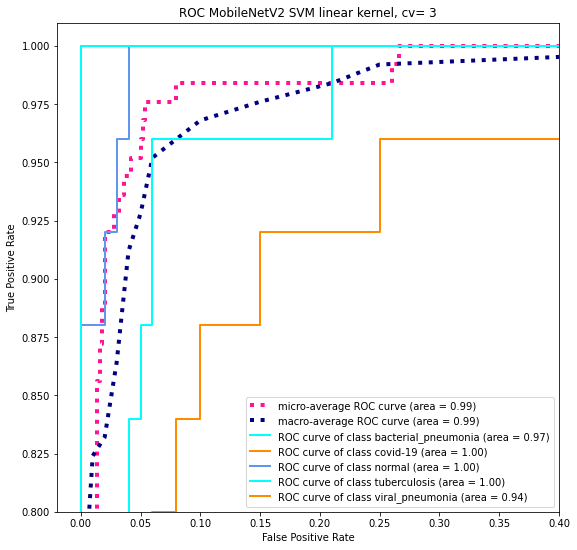

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)


SVC(C=4.124626382901348e-05, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

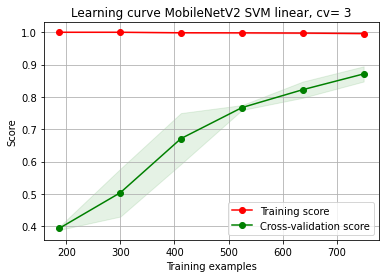

In [ ]:
cv=3
C = np.logspace(-5, 1, 40)
print(C)
make_classification(SVC(), 'MobileNetV2 SVM linear kernel confmat, cv= '+str(cv), 
                    'ROC MobileNetV2 SVM linear kernel, cv= '+str(cv),
                    'Learning curve MobileNetV2 SVM linear, cv= '+str(cv),
                    train_val_concat_features, train_val_concat_labels,
                    test_features, test_labels, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

# Feature Extraction and SVM CLASSIFICATION on data normalized to (0-1)

In [ ]:
# del base_model
base_model = (MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))# Freezing layers in convolutional base
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
________________

In [ ]:
#shape of output layer
output_shape = base_model.layers[-1].output_shape[-1]

print(output_shape)

1280


In [ ]:
del train_features, val_features, test_features
train_features = base_model.predict(X_train)
val_features = base_model.predict(X_val)
test_features = base_model.predict(X_test)

In [ ]:
print(train_features.shape)
train_features = train_features.reshape(train_features.shape[0], train_features.shape[1]*train_features.shape[2]*train_features.shape[3])
print(train_features.shape)

(1000, 7, 7, 1280)
(1000, 62720)


In [ ]:
print(val_features.shape)
val_features = val_features.reshape(val_features.shape[0], val_features.shape[1]*val_features.shape[2]*val_features.shape[3])
print(val_features.shape)

(125, 7, 7, 1280)
(125, 62720)


In [ ]:
print(test_features.shape)
test_features = test_features.reshape(test_features.shape[0], test_features.shape[1]*test_features.shape[2]*test_features.shape[3])
print(test_features.shape)

(125, 7, 7, 1280)
(125, 62720)


In [ ]:
del train_labels, test_labels, val_labels
print(Y_train.shape)
train_labels = train['Disease Type'].values
test_labels = test['Disease Type'].values
val_labels = val['Disease Type'].values
print(val_labels.shape)

(1000, 5)
(125,)


In [ ]:
train_val_concat_features = np.concatenate((train_features, val_features))

In [ ]:
train_val_concat_labels = np.concatenate((train_labels, val_labels))

In [ ]:
train_val_concat_features.shape
train_val_concat_labels.shape
np.unique(train_val_concat_labels).shape


[1.00000000e-05 1.42510267e-05 2.03091762e-05 2.89426612e-05
 4.12462638e-05 5.87801607e-05 8.37677640e-05 1.19377664e-04
 1.70125428e-04 2.42446202e-04 3.45510729e-04 4.92388263e-04
 7.01703829e-04 1.00000000e-03 1.42510267e-03 2.03091762e-03
 2.89426612e-03 4.12462638e-03 5.87801607e-03 8.37677640e-03
 1.19377664e-02 1.70125428e-02 2.42446202e-02 3.45510729e-02
 4.92388263e-02 7.01703829e-02 1.00000000e-01 1.42510267e-01
 2.03091762e-01 2.89426612e-01 4.12462638e-01 5.87801607e-01
 8.37677640e-01 1.19377664e+00 1.70125428e+00 2.42446202e+00
 3.45510729e+00 4.92388263e+00 7.01703829e+00 1.00000000e+01]
Training with parameter GridSearch tuning
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.791, total=   5.8s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.924, total=   5.3s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.876, total=   5.2s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.849, total=   5.3s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.902, total=   5.2s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.809, total=   5.2s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.920, total=   5.2s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.871, total=   5.2s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 17.3min finished


Best params:  {'C': 2.8942661247167517e-05, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=2.8942661247167517e-05, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.79      0.88      0.83        25
           covid-19       1.00      1.00      1.00        25
             normal       0.86      1.00      0.93        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.94      0.68      0.79        25

           accuracy                           0.91       125
          macro avg       0.92      0.91      0.91       125
       weighted avg       0.92      0.91      0.91       125

Loss: 0.19447875679725873
Confusion matrix, without no

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


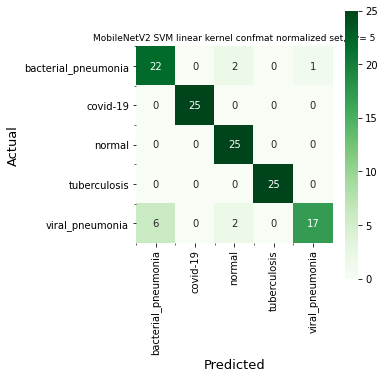

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


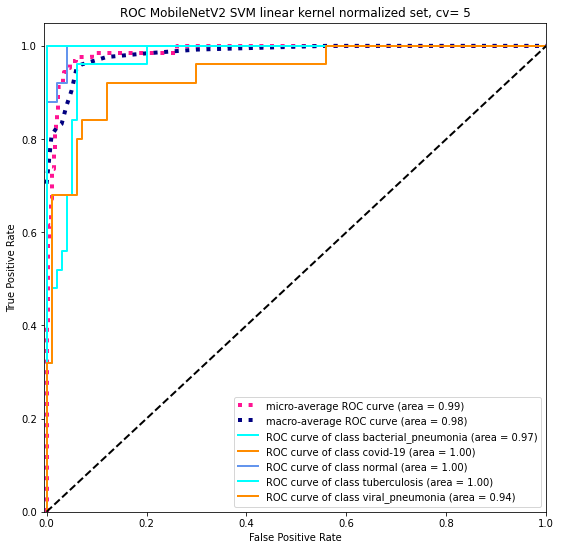

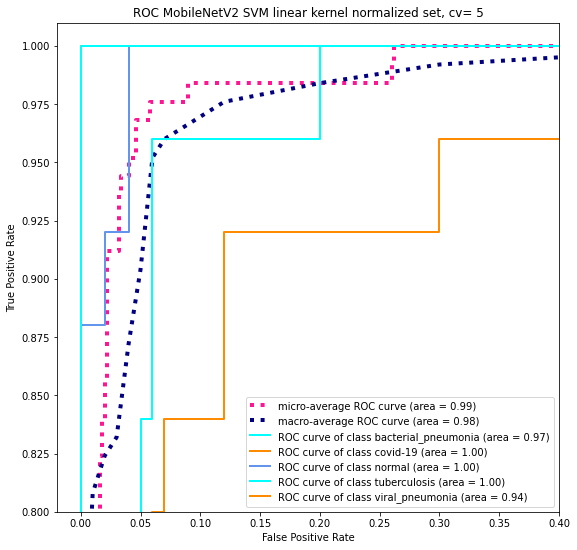

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.p

SVC(C=2.8942661247167517e-05, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

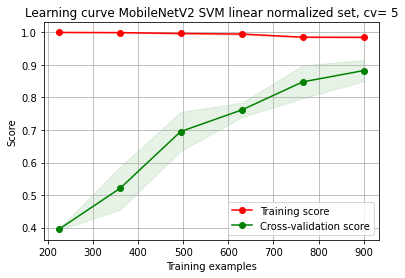

In [ ]:
cv=5
C = np.logspace(-5, 1, 40)
print(C)
make_classification(SVC(), 'MobileNetV2 SVM linear kernel confmat normalized set, cv= '+str(cv), 
                    'ROC MobileNetV2 SVM linear kernel normalized set, cv= '+str(cv),
                    'Learning curve MobileNetV2 SVM linear normalized set, cv= '+str(cv),
                    train_val_concat_features, train_val_concat_labels,
                    test_features, test_labels, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

[1.00000000e-05 1.42510267e-05 2.03091762e-05 2.89426612e-05
 4.12462638e-05 5.87801607e-05 8.37677640e-05 1.19377664e-04
 1.70125428e-04 2.42446202e-04 3.45510729e-04 4.92388263e-04
 7.01703829e-04 1.00000000e-03 1.42510267e-03 2.03091762e-03
 2.89426612e-03 4.12462638e-03 5.87801607e-03 8.37677640e-03
 1.19377664e-02 1.70125428e-02 2.42446202e-02 3.45510729e-02
 4.92388263e-02 7.01703829e-02 1.00000000e-01 1.42510267e-01
 2.03091762e-01 2.89426612e-01 4.12462638e-01 5.87801607e-01
 8.37677640e-01 1.19377664e+00 1.70125428e+00 2.42446202e+00
 3.45510729e+00 4.92388263e+00 7.01703829e+00 1.00000000e+01]
Training with parameter GridSearch tuning
Fitting 4 folds for each of 40 candidates, totalling 160 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.805, total=   5.0s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.925, total=   5.1s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.2s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.811, total=   4.9s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.911, total=   5.0s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.809, total=   4.9s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.932, total=   5.0s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.822, total=   4.9s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.911, total=   4.9s
[CV] C=2.0309176209047348e-05, decision_funct

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 13.0min finished


Best params:  {'C': 2.8942661247167517e-05, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=2.8942661247167517e-05, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.79      0.88      0.83        25
           covid-19       1.00      1.00      1.00        25
             normal       0.86      1.00      0.93        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.94      0.68      0.79        25

           accuracy                           0.91       125
          macro avg       0.92      0.91      0.91       125
       weighted avg       0.92      0.91      0.91       125

Loss: 0.19447875679725873
Confusion matrix, without no

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


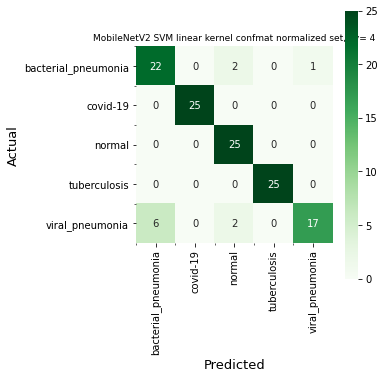

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


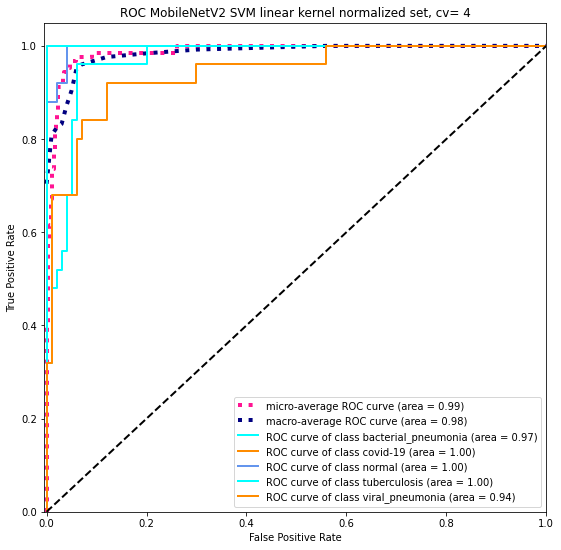

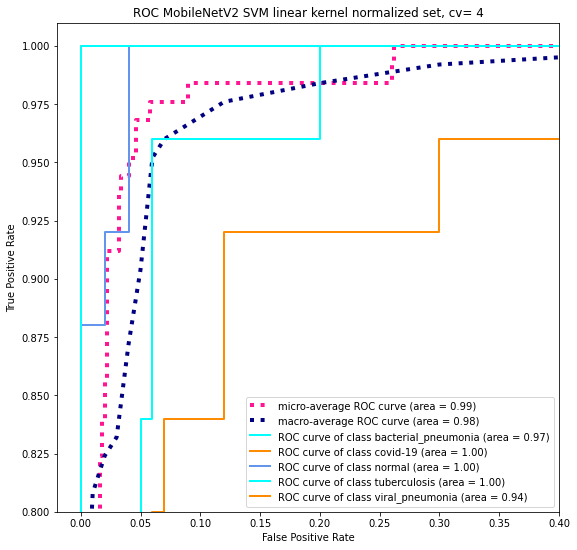

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.p

SVC(C=2.8942661247167517e-05, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

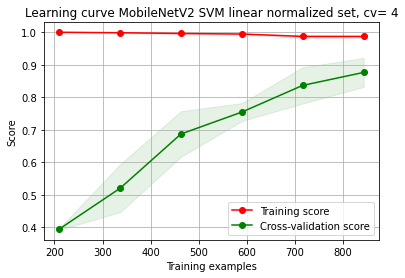

In [ ]:
cv=4
C = np.logspace(-5, 1, 40)
print(C)
make_classification(SVC(), 'MobileNetV2 SVM linear kernel confmat normalized set, cv= '+str(cv), 
                    'ROC MobileNetV2 SVM linear kernel normalized set, cv= '+str(cv),
                    'Learning curve MobileNetV2 SVM linear normalized set, cv= '+str(cv),
                    train_val_concat_features, train_val_concat_labels,
                    test_features, test_labels, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

[1.00000000e-05 1.42510267e-05 2.03091762e-05 2.89426612e-05
 4.12462638e-05 5.87801607e-05 8.37677640e-05 1.19377664e-04
 1.70125428e-04 2.42446202e-04 3.45510729e-04 4.92388263e-04
 7.01703829e-04 1.00000000e-03 1.42510267e-03 2.03091762e-03
 2.89426612e-03 4.12462638e-03 5.87801607e-03 8.37677640e-03
 1.19377664e-02 1.70125428e-02 2.42446202e-02 3.45510729e-02
 4.92388263e-02 7.01703829e-02 1.00000000e-01 1.42510267e-01
 2.03091762e-01 2.89426612e-01 4.12462638e-01 5.87801607e-01
 8.37677640e-01 1.19377664e+00 1.70125428e+00 2.42446202e+00
 3.45510729e+00 4.92388263e+00 7.01703829e+00 1.00000000e+01]
Training with parameter GridSearch tuning
Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.829, total=   4.9s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.845, total=   5.0s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.9s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.896, total=   5.0s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.821, total=   4.8s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.856, total=   4.9s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.899, total=   4.9s
[CV] C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear, score=0.835, total=   4.8s
[CV] C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear, score=0.864, total=   4.8s
[CV] C=2.030917620904734

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  9.4min finished


Best params:  {'C': 2.8942661247167517e-05, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=2.8942661247167517e-05, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.79      0.88      0.83        25
           covid-19       1.00      1.00      1.00        25
             normal       0.86      1.00      0.93        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.94      0.68      0.79        25

           accuracy                           0.91       125
          macro avg       0.92      0.91      0.91       125
       weighted avg       0.92      0.91      0.91       125

Loss: 0.19447875679725873
Confusion matrix, without no

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


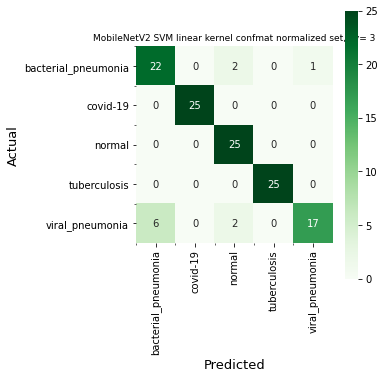

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


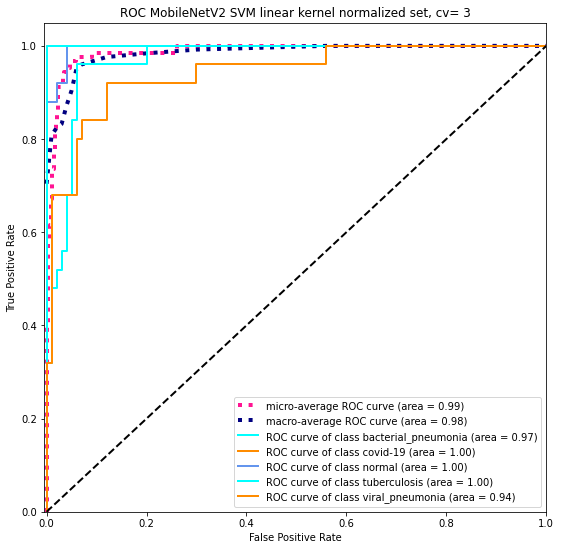

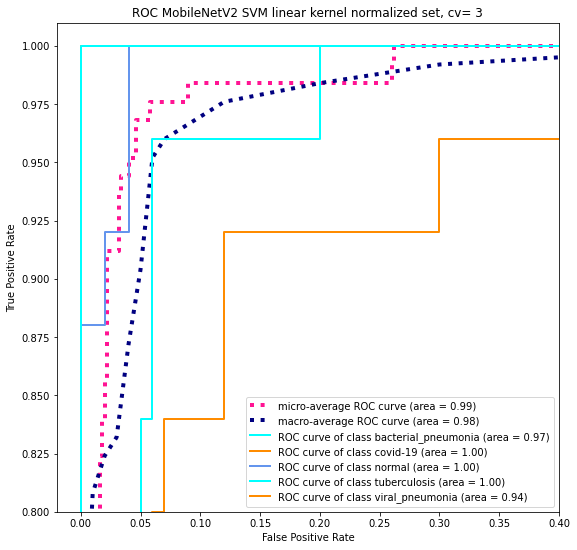

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)


SVC(C=2.8942661247167517e-05, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

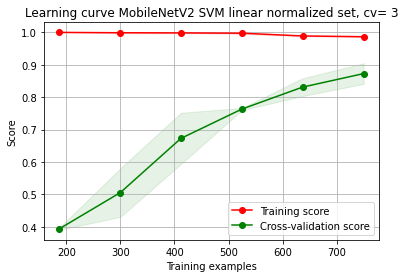

In [ ]:
cv=3
C = np.logspace(-5, 1, 40)
print(C)
make_classification(SVC(), 'MobileNetV2 SVM linear kernel confmat normalized set, cv= '+str(cv), 
                    'ROC MobileNetV2 SVM linear kernel normalized set, cv= '+str(cv),
                    'Learning curve MobileNetV2 SVM linear normalized set, cv= '+str(cv),
                    train_val_concat_features, train_val_concat_labels,
                    test_features, test_labels, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

# Feature Extraction and SVM CLASSIFICATION on data divided by 255 + CLAHE processed

In [ ]:
del base_model
base_model = (MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
# Freezing layers in convolutional base
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
#shape of output layer
output_shape = base_model.layers[-1].output_shape[-1]

print(output_shape)

1280


In [ ]:
train_features_CLAHE_ = base_model.predict(X_train_255_CLAHE)
val_features_CLAHE_ = base_model.predict(X_val_255_CLAHE)
test_features_CLAHE_ = base_model.predict(X_test_255_CLAHE)

In [ ]:
print(test_features_CLAHE_.shape)

test_features_CLAHE_ = test_features_CLAHE_.reshape(test_features_CLAHE_.shape[0], test_features_CLAHE_.shape[1]*test_features_CLAHE_.shape[2]*test_features_CLAHE_.shape[3])
print(test_features_CLAHE_.shape)

(125, 7, 7, 1280)
(125, 62720)


In [ ]:
print(train_features_CLAHE_.shape)

train_features_CLAHE_ = train_features_CLAHE_.reshape(train_features_CLAHE_.shape[0], 7*7*1280)
print(train_features_CLAHE_.shape)

(1000, 7, 7, 1280)
(1000, 62720)


In [ ]:
print(val_features_CLAHE_.shape)

val_features_CLAHE_ = val_features_CLAHE_.reshape(val_features_CLAHE_.shape[0], 7*7*1280)
print(val_features_CLAHE_.shape)

(125, 7, 7, 1280)
(125, 62720)


In [ ]:
train_labelsCLAHE_ = train['Disease Type'].values
test_labelsCLAHE_ = test['Disease Type'].values
val_labelsCLAHE_ = val['Disease Type'].values

In [ ]:
train_val_concat_features_CLAHE_ = np.concatenate((train_features_CLAHE_, val_features_CLAHE_))

In [ ]:
train_val_concat_labels_CLAHE_ = np.concatenate((train_labelsCLAHE_, val_labelsCLAHE_))

[1.00000000e-05 1.42510267e-05 2.03091762e-05 2.89426612e-05
 4.12462638e-05 5.87801607e-05 8.37677640e-05 1.19377664e-04
 1.70125428e-04 2.42446202e-04 3.45510729e-04 4.92388263e-04
 7.01703829e-04 1.00000000e-03 1.42510267e-03 2.03091762e-03
 2.89426612e-03 4.12462638e-03 5.87801607e-03 8.37677640e-03
 1.19377664e-02 1.70125428e-02 2.42446202e-02 3.45510729e-02
 4.92388263e-02 7.01703829e-02 1.00000000e-01 1.42510267e-01
 2.03091762e-01 2.89426612e-01 4.12462638e-01 5.87801607e-01
 8.37677640e-01 1.19377664e+00 1.70125428e+00 2.42446202e+00
 3.45510729e+00 4.92388263e+00 7.01703829e+00 1.00000000e+01]
Training with parameter GridSearch tuning
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.818, total=   6.2s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.924, total=   5.4s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.6s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.858, total=   5.3s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.836, total=   5.4s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.889, total=   5.4s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.827, total=   5.3s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.929, total=   5.4s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.876, total=   5.3s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 17.7min finished


Best params:  {'C': 2.8942661247167517e-05, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=2.8942661247167517e-05, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.83      0.76      0.79        25
           covid-19       1.00      1.00      1.00        25
             normal       0.83      0.96      0.89        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.78      0.72      0.75        25

           accuracy                           0.89       125
          macro avg       0.89      0.89      0.89       125
       weighted avg       0.89      0.89      0.89       125

Loss: 0.2520435743973478
Confusion matrix, without nor

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


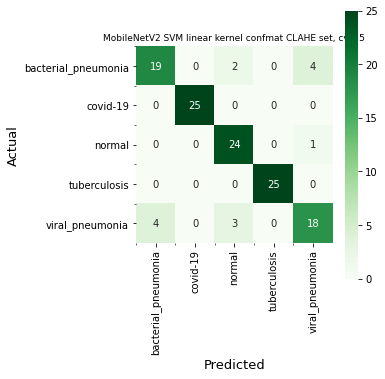

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


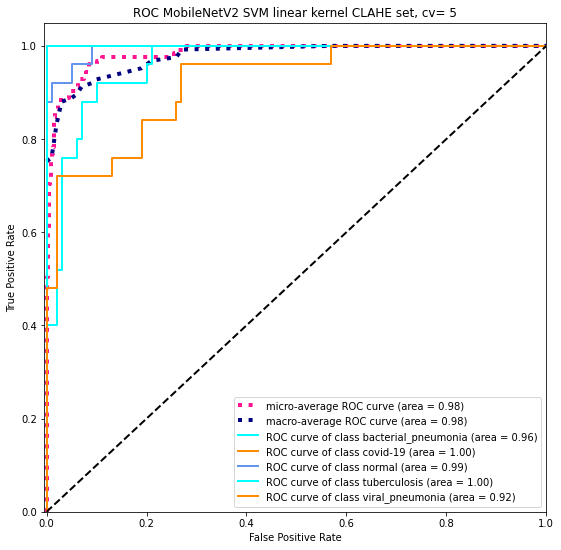

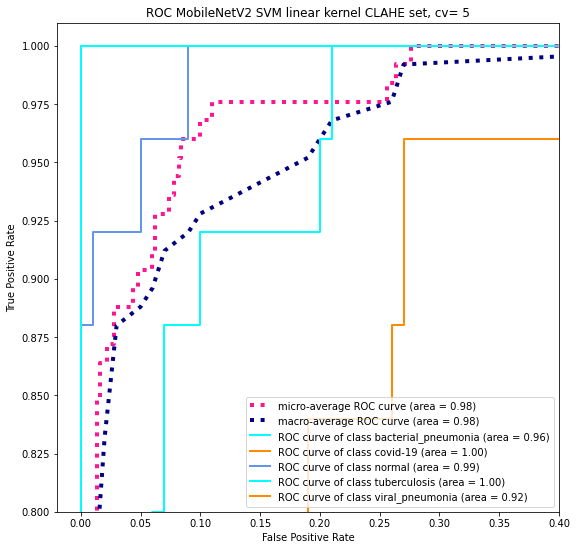

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.p

SVC(C=2.8942661247167517e-05, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

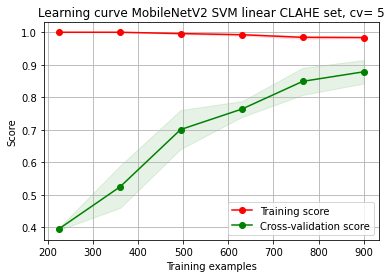

In [ ]:
cv=5
C = np.logspace(-5, 1, 40)
print(C)
make_classification(SVC(), 'MobileNetV2 SVM linear kernel confmat CLAHE set, cv= '+str(cv), 
                    'ROC MobileNetV2 SVM linear kernel CLAHE set, cv= '+str(cv),
                    'Learning curve MobileNetV2 SVM linear CLAHE set, cv= '+str(cv),
                    train_val_concat_features_CLAHE_, train_val_concat_labels_CLAHE_,
                    test_features_CLAHE_, test_labelsCLAHE_, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

[1.00000000e-05 1.42510267e-05 2.03091762e-05 2.89426612e-05
 4.12462638e-05 5.87801607e-05 8.37677640e-05 1.19377664e-04
 1.70125428e-04 2.42446202e-04 3.45510729e-04 4.92388263e-04
 7.01703829e-04 1.00000000e-03 1.42510267e-03 2.03091762e-03
 2.89426612e-03 4.12462638e-03 5.87801607e-03 8.37677640e-03
 1.19377664e-02 1.70125428e-02 2.42446202e-02 3.45510729e-02
 4.92388263e-02 7.01703829e-02 1.00000000e-01 1.42510267e-01
 2.03091762e-01 2.89426612e-01 4.12462638e-01 5.87801607e-01
 8.37677640e-01 1.19377664e+00 1.70125428e+00 2.42446202e+00
 3.45510729e+00 4.92388263e+00 7.01703829e+00 1.00000000e+01]
Training with parameter GridSearch tuning
Fitting 4 folds for each of 40 candidates, totalling 160 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.833, total=   5.0s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.932, total=   5.0s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.0s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.794, total=   5.0s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.890, total=   5.0s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.837, total=   4.9s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.940, total=   5.0s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.819, total=   4.9s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.904, total=   4.9s
[CV] C=2.0309176209047348e-05, decision_funct

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 13.2min finished


Best params:  {'C': 2.0309176209047348e-05, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=2.0309176209047348e-05, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.80      0.80      0.80        25
           covid-19       1.00      1.00      1.00        25
             normal       0.80      0.96      0.87        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.85      0.68      0.76        25

           accuracy                           0.89       125
          macro avg       0.89      0.89      0.89       125
       weighted avg       0.89      0.89      0.89       125

Loss: 0.25229705183515094
Confusion matrix, without no

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


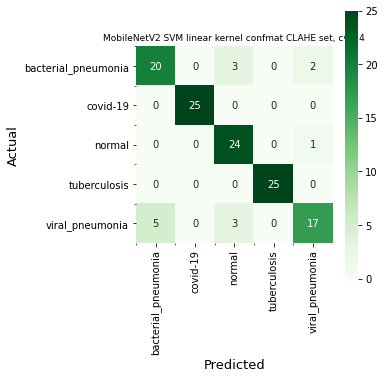

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


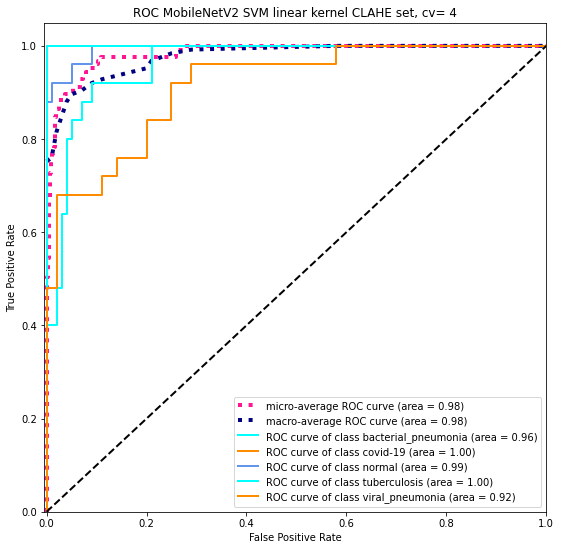

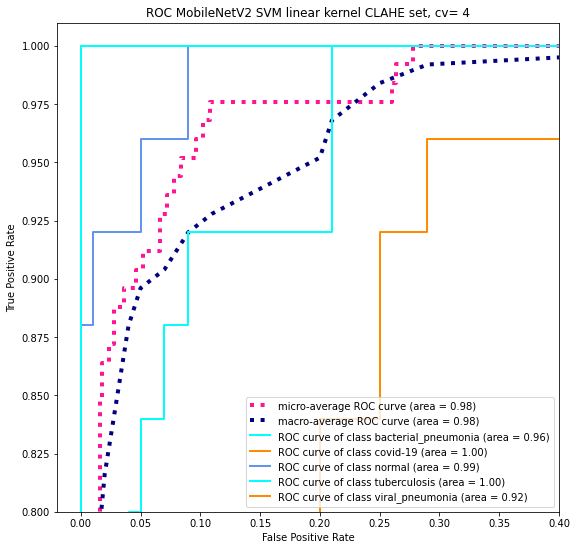

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.p

SVC(C=2.0309176209047348e-05, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

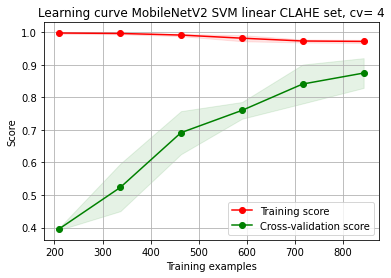

In [ ]:
cv=4
C = np.logspace(-5, 1, 40)
print(C)
make_classification(SVC(), 'MobileNetV2 SVM linear kernel confmat CLAHE set, cv= '+str(cv), 
                    'ROC MobileNetV2 SVM linear kernel CLAHE set, cv= '+str(cv),
                    'Learning curve MobileNetV2 SVM linear CLAHE set, cv= '+str(cv),
                    train_val_concat_features_CLAHE_, train_val_concat_labels_CLAHE_,
                    test_features_CLAHE_, test_labelsCLAHE_, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

[1.00000000e-05 1.42510267e-05 2.03091762e-05 2.89426612e-05
 4.12462638e-05 5.87801607e-05 8.37677640e-05 1.19377664e-04
 1.70125428e-04 2.42446202e-04 3.45510729e-04 4.92388263e-04
 7.01703829e-04 1.00000000e-03 1.42510267e-03 2.03091762e-03
 2.89426612e-03 4.12462638e-03 5.87801607e-03 8.37677640e-03
 1.19377664e-02 1.70125428e-02 2.42446202e-02 3.45510729e-02
 4.92388263e-02 7.01703829e-02 1.00000000e-01 1.42510267e-01
 2.03091762e-01 2.89426612e-01 4.12462638e-01 5.87801607e-01
 8.37677640e-01 1.19377664e+00 1.70125428e+00 2.42446202e+00
 3.45510729e+00 4.92388263e+00 7.01703829e+00 1.00000000e+01]
Training with parameter GridSearch tuning
Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.851, total=   4.7s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.843, total=   4.7s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.883, total=   4.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.851, total=   5.0s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.861, total=   5.0s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.888, total=   5.0s
[CV] C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear, score=0.851, total=   5.0s
[CV] C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear, score=0.869, total=   4.9s
[CV] C=2.030917620904734

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  9.8min finished


Best params:  {'C': 2.0309176209047348e-05, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=2.0309176209047348e-05, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.80      0.80      0.80        25
           covid-19       1.00      1.00      1.00        25
             normal       0.80      0.96      0.87        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.85      0.68      0.76        25

           accuracy                           0.89       125
          macro avg       0.89      0.89      0.89       125
       weighted avg       0.89      0.89      0.89       125

Loss: 0.25229705183515094
Confusion matrix, without no

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


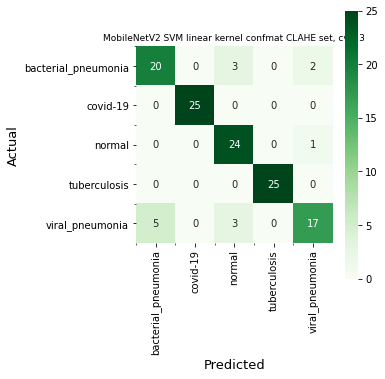

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


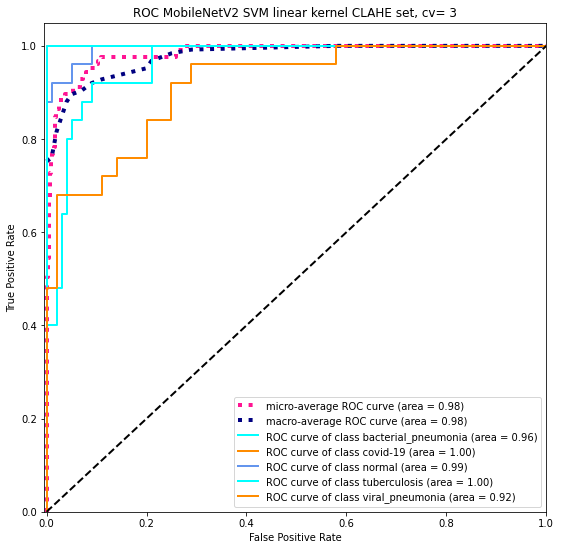

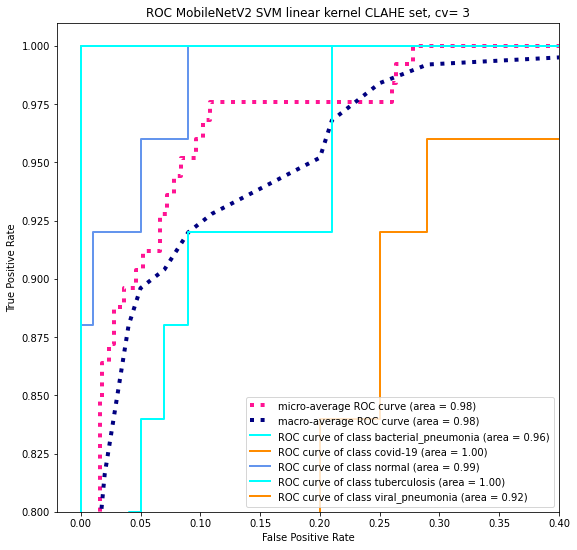

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)


SVC(C=2.0309176209047348e-05, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

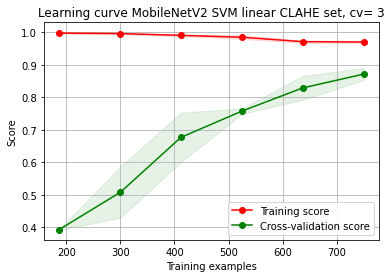

In [ ]:
cv=3
C = np.logspace(-5, 1, 40)
print(C)
make_classification(SVC(), 'MobileNetV2 SVM linear kernel confmat CLAHE set, cv= '+str(cv), 
                    'ROC MobileNetV2 SVM linear kernel CLAHE set, cv= '+str(cv),
                    'Learning curve MobileNetV2 SVM linear CLAHE set, cv= '+str(cv),
                    train_val_concat_features_CLAHE_, train_val_concat_labels_CLAHE_,
                    test_features_CLAHE_, test_labelsCLAHE_, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

# Feature Extraction and SVM CLASSIFICATION on data normalized to (0-1) + CLAHE processed

In [ ]:
# del base_model
base_model = (MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
# Freezing layers in convolutional base
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
#shape of output layer
output_shape = base_model.layers[-1].output_shape[-1]

print(output_shape)

1280


In [ ]:
del train_features_CLAHE_, val_features_CLAHE_, test_features_CLAHE_
train_features_CLAHE_ = base_model.predict(X_train_CLAHE)
val_features_CLAHE_ = base_model.predict(X_val_CLAHE)
test_features_CLAHE_ = base_model.predict(X_test_CLAHE)

In [ ]:
print(test_features_CLAHE_.shape)

test_features_CLAHE_ = test_features_CLAHE_.reshape(test_features_CLAHE_.shape[0], 7*7*1280)
print(test_features_CLAHE_.shape)

(125, 7, 7, 1280)
(125, 62720)


In [ ]:
print(train_features_CLAHE_.shape)

train_features_CLAHE_ = train_features_CLAHE_.reshape(train_features_CLAHE_.shape[0], 7*7*1280)
print(train_features_CLAHE_.shape)

(1000, 7, 7, 1280)
(1000, 62720)


In [ ]:
print(val_features_CLAHE_.shape)

val_features_CLAHE_ = val_features_CLAHE_.reshape(val_features_CLAHE_.shape[0], 7*7*1280)
print(val_features_CLAHE_.shape)

(125, 7, 7, 1280)
(125, 62720)


In [ ]:
train_labelsCLAHE_ = train['Disease Type'].values
test_labelsCLAHE_ = test['Disease Type'].values
val_labelsCLAHE_ = val['Disease Type'].values
print(val_labelsCLAHE_.shape)
print(train_labelsCLAHE_.shape)
print(test_labelsCLAHE_.shape)

(125,)
(1000,)
(125,)


In [ ]:
del train_val_concat_features_CLAHE_, train_val_concat_labels_CLAHE_
train_val_concat_features_CLAHE_ = np.concatenate((train_features_CLAHE_, val_features_CLAHE_))

In [ ]:
train_val_concat_labels_CLAHE_ = np.concatenate((train_labelsCLAHE_, val_labelsCLAHE_))

Training with parameter GridSearch tuning
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.822, total=   5.9s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.924, total=   5.2s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.2s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.844, total=   5.1s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.831, total=   5.2s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.884, total=   5.1s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.827, total=   5.0s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.924, total=   5.1s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.876, total=   5.0s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 17.0min finished


Best params:  {'C': 2.0309176209047348e-05, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=2.0309176209047348e-05, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.80      0.80      0.80        25
           covid-19       1.00      0.96      0.98        25
             normal       0.80      0.96      0.87        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.81      0.68      0.74        25

           accuracy                           0.88       125
          macro avg       0.88      0.88      0.88       125
       weighted avg       0.88      0.88      0.88       125

Loss: 0.2682889983163351
Confusion matrix, without nor

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


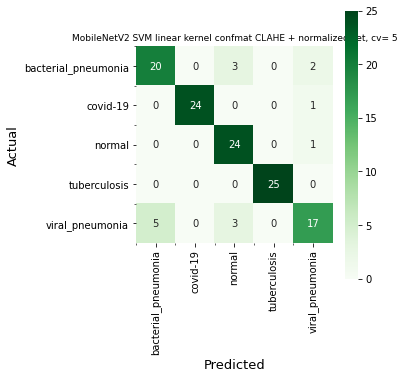

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


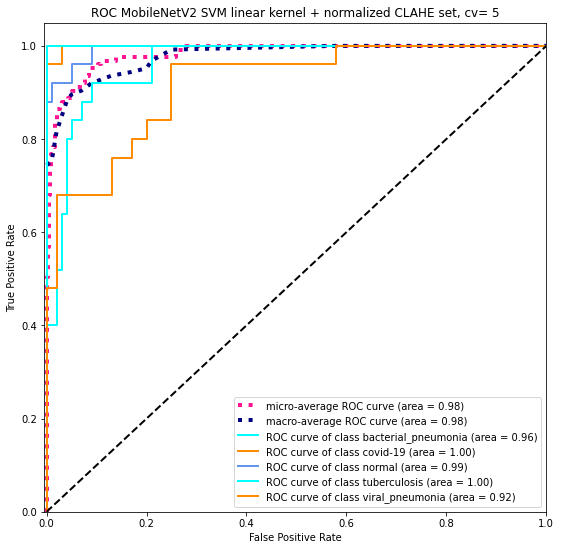

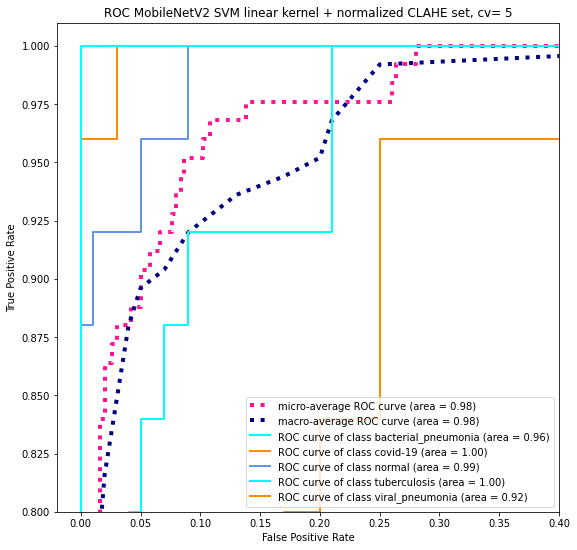

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.p

SVC(C=2.0309176209047348e-05, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

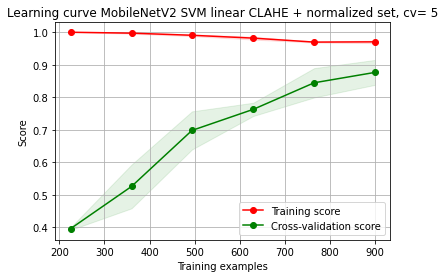

In [ ]:
cv=5
C=np.logspace(-5,1,40)
make_classification(SVC(), 'MobileNetV2 SVM linear kernel confmat CLAHE + normalized set, cv= '+str(cv), 
                    'ROC MobileNetV2 SVM linear kernel + normalized CLAHE set, cv= '+str(cv),
                    'Learning curve MobileNetV2 SVM linear CLAHE + normalized set, cv= '+str(cv),
                    train_val_concat_features_CLAHE_, train_val_concat_labels_CLAHE_,
                    test_features_CLAHE_, test_labelsCLAHE_, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

Training with parameter GridSearch tuning
Fitting 4 folds for each of 40 candidates, totalling 160 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.837, total=   4.8s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.932, total=   4.9s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.8s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.794, total=   4.8s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............
[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.883, total=   4.8s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.837, total=   4.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.936, total=   5.7s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.822, total=   4.8s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.897, total=   4.8s
[CV] C=2.0309176209047348e-05, decision_funct

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 12.8min finished


Best params:  {'C': 1.4251026703029993e-05, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=1.4251026703029993e-05, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.80      0.80      0.80        25
           covid-19       1.00      0.92      0.96        25
             normal       0.80      0.96      0.87        25
       tuberculosis       0.96      1.00      0.98        25
    viral_pneumonia       0.81      0.68      0.74        25

           accuracy                           0.87       125
          macro avg       0.87      0.87      0.87       125
       weighted avg       0.87      0.87      0.87       125

Loss: 0.2846258511592262
Confusion matrix, without nor

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


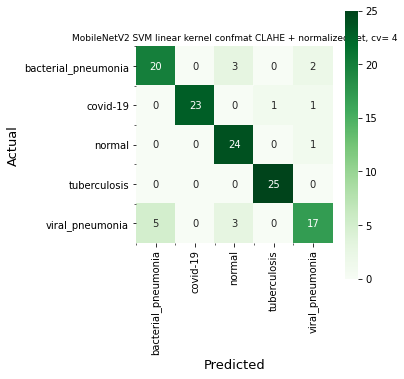

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


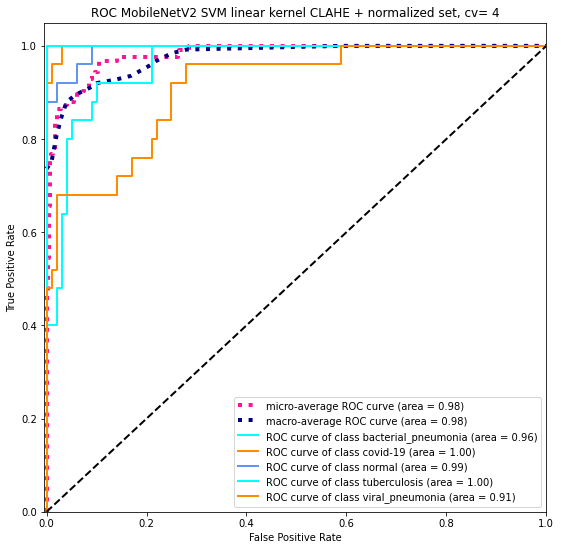

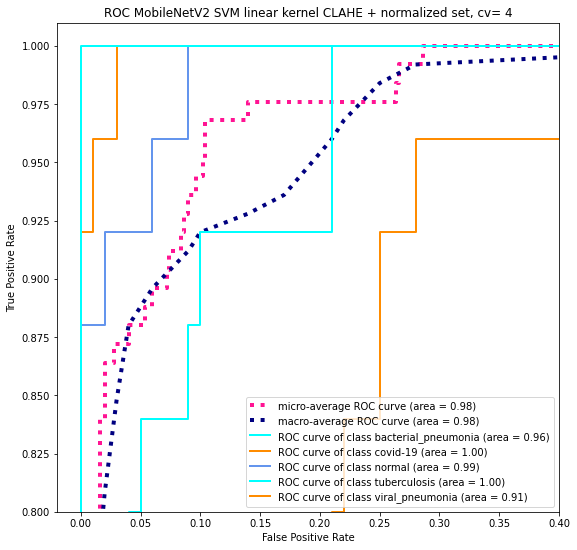

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.p

SVC(C=1.4251026703029993e-05, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

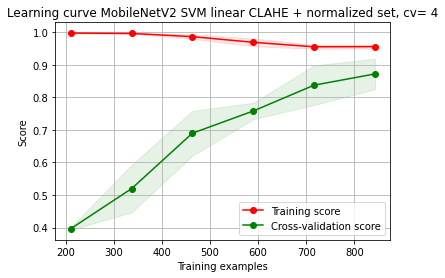

In [ ]:
cv=4
C=np.logspace(-5,1,40)
make_classification(SVC(), 'MobileNetV2 SVM linear kernel confmat CLAHE + normalized set, cv= '+str(cv), 
                    'ROC MobileNetV2 SVM linear kernel CLAHE + normalized set, cv= '+str(cv),
                    'Learning curve MobileNetV2 SVM linear CLAHE + normalized set, cv= '+str(cv),
                    train_val_concat_features_CLAHE_, train_val_concat_labels_CLAHE_,
                    test_features_CLAHE_, test_labelsCLAHE_, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)

Training with parameter GridSearch tuning
Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.853, total=   4.9s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.843, total=   4.9s
[CV] C=1e-05, decision_function_shape=ovr, kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.8s remaining:    0.0s


[CV]  C=1e-05, decision_function_shape=ovr, kernel=linear, score=0.875, total=   4.5s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.851, total=   4.4s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.856, total=   4.8s
[CV] C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=1.4251026703029993e-05, decision_function_shape=ovr, kernel=linear, score=0.883, total=   4.8s
[CV] C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear, score=0.851, total=   4.4s
[CV] C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear 
[CV]  C=2.0309176209047348e-05, decision_function_shape=ovr, kernel=linear, score=0.872, total=   4.4s
[CV] C=2.030917620904734

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  9.3min finished


Best params:  {'C': 2.0309176209047348e-05, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
Best estimator:  SVC(C=2.0309176209047348e-05, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
(125,)
                     precision    recall  f1-score   support

bacterial_pneumonia       0.80      0.80      0.80        25
           covid-19       1.00      0.96      0.98        25
             normal       0.80      0.96      0.87        25
       tuberculosis       1.00      1.00      1.00        25
    viral_pneumonia       0.81      0.68      0.74        25

           accuracy                           0.88       125
          macro avg       0.88      0.88      0.88       125
       weighted avg       0.88      0.88      0.88       125

Loss: 0.2682889983163351
Confusion matrix, without nor

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


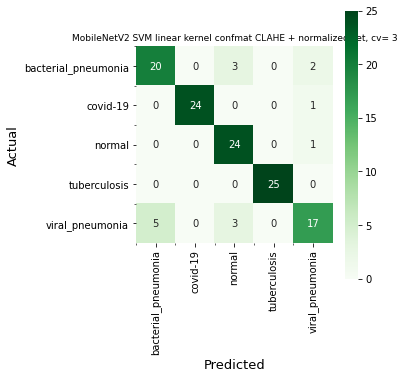

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


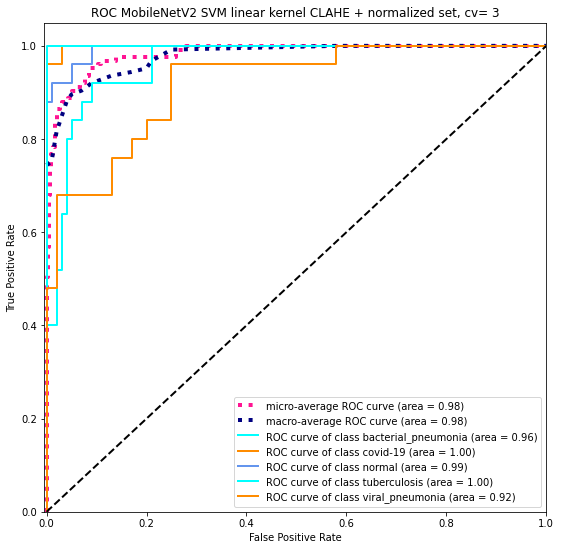

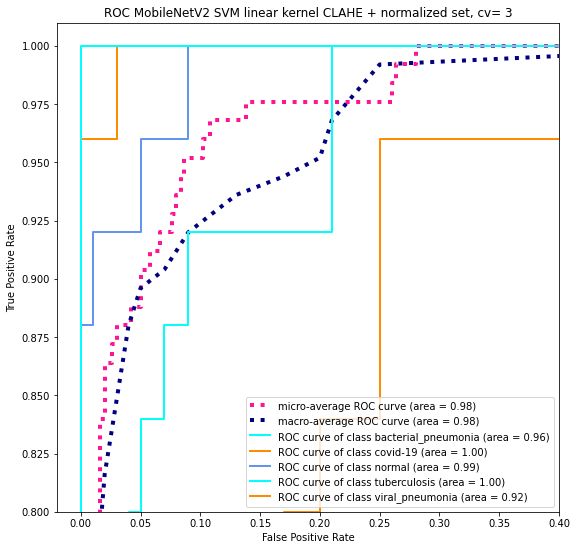

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)


SVC(C=2.0309176209047348e-05, break_ties=False, cache_size=200,
    class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma='scale', kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

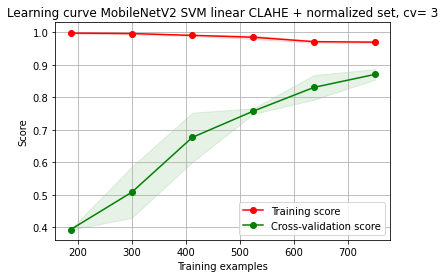

In [ ]:
cv=3
C=np.logspace(-5,1,40)
make_classification(SVC(), 'MobileNetV2 SVM linear kernel confmat CLAHE + normalized set, cv= '+str(cv), 
                    'ROC MobileNetV2 SVM linear kernel CLAHE + normalized set, cv= '+str(cv),
                    'Learning curve MobileNetV2 SVM linear CLAHE + normalized set, cv= '+str(cv),
                    train_val_concat_features_CLAHE_, train_val_concat_labels_CLAHE_,
                    test_features_CLAHE_, test_labelsCLAHE_, cv, 'linear', 'ovr', 3, 
                    C, True, False, Y_test)